<a href="https://colab.research.google.com/github/EErlando/Quarterly-Bytes/blob/main/notebooks/2_exploratory_data_analysis/JKW_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Git Hub Setup

### Setup, Constants, and Imports

In [161]:
import os
import sys
import logging

### Notebook Configs

In [162]:
IS_COLAB = 'google.colab' in sys.modules
OUTPUT_PROCESSED_FILES = True # TODO: Use this if you want to output save files (optional - see below)

if IS_COLAB:
    from google.colab import userdata
    GITHUB_USERNAME = userdata.get('github_user')
    GITHUB_TOKEN = userdata.get('github_token')
    GITHUB_EMAIL = userdata.get('github_email')

### Constants

In [164]:
REPO_URL = "https://github.com/EErlando/Quarterly-Bytes.git"
REPO_NAME = "src"
REPO_BRANCH = "main" # TODO: UPDATE THIS TO YOU BRANCH - DEFAULT TO MAIN
ALL_TRANSCRIPTS_PATH = "data/raw/JP Morgan/Transcripts"
NOTEBOOK_DIR = "notebooks" # TODO: UPDATE THIS TO YOUR NOTEBOOK DIRECTORY (e.g. 1_data_extraction_and_processing)

### Clone and Pull Latest from Repository - Colab Specific

In [165]:
if IS_COLAB:
    !git config pull.rebase false
    if os.path.exists(REPO_NAME):
        print(f"Directory '{REPO_NAME}' already exists. Pulling latest changes...")
        %cd {REPO_NAME}
        !git pull origin {REPO_BRANCH} --quiet
        %cd ..
    else:
        print(f"Cloning repository into '{REPO_NAME}'...")
        !git clone --quiet --branch {REPO_BRANCH} {REPO_URL} {REPO_NAME}
        print("Clone complete.")

    sys.path.append('/content/src/')
    %cd /content/src/
    !pip install -r requirements.txt
else:
    !pip install -r requirements.txt
    if os.path.basename(os.getcwd()) == NOTEBOOK_DIR:
        os.chdir('../') # TODO: UPDATE THIS TO ROOT OF REPO

logging.basicConfig(level=logging.ERROR, format='%(levelname)s: %(message)s')

Directory 'src' already exists. Pulling latest changes...
/content/src/src
/content/src
/content/src


### Local Imports Example

In [ ]:
from src.utils.pdf_utils import BankType, extract_text_from_pdf

BankType.GOLDMAN_SACHS.value

'Goldman Sachs'

In [ ]:
extract_text_from_pdf("data/raw/Goldman Sachs/Transcripts/1q23_earnings_transcript.pdf")

"The Goldman Sachs Group, Inc. (GS) Q1\n2023 Earnings Call T ranscript\nApr. 18, 2023 1:05 PM ET |The Goldman Sachs Group, Inc. (GS) Stock , GS.PR.A  Stock , GS.PR.C\nStock , GS.PR.J Stock , GS.PR.D Stock , GS.PR.K Stock |GS, GS.PR.A , GS.PR.C ...\nWelcome to Seeking Alpha!\nArticles on GS are available to you for free for the next 30 days.\nTo continue receiving professional-grade analyses on  GS and gain access to similar insights\nacross the entire market, subscribe to Premium before your trial expires. Start today for only\n$4.95 for your ﬁrst month.\nQ1: 2023-04-18 Earnings Summary\nEPS of $8.79 beats by $0.73 \xa0|\xa0Revenue of $12.22B  (-5.48% Y/Y) misses by $423.93MTranscripts\nSA Transcripts\n153.88K  Follower s\nJoin Premium\nThe Goldman Sachs Group, Inc. ( NYSE: GS) Q1 2023 Earnings Conference Call\nApril 18, 2023 9:30 AM ET\nCompany Participants\nCarey Halio - Head of IR and Chief Strategy Ofﬁcer\nDavid Solomon - Chairman and CEO\nDenis Coleman - CFO\nConference Call Parti

### Save Data Example

In [ ]:
import pandas as pd

target_dir = 'data/temp/'
file_name = 'dummy_test_output_new.csv'
dummy_pf = pd.DataFrame({'from_colab': [IS_COLAB, True, 'hello']})


if OUTPUT_PROCESSED_FILES:
    if IS_COLAB:
        AUTHENTICATED_REPO_URL = REPO_URL.replace("https://", f"https://{GITHUB_USERNAME}:{GITHUB_TOKEN}@")
        dummy_pf.to_csv(f"{target_dir}{file_name}", index=False)

        # Configure Git user (important for committing)
        !git config user.email "{GITHUB_EMAIL}"
        !git config user.name "{GITHUB_USERNAME}"
        !git remote set-url origin {AUTHENTICATED_REPO_URL}

        # Add the file to staging
        !git add {target_dir}{file_name}
        print(f"Added '{target_dir}{file_name}' to staging.")

        # Commit the changes
        commit_message = f"Add new data file: {target_dir}{file_name}"
        !git commit -m "{commit_message}"
        print(f"Committed changes with message: '{commit_message}'")
        print(f"Attempted commit with message: '{commit_message}'")

        # Add this line to debug:
        print(f"Value of REPO_BRANCH before push: {REPO_BRANCH}")

        print("Pushing changes to GitHub. Please enter your GitHub username and Personal Access Token when prompted.")
        !git push --set-upstream origin {REPO_BRANCH} --force
        print("Push command executed. Check output for success or prompt.")
    else:
        dummy_pf.to_csv(f"{target_dir}{file_name}", index=False)
        print("Processed files saved successfully.")

Added 'data/temp/dummy_test_output_new.csv' to staging.
On branch LP_fix_colab_update_issue
Your branch is up to date with 'origin/LP_fix_colab_update_issue'.

nothing to commit, working tree clean
Committed changes with message: 'Add new data file: data/temp/dummy_test_output_new.csv'
Attempted commit with message: 'Add new data file: data/temp/dummy_test_output_new.csv'
Value of REPO_BRANCH before push: LP_fix_colab_update_issue
Pushing changes to GitHub. Please enter your GitHub username and Personal Access Token when prompted.
Branch 'LP_fix_colab_update_issue' set up to track remote branch 'LP_fix_colab_update_issue' from 'origin'.
Everything up-to-date
Push command executed. Check output for success or prompt.


# Sentiment Analysis

## Introduction

This section of the project focuses on leveraging FinBert models to score the transcripts (Discussion and Q&A seperately) and examine the overall tone of the conversations during earning calls. Further, it will serve as a input to a Sentiment Divergence analysis that will guide the PRA to relevant topics that can be of interest.

The focus will be on three models

* Sentiment analysis finbert models

    * "yiyanghkust/finbert-tone"
    * "ProsusAI/finbert"

* Reasoning model — microsoft/Phi-4-mini-instruct

The Financial Sentiment Divergence Analysis produces two primary deliverables: an enriched dataset and a narrative PDF report. The enriched dataset provides a structured view of sentiment dynamics in earnings call Q&A sessions, capturing analyst questions, management responses, pre-labeled sentiment scores, and a generated explanation for any divergence in tone. Each record links sentiment back to specific quotes, speaker roles, and reporting periods, ensuring full traceability. Complementing this, the narrative PDF report summarizes key instances of sentiment divergence, presenting side-by-side excerpts from analysts and management along with concise explanations of the underlying mismatch in perspective. This report is designed to support PRA analysts by highlighting areas of potential concern or disconnect, aiding supervisory insight.

Designed for technical users within the PRA, this document provides a detailed understanding of the methodology  and reasoning behind the choice of the model. It aims to offer transparency into the model's application, potential, and limitations.



Key Deliverables of this Notebook:

* Visuals comparing distibution of sentiment scores and labels using two finbert models: ProsusAI and yiyanghkust.

*  PDF report showing the summarizing all instances of sentiment divergence over the period examined, presenting side-by-side excerpts from analysts and management along with concise explanations of the underlying mismatch in perspective.


## Load Relevant Packages and Documents

In [166]:
# Install packages
! pip install transformers tensorflow nltk

In [167]:
# Import packages

# Primary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Transformers and Tensorflow
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import tensorflow as tf

# NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


### Data

In [168]:
# Files

gs_discussion = '/content/src/data/processed/Goldman Sachs/discussion_df.csv'
gs_q_and_a = '/content/src/data/processed/Goldman Sachs/qna_df.csv'
jpm_discussion = '/content/src/data/processed/JP Morgan/discussion_df.csv'
jpm_q_and_a = '/content/src/data/processed/JP Morgan/qna_df.csv'

In [169]:
# Load files
df_gs_discussion = pd.read_csv(gs_discussion)
df_gs_q_and_a = pd.read_csv(gs_q_and_a)
df_jpm_discussion = pd.read_csv(jpm_discussion)
df_jpm_q_and_a = pd.read_csv(jpm_q_and_a)

In [170]:
df_jpm_discussion.head()

,speaker,role,company,content,year,quarter
0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Thanks, operator. Good morning, everyone. The ...",2022,1
1,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Thanks, operator. Good morning, everyone. The ...",2022,2
2,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Thank you very much. Good morning, everyone. A...",2022,3
3,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Yeah, Jeremy, thank you very much. Hello, ever...",2022,3
4,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Yeah. Thanks, Jamie. Let's go ahead and open u...",2022,3


In [171]:
df_jpm_discussion["role"].unique()

array(['Chief Financial Officer', 'Chairman & Chief Executive Officer'],
      dtype=object)

In [172]:
df_jpm_discussion["speaker"].unique()

array(['Jeremy Barnum', 'Jamie Dimon', 'Jamie  Dimon'], dtype=object)

In [173]:
df_jpm_q_and_a.head()

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter
0,0,1,John E. McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1
1,1,1,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1
2,2,1,John E. McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1
3,3,1,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1
4,4,1,John E. McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1


In [174]:
df_jpm_q_and_a["role"].unique()

array(['Analyst', 'Chief Financial Officer',
       'Chairman & Chief Executive Officer'], dtype=object)

In [175]:
df_jpm_q_and_a["speaker"].unique()

array(['John E. McDonald', 'Jeremy Barnum', 'Ken Usdin',
       'Betsy L. Graseck', 'Jamie Dimon', 'Steven Ch ubak',
       'Steven Chubak', 'Glenn Schorr', 'Glenn Scho rr', 'Gerard Cassidy',
       'Mike Mayo', 'Matt O’Connor', 'James Mitchell',
       'Ebrahim H. Poonawala', 'Erika Najarian', 'Jeremy  Barnum',
       "Matt O'Connor", 'Jim Mitchell', 'Jeremy B arnum', 'Glenn  Schorr',
       'Charles W. Peabody', 'Andrew Lim', 'John McDonald',
       'Betsy L. Grasec k', 'Gerard  Cassidy', 'Mike M ayo',
       'Jere my Barnum', 'Jamie  Dimon', 'Ryan Kenny', 'Manan Gosalia',
       'Glenn S chorr', 'Charles W. Peabo dy', 'Saul Martinez',
       'Saul Mar tinez', 'Ebrahim Poonawala'], dtype=object)

In [176]:
df_gs_discussion.head()

,speaker,role,company,content,quarter,year
0,David Solomon,"Chairman, Chief Executive Ofﬁcer",Goldman Sachs,"Thank you, operator , good morning, everyone....",3,2024
1,Denis Coleman,Chief Financial Ofﬁcer,Goldman Sachs,"Thank you, David. Good morning. Let's start w...",3,2024
2,David Solomon,"CEO, Chairman",Goldman Sachs,"Thank you, operator , and good morning, every...",4,2024
3,Denis Coleman,CFO,Goldman Sachs,"Thank you, David, and good morning. Let's sta...",4,2024
4,Carey Halio,"Chief Strategy Ofﬁcer, Head of Investor Relations",Goldman Sachs,"Thank you. Good morning. This is Carey Halio,...",2,2023


In [177]:
df_gs_discussion["role"].unique()

array(['Chairman, Chief Executive Ofﬁcer', 'Chief Financial Ofﬁcer',
       'CEO, Chairman', 'CFO',
       'Chief Strategy Ofﬁcer, Head of Investor Relations',
       'Head of Investor Relations', 'Chief Executive Ofﬁcer',
       'Chief Strategy Ofﬁcer, Head of IR', 'Head, Investor Relations',
       'Investor Relations'], dtype=object)

In [178]:
df_gs_discussion["speaker"].unique()

array(['David Solomon', 'Denis Coleman', 'Carey Halio', 'Dennis Coleman'],
      dtype=object)

In [179]:
df_gs_q_and_a.head()

,question_order,question_answer_group_id,speaker,role,company,content_type,content,quarter,year
0,0,0,Glenn Schorr,NaN,Evercore,question,"so, trading question, i mean, markets busines...",3,2024
1,1,0,David Solomon,"Chairman, Chief Executive Ofﬁcer",Goldman Sachs,answer,"i appreciate the question, glenn, and i mean,...",3,2024
2,2,0,Glenn Schorr,NaN,Evercore,question,i appreciate that. this one will be a short f...,3,2024
3,3,0,Denis Coleman,Chief Financial Ofﬁcer,Goldman Sachs,answer,"glenn, its denis. i guess what i would sugges...",3,2024
4,0,1,Ebrahim Poonawala,NaN,Bank of America,question,i just had a follow-up ﬁrst on trading and ma...,3,2024


In [180]:
df_gs_q_and_a["speaker"].unique()

array(['Glenn Schorr', 'David Solomon', 'Denis Coleman',
       'Ebrahim Poonawala', 'Christian Bolu', 'Mike Mayo',
       'Betsy Graseck', 'Brennan Hawken', 'Steven Chubak', 'Devin Ryan',
       'Dan Fannon', 'Gerard Cassidy', 'Saul Martinez', 'Daniel Fannon',
       "Matt O'Connor", 'James Mitchell', 'Carey Halio', 'Jim Mitchell',
       'Andrew Lim', 'Ryan Kenny', 'Erika Najarian', 'Dennis Coleman',
       'Jeremy Sigee', 'Matt O’Connor', 'Michael Mayo',
       "Matthew O'Connor"], dtype=object)

In [181]:
df_gs_q_and_a["role"].unique()

array([nan, 'Chairman, Chief Executive Ofﬁcer', 'Chief Financial Ofﬁcer',
       'CEO, Chairman', 'CFO',
       'Chief Strategy Ofﬁcer, Head of Investor Relations',
       'Chief Executive Ofﬁcer'], dtype=object)

### Clean

With the data successfully imported from the Git repository and cleaned, the next step involves preparing the transcript files for analysis. This section details the process of loading cleaning the originally processed files, which contain our cleaned earnings calls' transcripts, into Pandas DataFrames. This transformation is crucial as it structures the textual data in a format suitable for efficient manipulation and subsequent processing by the sntiment models we will compare.

#### Goldman Sachs

In [182]:
# Clean Goldman Sachs Speaker names
df_gs_discussion["speaker"] = df_gs_discussion["speaker"].str.replace("Dennis Coleman", "Denis Coleman")
df_gs_discussion["speaker"].unique()

array(['David Solomon', 'Denis Coleman', 'Carey Halio'], dtype=object)

In [183]:
# Clean Goldman Sachs roles
df_gs_q_and_a['role'].unique()

array([nan, 'Chairman, Chief Executive Ofﬁcer', 'Chief Financial Ofﬁcer',
       'CEO, Chairman', 'CFO',
       'Chief Strategy Ofﬁcer, Head of Investor Relations',
       'Chief Executive Ofﬁcer'], dtype=object)

In [184]:
# Standardize the 'role' column in df_gs_q_and_a
# Convert roles to lowercase and remove leading/trailing whitespace
df_gs_q_and_a['role'] = df_gs_q_and_a['role'].str.lower().str.strip()

print(df_gs_q_and_a['role'].unique())

[nan 'chairman, chief executive ofﬁcer' 'chief financial ofﬁcer'
 'ceo, chairman' 'cfo' 'chief strategy ofﬁcer, head of investor relations'
 'chief executive ofﬁcer']


In [185]:
# Define a mapping for similar roles to a single standard
role_mapping = {
    'chairman, chief executive ofﬁcer': 'CEO',
    'ceo, chairman': 'CEO',
    'chief executive ofﬁcer': 'CEO',
    'chief financial ofﬁcer': 'CFO',
    'cfo': 'CFO',
    'chief strategy ofﬁcer, head of investor relations': 'HIR',
    np.nan: 'Analyst'


    # Add other mappings if necessary based on unique values
}

# Apply the mapping
df_gs_q_and_a['role'] = df_gs_q_and_a['role'].map(role_mapping)

# Check the unique roles after standardization
print(df_gs_q_and_a['role'].unique())

['Analyst' 'CEO' 'CFO' 'HIR']


In [186]:
df_gs_q_and_a["company"].unique()

array(['Evercore', 'Goldman Sachs', 'Bank of America',
       'Autonomous Research', 'W ells Fargo Securities', 'Morgan Stanley',
       'UBS', 'W olfe Research', 'Citizens JMP', 'Jef feries', 'RBC',
       'HSBC', 'W ells Fargo', 'JMP  Securities', 'Deutsche Bank',
       'RBC Capital Markets', 'Seaport Global', 'Autonomous',
       'Societe Generale', 'Evercore ISI', 'Citizens',
       'Seaport Global Securities', 'Citizens JMP  Securities',
       'BNP  Paribas'], dtype=object)

In [187]:
df_gs_q_and_a.head()

,question_order,question_answer_group_id,speaker,role,company,content_type,content,quarter,year
0,0,0,Glenn Schorr,Analyst,Evercore,question,"so, trading question, i mean, markets busines...",3,2024
1,1,0,David Solomon,CEO,Goldman Sachs,answer,"i appreciate the question, glenn, and i mean,...",3,2024
2,2,0,Glenn Schorr,Analyst,Evercore,question,i appreciate that. this one will be a short f...,3,2024
3,3,0,Denis Coleman,CFO,Goldman Sachs,answer,"glenn, its denis. i guess what i would sugges...",3,2024
4,0,1,Ebrahim Poonawala,Analyst,Bank of America,question,i just had a follow-up ﬁrst on trading and ma...,3,2024


In [188]:
company_mapping = {
    'Evercore' :  'Evercore',
    'Goldman Sachs' : 'Goldman Sachs',
    'Bank of America' : 'Bank of America',
    'Autonomous Research': 'Autonomous Research',
    'W ells Fargo Securities': 'Wells Fargo',
    'Morgan Stanley': 'Morgan Stanley',
    'UBS': 'UBS',
    'W olfe Research': 'Wolfe Research',
    'Citizens JMP': 'Citizens JMP',
    'Jef feries': 'Jeffries',
    'RBC': 'RBC',
    'HSBC': 'HSBC',
    'W ells Fargo': 'Wells Fargo',
    'JMP  Securities': 'Citizens JMP',
    'Deutsche Bank': 'Deutsche Bank',
    'RBC Capital Markets': 'RBC',
    'Seaport Global': 'Seaport Global' ,
    'Autonomous': 'Autonomous Research',
    'Societe Generale': 'Societe Generale',
    'Evercore ISI': 'Evercore',
    'Citizens' : 'Citizens JMP',
    'Seaport Global Securities': 'Seaport Global',
    'Citizens JMP  Securities': 'Citizens JMP',
    'BNP  Paribas' : 'BNP Paribas',
}

In [189]:
# Apply the mapping
df_gs_q_and_a['company'] = df_gs_q_and_a['company'].map(company_mapping)

# Check the unique companies after standardization
print(df_gs_q_and_a['company'].unique())

['Evercore' 'Goldman Sachs' 'Bank of America' 'Autonomous Research'
 'Wells Fargo' 'Morgan Stanley' 'UBS' 'Wolfe Research' 'Citizens JMP'
 'Jeffries' 'RBC' 'HSBC' 'Deutsche Bank' 'Seaport Global'
 'Societe Generale' 'BNP Paribas']


In [190]:
df_gs_discussion['company'].unique()

array(['Goldman Sachs'], dtype=object)

In [191]:
df_gs_discussion['role'].unique()

array(['Chairman, Chief Executive Ofﬁcer', 'Chief Financial Ofﬁcer',
       'CEO, Chairman', 'CFO',
       'Chief Strategy Ofﬁcer, Head of Investor Relations',
       'Head of Investor Relations', 'Chief Executive Ofﬁcer',
       'Chief Strategy Ofﬁcer, Head of IR', 'Head, Investor Relations',
       'Investor Relations'], dtype=object)

In [192]:
df_gs_discussion.head()

,speaker,role,company,content,quarter,year
0,David Solomon,"Chairman, Chief Executive Ofﬁcer",Goldman Sachs,"Thank you, operator , good morning, everyone....",3,2024
1,Denis Coleman,Chief Financial Ofﬁcer,Goldman Sachs,"Thank you, David. Good morning. Let's start w...",3,2024
2,David Solomon,"CEO, Chairman",Goldman Sachs,"Thank you, operator , and good morning, every...",4,2024
3,Denis Coleman,CFO,Goldman Sachs,"Thank you, David, and good morning. Let's sta...",4,2024
4,Carey Halio,"Chief Strategy Ofﬁcer, Head of Investor Relations",Goldman Sachs,"Thank you. Good morning. This is Carey Halio,...",2,2023


In [193]:
role_mapping_discussion = {
    'Chairman, Chief Executive Ofﬁcer': 'CEO',
    'Chief Financial Ofﬁcer': 'CFO',
    'CEO, Chairman': 'CEO',
    'CFO': 'CFO',
    'Chief Strategy Ofﬁcer, Head of Investor Relations': 'HIR',
    'Head of Investor Relations': 'HIR',
    'Chief Executive Ofﬁcer': 'CEO',
    'Chief Strategy Ofﬁcer, Head of IR':'HIR',
    'Head, Investor Relations': 'HIR',
    'Investor Relations': 'HIR'
}

In [194]:
# Apply the mapping
df_gs_discussion['role'] = df_gs_discussion['role'].map(role_mapping_discussion)

# Check the unique companies after standardization
print(df_gs_discussion['role'].unique())

['CEO' 'CFO' 'HIR']


In [195]:
df_gs_discussion.head()

,speaker,role,company,content,quarter,year
0,David Solomon,CEO,Goldman Sachs,"Thank you, operator , good morning, everyone....",3,2024
1,Denis Coleman,CFO,Goldman Sachs,"Thank you, David. Good morning. Let's start w...",3,2024
2,David Solomon,CEO,Goldman Sachs,"Thank you, operator , and good morning, every...",4,2024
3,Denis Coleman,CFO,Goldman Sachs,"Thank you, David, and good morning. Let's sta...",4,2024
4,Carey Halio,HIR,Goldman Sachs,"Thank you. Good morning. This is Carey Halio,...",2,2023


In [196]:
gs_speaker_mapping = {
    'Glenn Schorr' :  'Glenn Schorr',
    'Jeremy Barnum' :  'Jeremy Barnum',
    'David Solomon' : 'David Solomon',
    'Denis Coleman' :  'Denis Coleman',
    'Ebrahim Poonawala': 'Ebrahim Poonawala',
    'Christian Bolu': 'Christian Bolu',
    'Mike Mayo' :  'Mike Mayo',
    'Betsy Graseck' : 'Betsy Graseck',
    'Brennan Hawken' : 'Brennan Hawken',
    'Steven Chubak' : 'Steven Chubak',
    'Devin Ryan' : 'Devin Ryan',
    'Dan Fannon' : 'Dan Fannon',
    'Gerard Cassidy' : 'Gerard Cassidy',
    'Saul Martinez' : 'Saul Martinez',
    'Daniel Fannon' :  'Daniel Fannon',
    "Matt O'Connor" : 'Matt O’Connor',
    'James Mitchell' : 'James Mitchell',
    'Carey Halio' : 'Carey Halio',
    'Jim Mitchell': 'Jim Mitchell',
    'Andrew Lim' :  'Andrew Lim',
    'Ryan Kenny' : 'Ryan Kenny',
    'Erika Najarian' : 'Erika Najarian',
    'Dennis Coleman' : 'Denis Coleman',
    'Jeremy Sigee' : 'Jeremy Sigee',
    'Matt O’Connor': 'Matt O’Connor',
    'Michael Mayo' : 'Mike Mayo',
    "Matthew O'Connor": 'Matt O’Connor'

}

In [197]:
df_gs_q_and_a['speaker'] = df_gs_q_and_a['speaker'].map(gs_speaker_mapping)

# Check the unique companies after standardization
print(df_gs_q_and_a['speaker'].unique())

['Glenn Schorr' 'David Solomon' 'Denis Coleman' 'Ebrahim Poonawala'
 'Christian Bolu' 'Mike Mayo' 'Betsy Graseck' 'Brennan Hawken'
 'Steven Chubak' 'Devin Ryan' 'Dan Fannon' 'Gerard Cassidy'
 'Saul Martinez' 'Daniel Fannon' 'Matt O’Connor' 'James Mitchell'
 'Carey Halio' 'Jim Mitchell' 'Andrew Lim' 'Ryan Kenny' 'Erika Najarian'
 'Jeremy Sigee']


#### JP Morgan Chase

In [198]:
df_jpm_discussion.head()

,speaker,role,company,content,year,quarter
0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Thanks, operator. Good morning, everyone. The ...",2022,1
1,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Thanks, operator. Good morning, everyone. The ...",2022,2
2,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Thank you very much. Good morning, everyone. A...",2022,3
3,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Yeah, Jeremy, thank you very much. Hello, ever...",2022,3
4,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Yeah. Thanks, Jamie. Let's go ahead and open u...",2022,3


In [199]:
print(df_jpm_discussion["speaker"].unique())
print(df_jpm_discussion["role"].unique())
print(df_jpm_discussion["company"].unique())


['Jeremy Barnum' 'Jamie Dimon' 'Jamie  Dimon']
['Chief Financial Officer' 'Chairman & Chief Executive Officer']
['JPMorgan Chase & Co.']


In [200]:
df_jpm_discussion["speaker"] = df_jpm_discussion["speaker"].str.replace("Jamie  Dimon", "Jamie Dimon")
df_jpm_discussion["speaker"].unique()

array(['Jeremy Barnum', 'Jamie Dimon'], dtype=object)

In [201]:
df_jpm_discussion["role"] = df_jpm_discussion["role"].str.replace("Chairman & Chief Executive Officer", "CEO")
df_jpm_discussion["role"] = df_jpm_discussion["role"].str.replace("Chief Financial Officer", "CFO")
df_jpm_discussion["role"].unique()

array(['CFO', 'CEO'], dtype=object)

In [202]:
df_jpm_q_and_a.head()

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter
0,0,1,John E. McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1
1,1,1,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1
2,2,1,John E. McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1
3,3,1,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1
4,4,1,John E. McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1


In [203]:
print(df_jpm_q_and_a["speaker"].unique())

['John E. McDonald' 'Jeremy Barnum' 'Ken Usdin' 'Betsy L. Graseck'
 'Jamie Dimon' 'Steven Ch ubak' 'Steven Chubak' 'Glenn Schorr'
 'Glenn Scho rr' 'Gerard Cassidy' 'Mike Mayo' 'Matt O’Connor'
 'James Mitchell' 'Ebrahim H. Poonawala' 'Erika Najarian' 'Jeremy  Barnum'
 "Matt O'Connor" 'Jim Mitchell' 'Jeremy B arnum' 'Glenn  Schorr'
 'Charles W. Peabody' 'Andrew Lim' 'John McDonald' 'Betsy L. Grasec k'
 'Gerard  Cassidy' 'Mike M ayo' 'Jere my Barnum' 'Jamie  Dimon'
 'Ryan Kenny' 'Manan Gosalia' 'Glenn S chorr' 'Charles W. Peabo dy'
 'Saul Martinez' 'Saul Mar tinez' 'Ebrahim Poonawala']


In [204]:
jpm_q_and_a_speakers_mapping = {'John E. McDonald' :  'John McDonald',
 'Jeremy Barnum': 'Jeremy Barnum',
 'Ken Usdin' : 'Ken Usdin',
 'Betsy L. Graseck' : 'Betsy L. Graseck',
 'Jamie Dimon' : 'Jamie Dimon',
 'Steven Ch ubak' : 'Steven Chubak',
 'Steven Chubak': 'Steven Chubak',
 'Glenn Schorr' : 'Glenn Schorr',
 'Glenn Scho rr': 'Glenn Schorr',
 'Gerard Cassidy': 'Gerard Cassidy',
 'Mike Mayo': 'Mike Mayo',
 'Matt O’Connor': 'Matt O’Connor',
 'James Mitchell': "James Mitchell",
 'Ebrahim H. Poonawala': 'Ebrahim Poonawala',
 'Erika Najarian': 'Erika Najarian',
 'Jeremy  Barnum' :  'Jeremy Barnum',
 "Matt O'Connor": 'Matt O’Connor',
 'Jim Mitchell': 'Jim Mitchell',
 'Jeremy B arnum': 'Jeremy Barnum',
 'Glenn  Schorr' :  'Glenn Schorr',
 'Charles W. Peabody': 'Charles W. Peabody',
 'Andrew Lim' : 'Andrew Lim',
 'John McDonald' : 'John McDonald',
 'Betsy L. Grasec k' : 'Betsy L. Graseck',
 'Gerard  Cassidy' : 'Gerard Cassidy',
 'Mike M ayo' : 'Mike Mayo',
 'Jere my Barnum' :  'Jeremy Barnum',
 'Jamie  Dimon' :  'Jamie Dimon',
 'Ryan Kenny' :  'Ryan Kenny',
 'Manan Gosalia' :  'Manan Gosalia',
 'Glenn S chorr' :  'Glenn Schorr',
 'Charles W. Peabo dy' : 'Charles W. Peabody',
 'Saul Martinez' : 'Saul Martinez',
 'Saul Mar tinez' : 'Saul Martinez',
 'Ebrahim Poonawala' : 'Ebrahim Poonawala'}

In [205]:
# Apply the mapping
df_jpm_q_and_a['speaker'] = df_jpm_q_and_a['speaker'].map(jpm_q_and_a_speakers_mapping)
# Check the unique companies after standardization
print(df_jpm_q_and_a['speaker'].unique())

['John McDonald' 'Jeremy Barnum' 'Ken Usdin' 'Betsy L. Graseck'
 'Jamie Dimon' 'Steven Chubak' 'Glenn Schorr' 'Gerard Cassidy' 'Mike Mayo'
 'Matt O’Connor' 'James Mitchell' 'Ebrahim Poonawala' 'Erika Najarian'
 'Jim Mitchell' 'Charles W. Peabody' 'Andrew Lim' 'Ryan Kenny'
 'Manan Gosalia' 'Saul Martinez']


In [206]:
df_jpm_q_and_a.head()

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter
0,0,1,John McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1
1,1,1,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1
2,2,1,John McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1
3,3,1,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1
4,4,1,John McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1


In [207]:
print(df_jpm_q_and_a["role"].unique())

['Analyst' 'Chief Financial Officer' 'Chairman & Chief Executive Officer']


In [208]:
jpm_q_and_a_role_mapping = {'Chief Financial Officer': 'CFO',
                            'Chairman & Chief Executive Officer':'CEO',
                            'Analyst' : 'Analyst'
                            }

In [209]:
# Apply role mapping
df_jpm_q_and_a['role'] = df_jpm_q_and_a['role'].map(jpm_q_and_a_role_mapping)
# Check the unique companies after standardization
print(df_jpm_q_and_a['role'].unique())

['Analyst' 'CFO' 'CEO']


In [210]:
df_jpm_q_and_a['company'].unique()

array(['Autonomous Research', 'JPMorgan Chase & Co.', 'Jefferies LLC',
       'Morgan Stanley & Co. LLC', 'Wolfe Research LLC', 'Evercore ISI',
       'RBC Capital Markets LLC', 'Wells Fargo Securities LLC', 'Inc.',
       'Seaport Global Securities', 'UBS Securities LLC',
       'Morgan Stanley & Co. LL C', 'Jefferies & Company',
       'Bank of America Merrill Lynch', 'Portales Partners',
       'Société Générale', 'Seaport Global Securities LLC',
       'Portales Partners LLC', 'I nc.', 'Inc', 'Truist Securities Inc.',
       'Well Fargo Securities LLC', 'Evercore Group LLC'], dtype=object)

In [211]:
jpm_q_and_a_company_mapping = {
    'Autonomous Research' : 'Autonomous Research',
    'JPMorgan Chase & Co.': 'JP Morgan Chase & Co.',
    'Jefferies LLC': 'Jeffries',
    'Morgan Stanley & Co. LLC': 'Morgan Stanley & Co.',
    'Wolfe Research LLC' : 'Wolfe Research',
    'Evercore ISI' : 'Evercore',
    'Evercore  ISI': 'Evercore',
    'RBC Capital Markets LLC': 'RBC',
    'Wells Fargo Securities LLC' : 'Wells Fargo',
    'Inc.' : 'Inc.',
    'In c.' : 'Inc.',
    'Seaport Global Securities' : 'Seaport Global',
    'Seap ort Global Securities' : 'Seaport Global',
    'UBS Securities LLC' : 'UBS',
    'Ever core ISI': 'Evercore',
    'Evercore' : 'Evercore',
    'JPMo rgan Chase & Co.' : 'JP Morgan Chase & Co.',
    'JPMor gan Chase & Co.': 'JP Morgan Chase & Co.',
    'Morgan Stanley & Co. LL C' : 'Morgan Stanley & Co.',
    'M organ Stanley  & Co. LLC': 'Morgan Stanley & Co.',
    'Jefferies & Company': 'Jeffries',
    'Jefferies & C ompany': 'Jeffries',
    'Wells  Fargo Securities LLC' : 'Wells Fargo',
    'Bank of America Merrill Lynch' :  'Bank of America',
    'JPM organ Chase & Co.' :  'JP Morgan Chase & Co.',
    'Seapor t Global Securities' : 'Seaport Global',
    'Wells Farg o Securities LLC' : 'Wells Fargo',
    'JPMorg an Chase & Co.': 'JP Morgan Chase & Co.',
    'Mor gan Stanley & Co. LLC' : 'Morgan Stanley & Co.',
    'Evercor e ISI': 'Evercore',
    'Portales Partners' : 'Portales Partners',
    'UBS S ecurities LLC' :  'UBS',
    'Bank  of America Merrill Lynch' : 'Bank of America',
    'Bank of Ame rica Merrill Lynch' : 'Bank of America',
    'Ev ercore ISI' : 'Evercore',
    'RBC C apital Markets LLC' :  'RBC',
    'Morg an Stanley & Co. LLC' : 'Morgan Stanley & Co.',
    'Société Générale' : ' Societe Generale',
    'Auton omous Research':  'Autonomous Research',
    'Seaport Global Securities LLC': 'Seaport Global',
    'Seaport  Global Securities LLC' :  'Seaport Global',
    'Wells Fargo  Securities LLC' :  'Wells Fargo',
    'Well s Fargo Securities LLC' : 'Wells Fargo',
    'Autonomous  Research' :  'Autonomous Research',
    'Autono mous Research' : 'Autonomous Research',
    'Bank of America M errill Lynch' : 'Bank of America',
    'P ortales Partners LLC' :  'Portales Partners',
    'Portales Partners LLC': 'Portales Partners',
    'Bank of Amer ica Merrill Lynch' : 'Bank of America',

    'JPMorga n Chase & Co.': 'JP Morgan Chase & Co.',
    'Seapor t Global Securities LLC' :  'Seaport Global',
    'Morgan  Stanley & Co. LLC' :  'Morgan Stanley & Co.',
    'Po rtales Partners LLC' : 'Portales Partners',
    'JPMo rgan Chase & Co .' :  'JP Morgan Chase & Co.',
    'I nc.': 'Inc.',
    'Inc': 'Inc.',
    'RBC Ca pital Markets LLC': 'RBC',
    'Inc .': 'Inc.',
    'Truist Securities Inc.' : 'Truist Securities',
    'Well Fargo Securities LLC' :  'Wells Fargo',
    'Evercore Group LLC' : 'Evercore',
}

In [212]:
# Apply company mapping
df_jpm_q_and_a['company'] = df_jpm_q_and_a['company'].map(jpm_q_and_a_company_mapping)
# Check the unique companies after standardization
print(df_jpm_q_and_a['company'].unique())

['Autonomous Research' 'JP Morgan Chase & Co.' 'Jeffries'
 'Morgan Stanley & Co.' 'Wolfe Research' 'Evercore' 'RBC' 'Wells Fargo'
 'Inc.' 'Seaport Global' 'UBS' 'Bank of America' 'Portales Partners'
 ' Societe Generale' 'Truist Securities']


In [213]:
df_jpm_q_and_a.head()

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter
0,0,1,John McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1
1,1,1,Jeremy Barnum,CFO,JP Morgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1
2,2,1,John McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1
3,3,1,Jeremy Barnum,CFO,JP Morgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1
4,4,1,John McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1


In [214]:
q_a = ['question', 'answer']

# Assign 'question' where company is JP Morgan
df_jpm_q_and_a.loc[df_jpm_q_and_a['company'] == 'JP Morgan Chase & Co.', 'content_type'] = q_a[1]

# Assign 'answer' to all other companies
df_jpm_q_and_a.loc[df_jpm_q_and_a['company'] != 'JP Morgan Chase & Co.', 'content_type'] = q_a[0]

In [215]:
df_jpm_q_and_a.head()

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter,content_type
0,0,1,John McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1,question
1,1,1,Jeremy Barnum,CFO,JP Morgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1,answer
2,2,1,John McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1,question
3,3,1,Jeremy Barnum,CFO,JP Morgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1,answer
4,4,1,John McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1,question


## Compare Models

In this section we compare the results of sentiment analyses models on Full-texts and on individual sentences.



### Initialize Sentiment Models

In this section, we initialize the sentiment analysis models selected for comparison. We apply each model to the same set of discussion and Q&A data to evaluate differences in sentiment classification.

We will first compare the following:
* Full-text management discussion
* Q&A and,
* A sentence by sentence breakdown of the management discussion

This step is essential for both selecting the most suitable sentiment model and evaluating its performance. It also plays a critical role in ensuring the reliability and consistency of the analyses that follow.

In [216]:
MODEL_NAME_1 = "yiyanghkust/finbert-tone"

In [217]:
MODEL_NAME_2 = "ProsusAI/finbert"

In [218]:
def score_m_d(df, model):

  df =  df.copy()
  df = df.sort_values(by=["year", "quarter"])
  df = df.reset_index(drop=True)

  # Initialize tokenizer and model
  max_length = 512

  tokenizer = AutoTokenizer.from_pretrained(model)
  model     = AutoModelForSequenceClassification.from_pretrained(model)

  # instantiate pipeline
  nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

  contents = df["content"]
  # Add score and label column to df
  df["score"] = None
  df["label"] = None

  # Initialize empty lists to store scores and labels
  scores = []
  labels = []

  for content in contents:
    results = nlp(content, truncation=True, max_length=max_length)
    scores.append(results[0]["score"])
    labels.append(results[0]["label"])

  df['score'] = scores
  df['label'] = labels


  return df

### JP Morgan Chase — Full Text

#### Management Discussion

The visualizations below present a comparative analysis of sentiment classification results generated by two models—yiyanghkust/finbert-tone and ProsusAI/finbert—on JP Morgan discussion transcripts.

1. The boxplots illustrate that yiyanghkust/finbert-tone produces consistently high sentiment scores, particularly for positive and neutral categories, while ProsusAI/finbert exhibits broader variability and lower median confidence across sentiments.
2. Temporal distribution plots reveal that yiyanghkust maintains stable high-confidence sentiment classifications over time, whereas ProsusAI demonstrates greater fluctuation year-on-year.
3. Overall sentiment counts suggest both models predominantly classify content as positive; however, ProsusAI assigns a relatively higher proportion of neutral and negative labels.
4. Role-based sentiment breakdowns show that positive sentiment is most frequently attributed to CFO statements, with the CEO receiving more neutral or negative assessments.
5. Finally, year- and quarter-level sentiment distributions confirm recurring trends, with yiyanghkust maintaining a consistently optimistic tone and ProsusAI offering a more nuanced sentiment landscape.

In [219]:
# yiyanghkust/finbert-tone
df_jpm_scored_md_kust = score_m_d(df_jpm_discussion,MODEL_NAME_1)
df_jpm_scored_md_kust.head()

Device set to use cuda:0


,speaker,role,company,content,year,quarter,score,label
0,Jeremy Barnum,CFO,JPMorgan Chase & Co.,"Thanks, operator. Good morning, everyone. The ...",2022,1,0.999922,Positive
1,Jeremy Barnum,CFO,JPMorgan Chase & Co.,"Thanks, operator. Good morning, everyone. The ...",2022,2,0.999990,Positive
2,Jeremy Barnum,CFO,JPMorgan Chase & Co.,"Thank you very much. Good morning, everyone. A...",2022,3,0.999994,Positive
3,Jamie Dimon,CEO,JPMorgan Chase & Co.,"Yeah, Jeremy, thank you very much. Hello, ever...",2022,3,0.924651,Neutral
4,Jeremy Barnum,CFO,JPMorgan Chase & Co.,"Yeah. Thanks, Jamie. Let's go ahead and open u...",2022,3,0.998837,Neutral


In [220]:
# ProsusAI/finbert
df_jpm_scored_md_prosus = score_m_d(df_jpm_discussion,MODEL_NAME_2)
df_jpm_scored_md_prosus.head()

Device set to use cuda:0


,speaker,role,company,content,year,quarter,score,label
0,Jeremy Barnum,CFO,JPMorgan Chase & Co.,"Thanks, operator. Good morning, everyone. The ...",2022,1,0.962026,negative
1,Jeremy Barnum,CFO,JPMorgan Chase & Co.,"Thanks, operator. Good morning, everyone. The ...",2022,2,0.941771,positive
2,Jeremy Barnum,CFO,JPMorgan Chase & Co.,"Thank you very much. Good morning, everyone. A...",2022,3,0.939475,positive
3,Jamie Dimon,CEO,JPMorgan Chase & Co.,"Yeah, Jeremy, thank you very much. Hello, ever...",2022,3,0.710301,neutral
4,Jeremy Barnum,CFO,JPMorgan Chase & Co.,"Yeah. Thanks, Jamie. Let's go ahead and open u...",2022,3,0.913243,neutral


##### Comparison Graphs

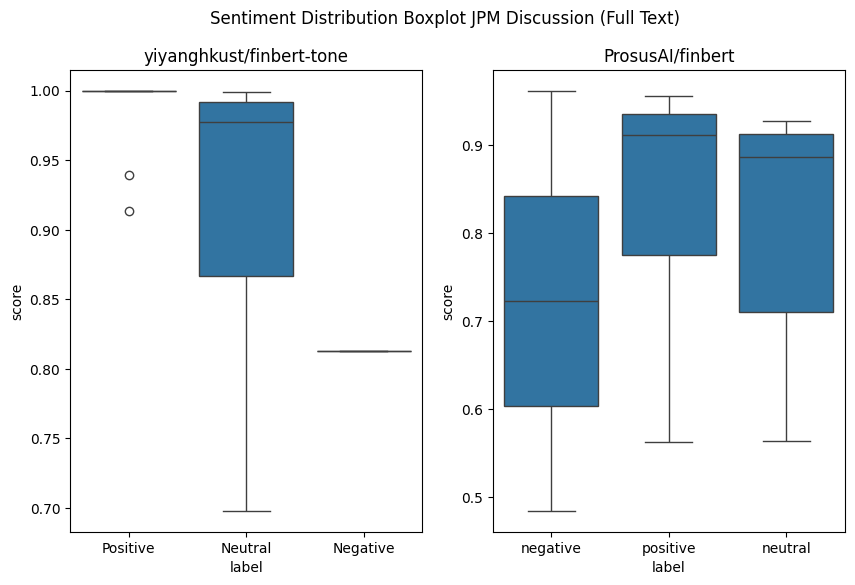

In [228]:
# Graph side by side boxplots
fig, ax = plt.subplots(1,2, figsize=(10, 6))

sns.boxplot(data=df_jpm_scored_md_kust, x="label", y="score", ax=ax[0])
sns.boxplot(data=df_jpm_scored_md_prosus, x="label", y="score", ax=ax[1])

ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")

plt.suptitle("Sentiment Distribution Boxplot JPM Discussion (Full Text)")


plt.show()

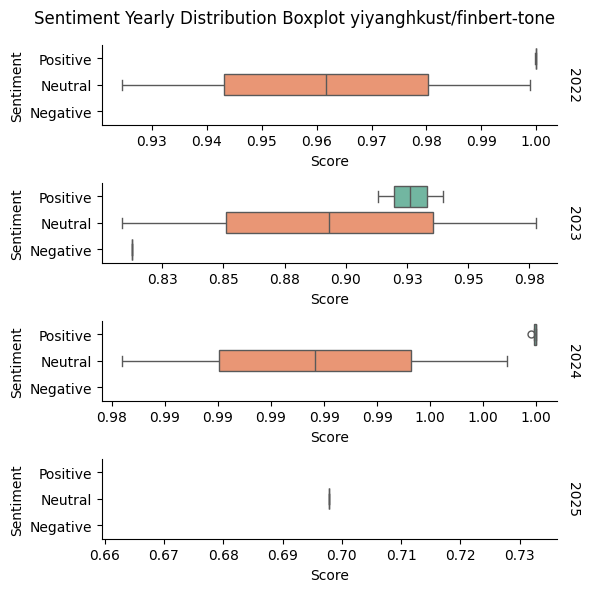

In [229]:
# Graph side by side boxplots of yearly distribution
g_1 = sns.catplot(
    data=df_jpm_scored_md_kust,
    x="score", y="label", row="year",
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.5, aspect=4,
    palette="Set2"
)
g_1.set(xlabel="Score", ylabel="Sentiment")
g_1.set_titles(row_template="{row_name}")
for ax in g_1.axes.flat:
    ax.xaxis.set_major_formatter('{x:.2f}')

plt.suptitle("Sentiment Yearly Distribution Boxplot yiyanghkust/finbert-tone")


plt.tight_layout()
plt.show()

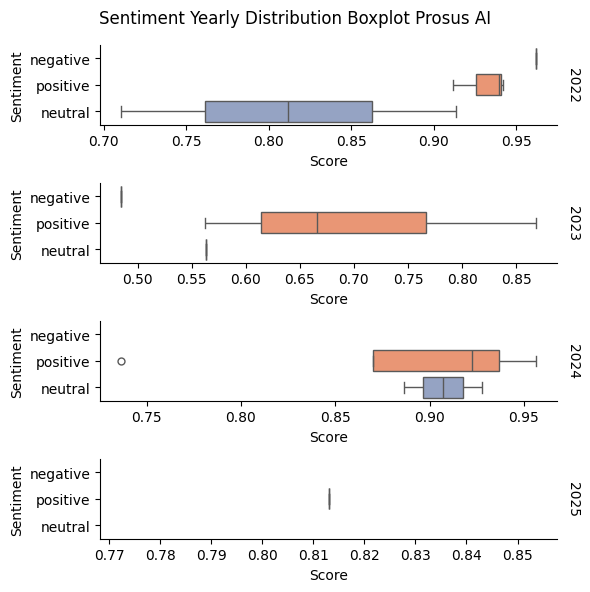

In [230]:
# Graph side by side boxplots of yearly distribution
g_2 = sns.catplot(
    data=df_jpm_scored_md_prosus,
    x="score", y="label", row="year",
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.5, aspect=4,
    palette="Set2"
)
g_2.set(xlabel="Score", ylabel="Sentiment")
g_2.set_titles(row_template="{row_name}")
for ax in g_2.axes.flat:
    ax.xaxis.set_major_formatter('{x:.2f}')

plt.suptitle("Sentiment Yearly Distribution Boxplot Prosus AI")


plt.tight_layout()
plt.show()

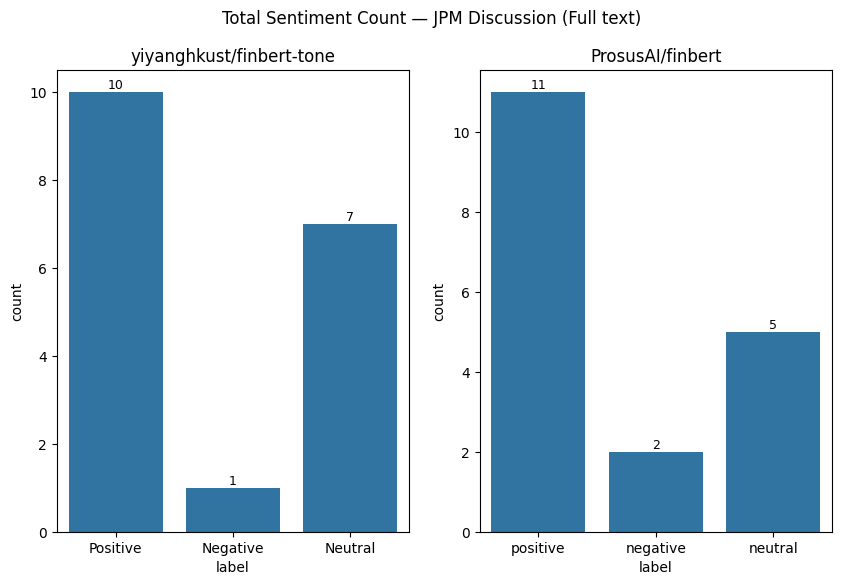

In [231]:
# Graph side by side distribution
fig, ax = plt.subplots(1,2, figsize=(10, 6))

# Order label

label_order_kust = ['Positive', 'Negative', 'Neutral']
label_order_prosus = ['positive', 'negative', 'neutral']


sns.countplot(data=df_jpm_scored_md_kust, x="label", order=label_order_kust , ax=ax[0])
sns.countplot(data=df_jpm_scored_md_prosus, x="label", order=label_order_prosus, ax=ax[1])

ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")

plt.suptitle("Total Sentiment Count — JPM Discussion (Full text)")

# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )


plt.show()

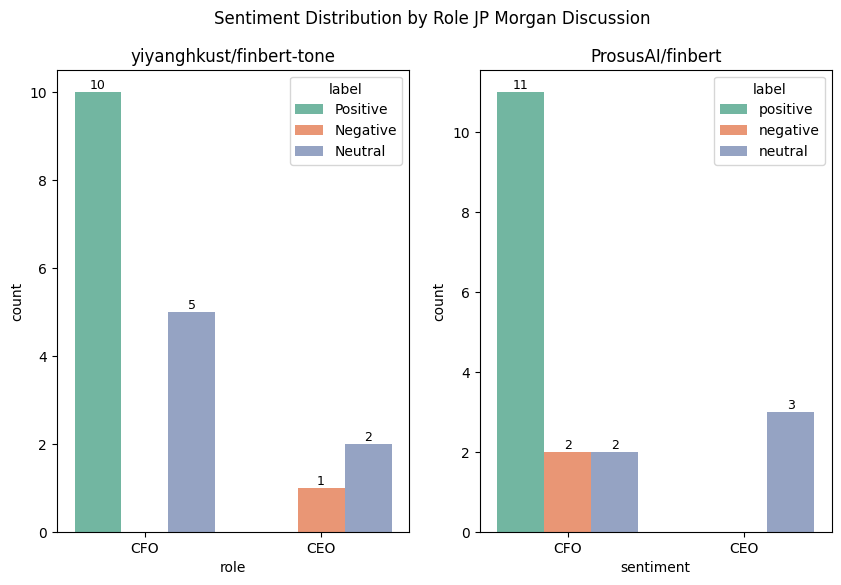

In [232]:
# Graph setiment distribution by role
fig, ax = plt.subplots(1,2, figsize=(10, 6))

# Order label
label_order_kust = ['Positive', 'Negative', 'Neutral']
label_order_prosus = ['positive', 'negative', 'neutral']

sns.countplot(df_jpm_scored_md_kust,
              x="role", hue="label",
              orient = 'h', hue_order=label_order_kust,
              palette="Set2", ax=ax[0])

sns.countplot(df_jpm_scored_md_prosus,
              x="role", hue="label",
              orient = 'h', hue_order=label_order_prosus,
              palette="Set2", ax=ax[1])

ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")

# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )



plt.suptitle("Sentiment Distribution by Role JP Morgan Discussion")
plt.xlabel("sentiment")
plt.ylabel("count")


plt.show()



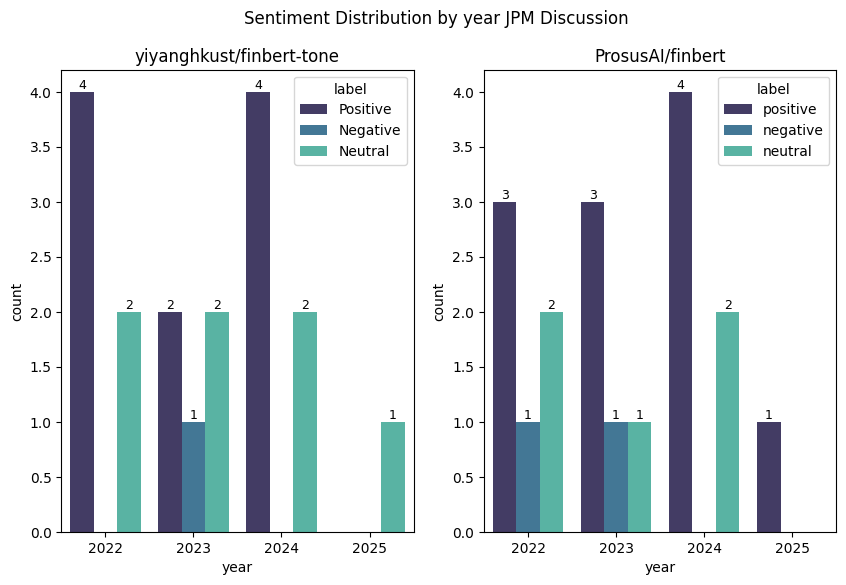

In [233]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))

# Order label
label_order_kust = ['Positive', 'Negative', 'Neutral']
label_order_prosus = ['positive', 'negative', 'neutral']

sns.countplot(df_jpm_scored_md_kust, x="year",
              hue="label", hue_order=label_order_kust, palette = 'mako' ,ax=ax[0])
sns.countplot(df_jpm_scored_md_prosus, x="year",
              hue="label", hue_order=label_order_prosus, palette ='mako', ax=ax[1])
ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")

# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )


plt.suptitle("Sentiment Distribution by year JPM Discussion")
plt.show()

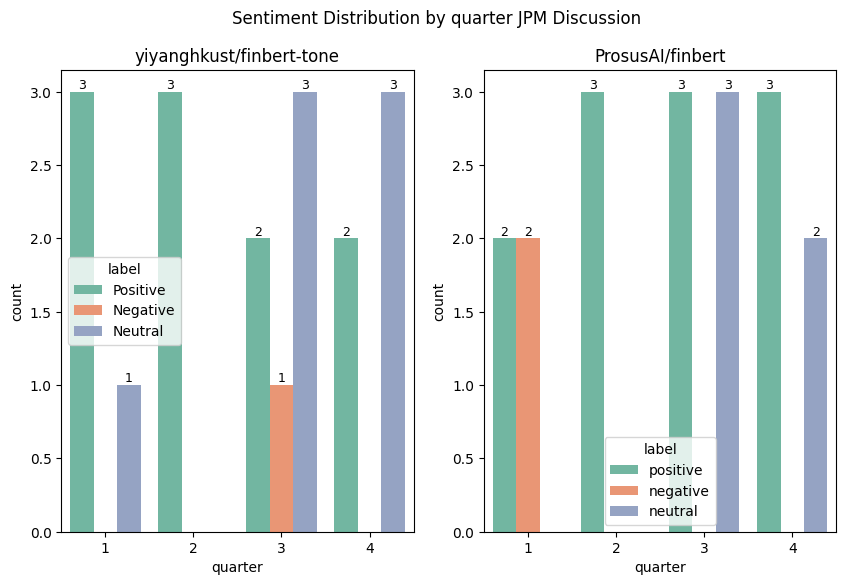

In [234]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))

# Order label
label_order_kust = ['Positive', 'Negative', 'Neutral']
label_order_prosus = ['positive', 'negative', 'neutral']

sns.countplot(df_jpm_scored_md_kust, x="quarter",
              hue = 'label', hue_order=label_order_kust ,palette ='Set2', ax=ax[0])

sns.countplot(df_jpm_scored_md_prosus, x="quarter",
              hue = 'label',hue_order=label_order_prosus ,palette ='Set2', ax=ax[1])
ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")


# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )



plt.suptitle("Sentiment Distribution by quarter JPM Discussion")
plt.show()

#### Q & A

The visualizations below present a detailed comparative sentiment analysis of JP Morgan's Q&A sessions.

* Both models predominantly classify content as neutral, though yiyanghkust shows a slightly higher proportion of positive and negative sentiments compared to ProsusAI.

* Boxplots reveal that yiyanghkust produces high-confidence sentiment scores across all labels, while ProsusAI displays greater variability, especially for negative and neutral classifications.

* Quarterly and yearly breakdowns consistently show neutral sentiment dominance across time periods, with Q1 being the most sentiment-rich quarter.

* Role-based distributions indicate analysts contribute the most to overall sentiment volume, followed by CFOs and CEOs, with neutral sentiment again prevailing across roles.

* Finally, sentiment distribution by content type shows that both models assign higher neutral sentiment to answers than questions, with yiyanghkust identifying a higher frequency of positive responses.

These findings suggest yiyanghkust tends to produce more confident and optimistic sentiment classifications, whereas ProsusAI offers a more balanced, albeit less confident, interpretation of the Q&A discourse.

In [235]:
df_jpm_q_and_a.head()

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter,content_type
0,0,1,John McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1,question
1,1,1,Jeremy Barnum,CFO,JP Morgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1,answer
2,2,1,John McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1,question
3,3,1,Jeremy Barnum,CFO,JP Morgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1,answer
4,4,1,John McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1,question


In [236]:
df_jpm_q_and_a

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter,content_type
0,0,1,John McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1,question
1,1,1,Jeremy Barnum,CFO,JP Morgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1,answer
2,2,1,John McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1,question
3,3,1,Jeremy Barnum,CFO,JP Morgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1,answer
4,4,1,John McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1,question
...,...,...,...,...,...,...,...,...,...
1091,1,13,Jeremy Barnum,CFO,JP Morgan Chase & Co.,Yeah. So you've slightly answered your own que...,2025,1,answer
1092,2,13,Jamie Dimon,CEO,JP Morgan Chase & Co.,Can I just add a management thing that I think...,2025,1,answer
1093,3,13,Saul Martinez,Analyst,Inc.,Okay. That's very clear. Very helpful. Thank you.,2025,1,question
1094,4,13,Jeremy Barnum,CFO,JP Morgan Chase & Co.,Okay. Thanks very much.,2025,1,answer


In [237]:
df_scored_qa_jpm_kust = score_m_d(df_jpm_q_and_a, MODEL_NAME_1)
df_scored_qa_jpm_kust.head()

Device set to use cuda:0


,question_order,question_answer_group_id,speaker,role,company,content,year,quarter,content_type,score,label
0,0,1,John McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1,question,0.998946,Neutral
1,1,1,Jeremy Barnum,CFO,JP Morgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1,answer,0.999564,Neutral
2,2,1,John McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1,question,0.999603,Neutral
3,3,1,Jeremy Barnum,CFO,JP Morgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1,answer,0.510577,Negative
4,4,1,John McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1,question,0.981848,Neutral


In [239]:
df_scored_qa_jpm_prosus = score_m_d(df_jpm_q_and_a, MODEL_NAME_2)
df_scored_qa_jpm_prosus.head()

Device set to use cuda:0


,question_order,question_answer_group_id,speaker,role,company,content,year,quarter,content_type,score,label
0,0,1,John McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1,question,0.898968,neutral
1,1,1,Jeremy Barnum,CFO,JP Morgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1,answer,0.898763,neutral
2,2,1,John McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1,question,0.933247,neutral
3,3,1,Jeremy Barnum,CFO,JP Morgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1,answer,0.740847,neutral
4,4,1,John McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1,question,0.631650,neutral


##### Comparison Graphs

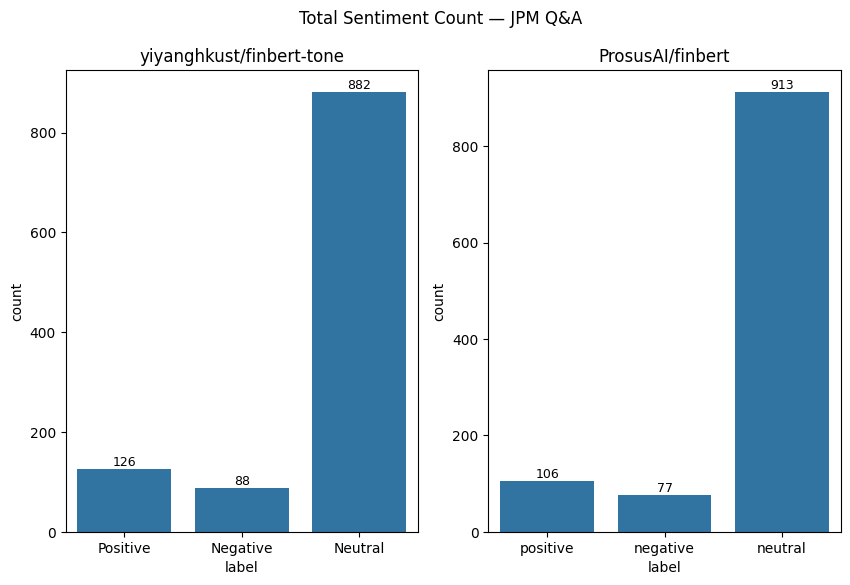

In [241]:
# Graph side by side distribution
fig, ax = plt.subplots(1,2, figsize=(10, 6))

# Order label
label_order_kust = ['Positive', 'Negative', 'Neutral']
label_order_prosus = ['positive', 'negative', 'neutral']

sns.countplot(data= df_scored_qa_jpm_kust,
              x="label",
              order=label_order_kust,
              ax=ax[0])
sns.countplot(data= df_scored_qa_jpm_prosus,
              x="label",
              order=label_order_prosus,
              ax=ax[1])

ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")

# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.suptitle("Total Sentiment Count — JPM Q&A")
plt.show()

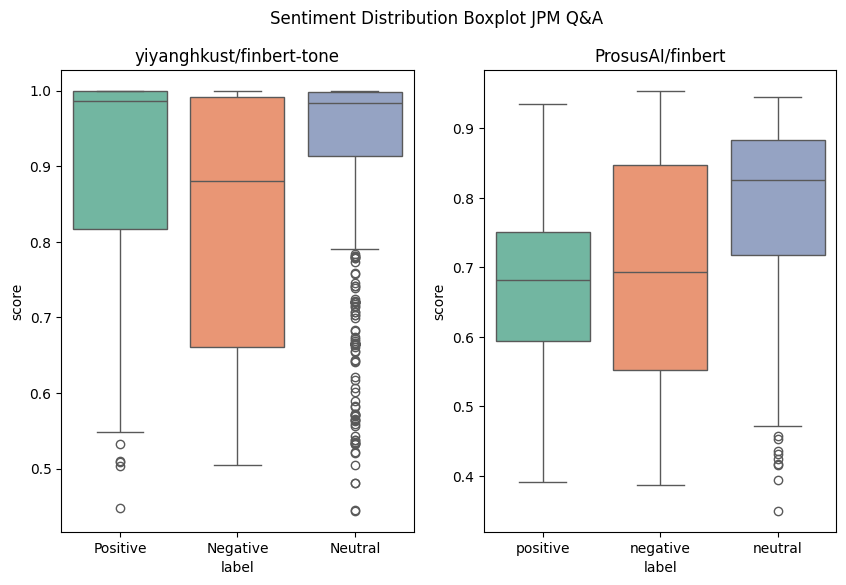

In [242]:
# Graph side by side boxplots
fig, ax = plt.subplots(1,2, figsize=(10, 6))

# Order label
label_order_kust = ['Positive', 'Negative', 'Neutral']
label_order_prosus = ['positive', 'negative', 'neutral']

sns.boxplot(data=df_scored_qa_jpm_kust,
            x="label",
            y="score", order=label_order_kust ,palette = 'Set2',  ax=ax[0])

sns.boxplot(data=df_scored_qa_jpm_prosus, x="label",
            y="score", palette ='Set2', order= label_order_prosus  , ax=ax[1])

ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")


plt.suptitle("Sentiment Distribution Boxplot JPM Q&A")
plt.show()

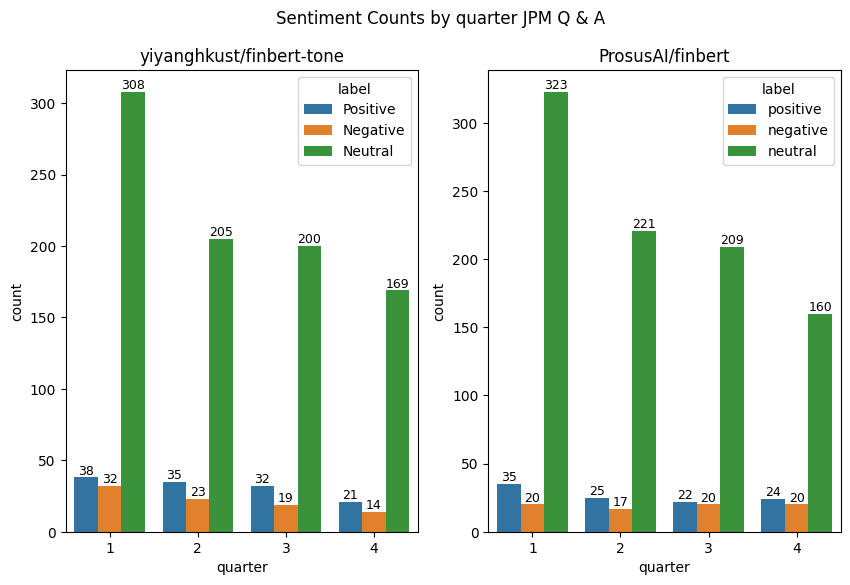

In [243]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))

# Order label
label_order_kust = ['Positive', 'Negative', 'Neutral']
label_order_prosus = ['positive', 'negative', 'neutral']

sns.countplot(df_scored_qa_jpm_kust,
              x="quarter",
              hue = 'label',
              hue_order=label_order_kust,
              ax=ax[0])
sns.countplot(df_scored_qa_jpm_prosus,
              x="quarter",
              hue = 'label',
              hue_order=label_order_prosus,
              ax=ax[1])

ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")

# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.suptitle("Sentiment Counts by quarter JPM Q & A")
plt.show()

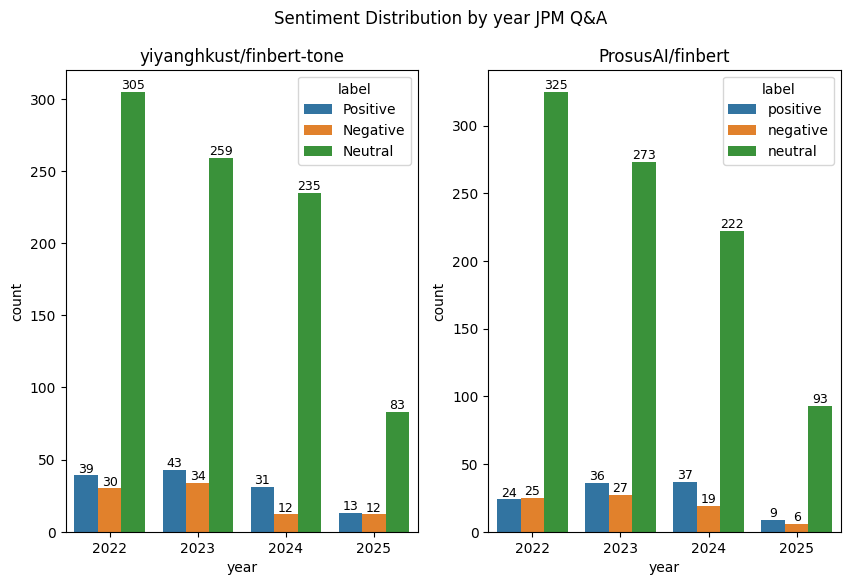

In [244]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))

# Order label
label_order_kust = ['Positive', 'Negative', 'Neutral']
label_order_prosus = ['positive', 'negative', 'neutral']

sns.countplot(df_scored_qa_jpm_kust,
              x="year",
              hue = 'label',
              hue_order = label_order_kust,
              ax=ax[0])
sns.countplot(df_scored_qa_jpm_prosus,
              x="year",
              hue = 'label',
              hue_order = label_order_prosus,
              ax=ax[1])

ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")

# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.suptitle("Sentiment Distribution by year JPM Q&A")
plt.show()

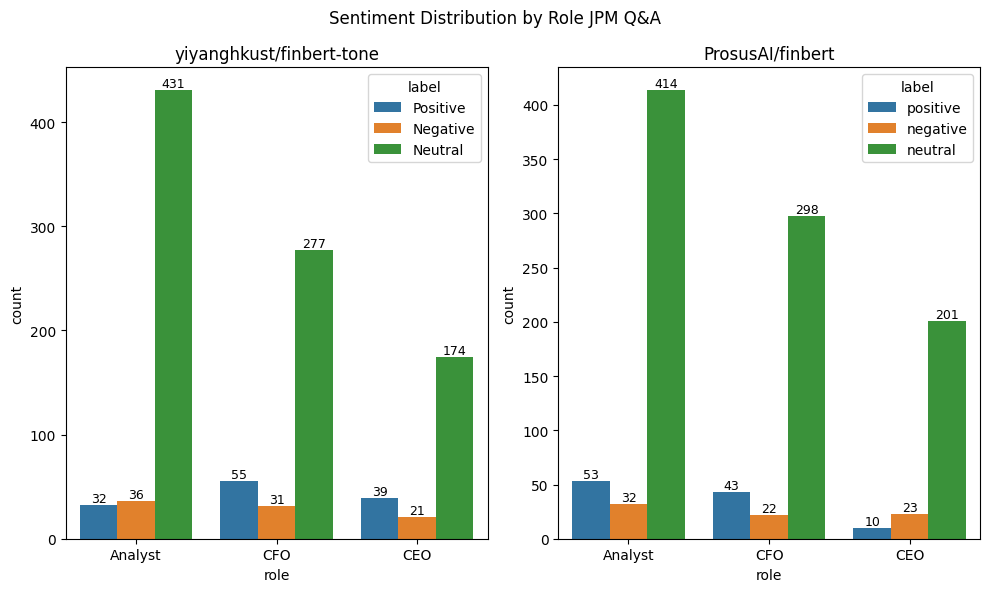

In [245]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))

# Order label
label_order_kust = ['Positive', 'Negative', 'Neutral']
label_order_prosus = ['positive', 'negative', 'neutral']

sns.countplot(df_scored_qa_jpm_kust,
              x="role",
              hue = 'label',
              hue_order = label_order_kust,
              ax=ax[0])
sns.countplot(df_scored_qa_jpm_prosus,
              x="role",
              hue = 'label',
              hue_order = label_order_prosus,
              ax=ax[1])
ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")

# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )


plt.suptitle("Sentiment Distribution by Role JPM Q&A")
plt.tight_layout()
plt.show()


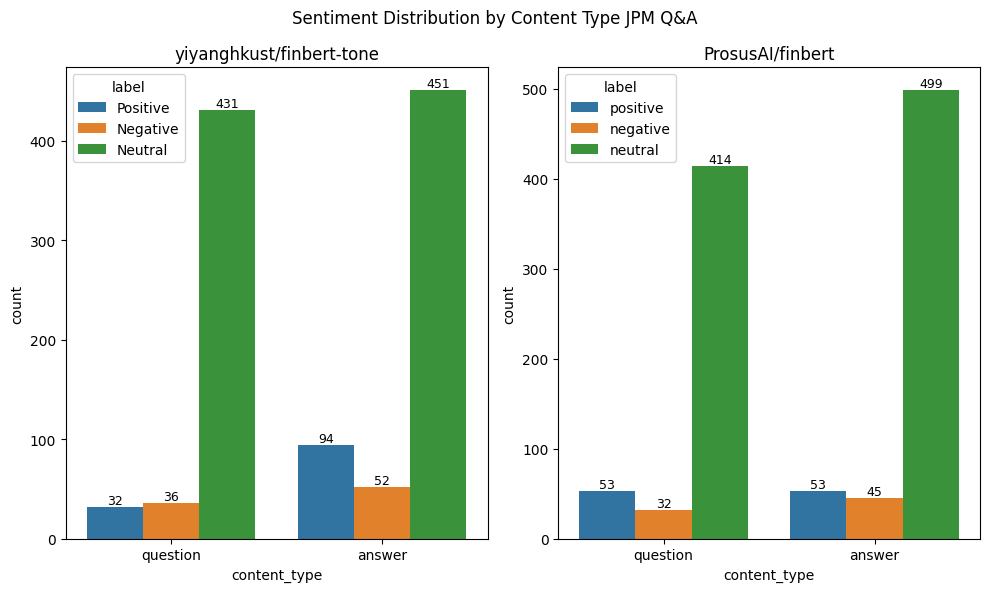

In [246]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))

# Order label
label_order_kust = ['Positive', 'Negative', 'Neutral']
label_order_prosus = ['positive', 'negative', 'neutral']

sns.countplot(df_scored_qa_jpm_kust,
              x="content_type",
              hue = 'label',
              hue_order = label_order_kust,
              ax=ax[0])
sns.countplot(df_scored_qa_jpm_prosus,
              x="content_type",
              hue = 'label',
              hue_order = label_order_prosus,
              ax=ax[1])
ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")

# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )


plt.suptitle("Sentiment Distribution by Content Type JPM Q&A")
plt.tight_layout()
plt.show()


### Goldman Sachs — Full Text

#### Management Discussion

The visualizations below compare sentiment classifications from yiyanghkust/finbert-tone and ProsusAI/finbert models on Goldman Sachs discussions, examining distribution by sentiment, year, role, and quarter.

* Overall, yiyanghkust yields extremely high confidence scores with minimal variance, especially for positive sentiments, whereas ProsusAI shows a wider score distribution across sentiment categories.

* Yearly breakdowns confirm that yiyanghkust maintains near-perfect (close to 1) sentiment confidence over time, while ProsusAI displays notable variation and more balanced sentiment allocations.

* In terms of sentiment count, both models identify a dominant positive tone, but ProsusAI attributes a higher proportion of negative and neutral labels than yiyanghkust.

* Role-based sentiment analysis highlights that the CEO and CFO are the primary contributors to positive sentiment across both models, while HIRs (Head of Investor Relations) are predominantly associated with neutral statements.

* Sentiment distribution across years and quarters remains relatively stable for both models, though ProsusAI reveals more fluctuations across time, suggesting a more sensitive and nuanced sentiment interpretation.

In [247]:
# yiyanghkust/finbert-tone
df_gs_scored_md_kust = score_m_d(df_gs_discussion,MODEL_NAME_1)
df_gs_scored_md_kust.head()

Device set to use cuda:0


,speaker,role,company,content,quarter,year,score,label
0,Carey Halio,HIR,Goldman Sachs,"Good morning. This is Carey Halio, Head of In...",1,2022,0.999968,Neutral
1,David Solomon,CEO,Goldman Sachs,"Thanks, Carey . Good morning, everyone. Thank...",1,2022,0.999982,Positive
2,Denis Coleman,CFO,Goldman Sachs,"Thank you, David. Good morning. Let's start w...",1,2022,1.000000,Positive
3,Carey Halio,HIR,Goldman Sachs,"Good morning. This is Carey Halio, Head of In...",2,2022,0.999969,Neutral
4,David Solomon,CEO,Goldman Sachs,"Thanks, Carey and good morning everybody . Th...",2,2022,0.999972,Positive


In [248]:
# ProsusAI/finbert
df_gs_scored_md_prosus = score_m_d(df_gs_discussion,MODEL_NAME_2)
df_gs_scored_md_prosus.head()

Device set to use cuda:0


,speaker,role,company,content,quarter,year,score,label
0,Carey Halio,HIR,Goldman Sachs,"Good morning. This is Carey Halio, Head of In...",1,2022,0.949527,neutral
1,David Solomon,CEO,Goldman Sachs,"Thanks, Carey . Good morning, everyone. Thank...",1,2022,0.890292,positive
2,Denis Coleman,CFO,Goldman Sachs,"Thank you, David. Good morning. Let's start w...",1,2022,0.862455,positive
3,Carey Halio,HIR,Goldman Sachs,"Good morning. This is Carey Halio, Head of In...",2,2022,0.948234,neutral
4,David Solomon,CEO,Goldman Sachs,"Thanks, Carey and good morning everybody . Th...",2,2022,0.568493,positive


##### Comparison Graphs

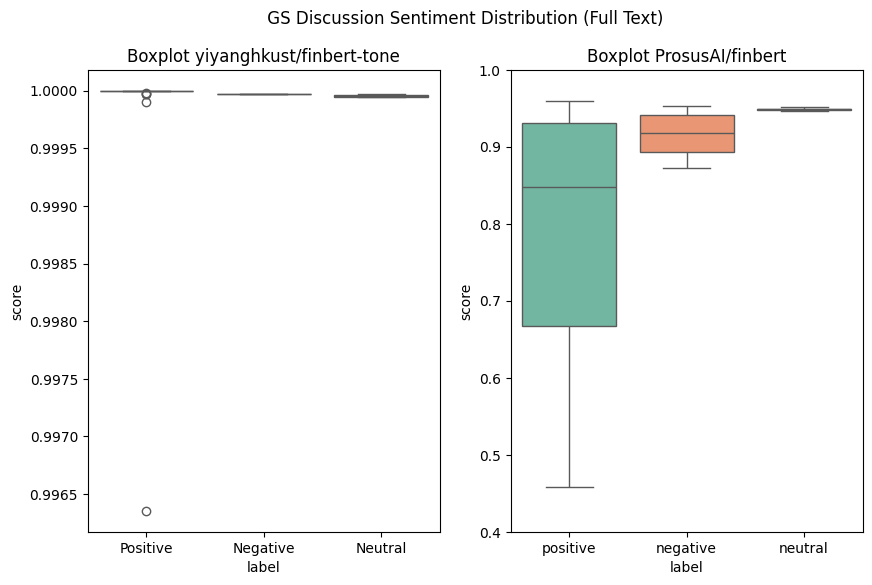

In [249]:
# Graph side by side boxplots
fig, ax = plt.subplots(1,2, figsize=(10, 6))

# Order label
label_order_kust = ['Positive', 'Negative', 'Neutral']
label_order_prosus = ['positive', 'negative', 'neutral']

sns.boxplot(data=df_gs_scored_md_kust,
            x="label",
            y="score",
            order=label_order_kust,
            palette = 'Set2',
            ax=ax[0])
sns.boxplot(data=df_gs_scored_md_prosus,
            x="label",
            y="score",
            order=label_order_prosus,
            palette ='Set2',
            ax=ax[1])

ax[0].set_title("Boxplot yiyanghkust/finbert-tone")
ax[1].set_title("Boxplot ProsusAI/finbert")

ax[0].set_ylim()
ax[1].set_ylim(0.4, 1)

plt.suptitle(" GS Discussion Sentiment Distribution (Full Text)")
plt.show()

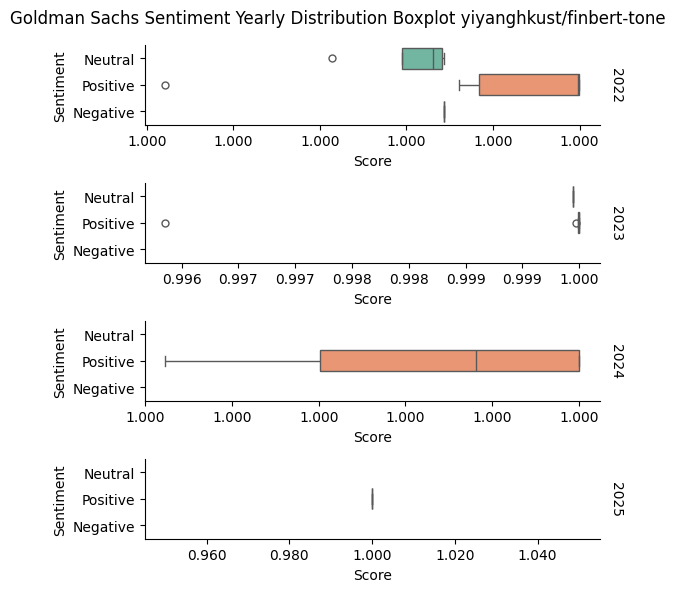

In [250]:
# Graph side by side boxplots of yearly distribution
g_1 = sns.catplot(
    data=df_gs_scored_md_kust,
    x="score", y="label", row="year",
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.5, aspect=4,
    palette="Set2"
)
g_1.set(xlabel="Score", ylabel="Sentiment")
g_1.set_titles(row_template="{row_name}")

# Set x-axis limits for consistency
for ax in g_1.axes.flat:
    ax.set_xlim()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))

# Adjust title and layout
plt.subplots_adjust(top=0.9)
plt.suptitle("Goldman Sachs Sentiment Yearly Distribution Boxplot yiyanghkust/finbert-tone")


plt.tight_layout()
plt.show()

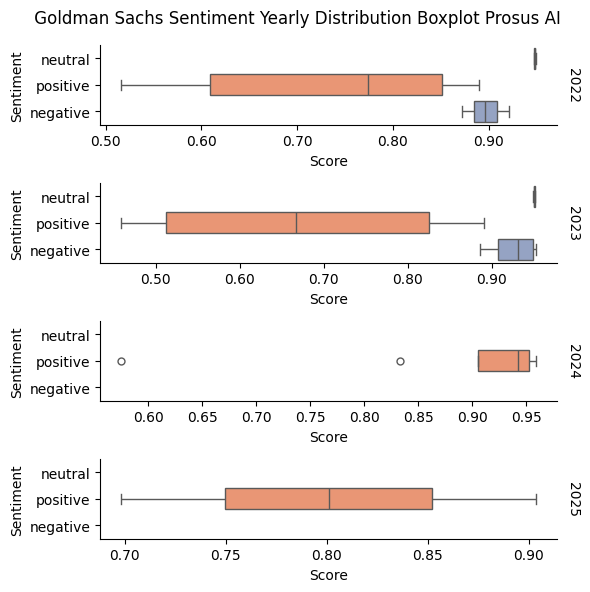

In [251]:
# Graph side by side boxplots of yearly distribution
g_2 = sns.catplot(
    data=df_gs_scored_md_prosus,
    x="score", y="label", row="year",
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.5, aspect=4,
    palette="Set2"
)
g_2.set(xlabel="Score", ylabel="Sentiment")
g_2.set_titles(row_template="{row_name}")
for ax in g_2.axes.flat:

    ax.xaxis.set_major_formatter('{x:.2f}')

plt.suptitle(" Goldman Sachs Sentiment Yearly Distribution Boxplot Prosus AI")


plt.tight_layout()
plt.show()

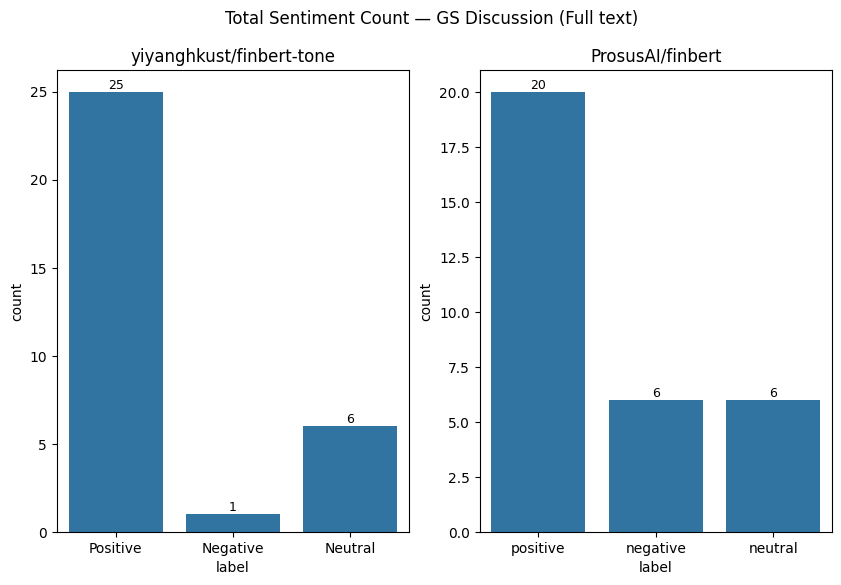

In [252]:
# Graph side by side distribution
fig, ax = plt.subplots(1,2, figsize=(10, 6))

# Order label
label_order_kust = ['Positive', 'Negative', 'Neutral']
label_order_prosus = ['positive', 'negative', 'neutral']

sns.countplot(data=df_gs_scored_md_kust,
              x="label",
              order=label_order_kust,
              ax=ax[0])
sns.countplot(data=df_gs_scored_md_prosus,
              x="label",
              order=label_order_prosus,
              ax=ax[1])

ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")

# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.suptitle("Total Sentiment Count — GS Discussion (Full text)")

plt.show()

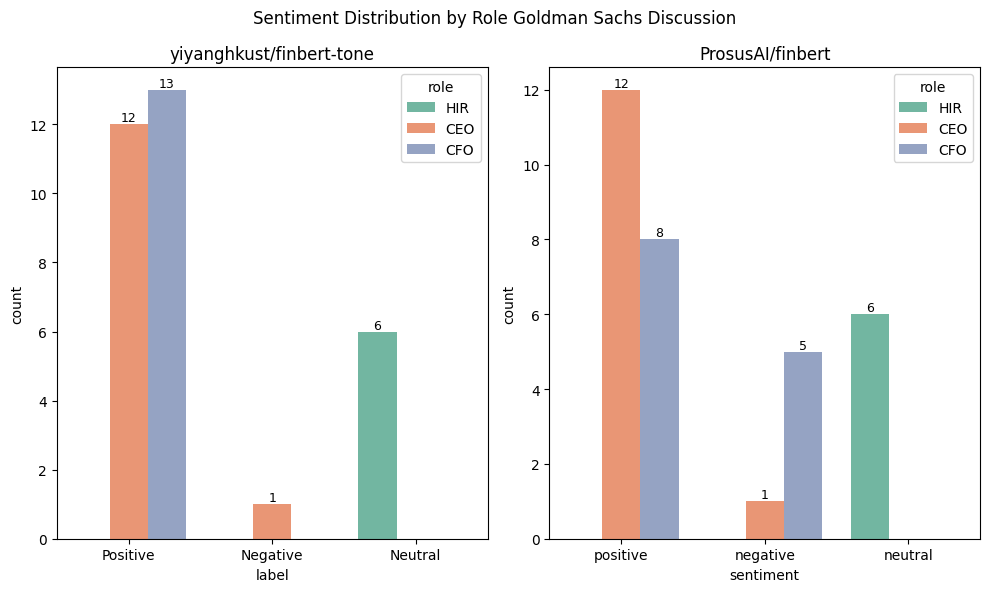

In [253]:
# Graph setiment distribution by role
fig, ax = plt.subplots(1,2, figsize=(10, 6))

# Order label
label_order_kust = ['Positive', 'Negative', 'Neutral']
label_order_prosus = ['positive', 'negative', 'neutral']

sns.countplot(df_gs_scored_md_kust,
              x="label", hue="role",
              order=label_order_kust,
              orient = 'h', palette="Set2", ax=ax[0])

sns.countplot(df_gs_scored_md_prosus,
              x="label", hue="role",
              order=label_order_prosus,
              orient = 'h', palette="Set2", ax=ax[1])

ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")


plt.suptitle("Sentiment Distribution by Role Goldman Sachs Discussion")
plt.xlabel("sentiment")
plt.ylabel("count")

# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height ,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.tight_layout()
plt.show()



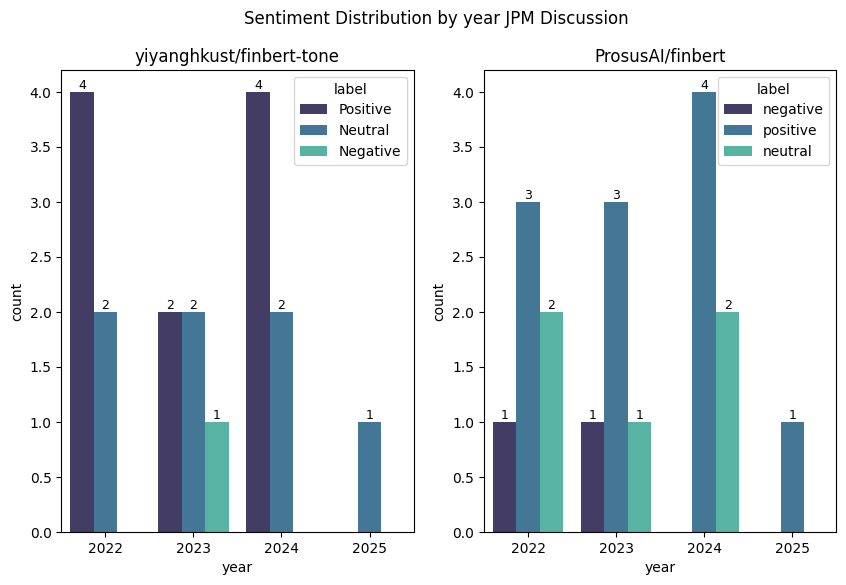

In [254]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))
sns.countplot(df_jpm_scored_md_kust, x="year",
              hue="label", palette = 'mako' ,ax=ax[0])
sns.countplot(df_jpm_scored_md_prosus, x="year",
              hue="label", palette ='mako', ax=ax[1])
ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")

# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )
plt.suptitle("Sentiment Distribution by year JPM Discussion")
plt.show()

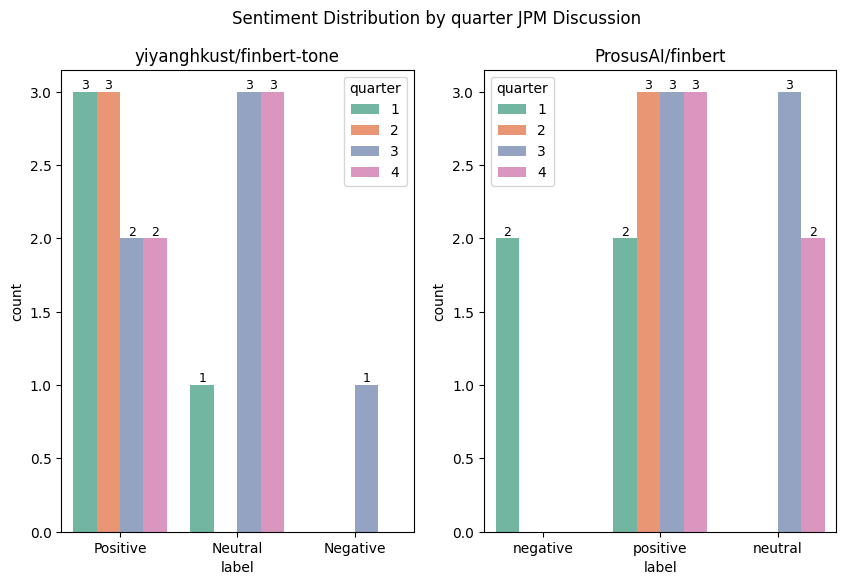

In [255]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))

sns.countplot(df_jpm_scored_md_kust, x="label",
              hue = 'quarter',palette ='Set2', ax=ax[0])

sns.countplot(df_jpm_scored_md_prosus, x="label",
              hue = 'quarter',palette ='Set2', ax=ax[1])
ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")

# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )


plt.suptitle("Sentiment Distribution by quarter JPM Discussion")
plt.show()

#### Q & A

The visualizations present a comprehensive sentiment analysis of Goldman Sachs Q&A sessions.

* Both models identify neutral sentiment as the dominant category, though yiyanghkust consistently produces higher confidence scores, especially for positive and neutral sentiments, while ProsusAI demonstrates broader variability across all sentiment labels.

* Sentiment distributions by year, quarter, role, and content type reveal stable patterns over time, with Q1 typically registering the highest volume of statements.

* Role-based sentiment analysis shows analysts contribute the most content, with CEOs and CFOs generating the bulk of positive sentiment.

* Content-type breakdowns indicate that questions tend to be more neutral, whereas answers contain a greater share of positive sentiment, particularly in the yiyanghkust results.

* Year-over-year and quarter-per-year charts further reinforce consistent trends, with ProsusAI offering a more balanced sentiment classification, while yiyanghkust tends to assign high-confidence scores and shows stronger optimism in financial communication.

In [256]:
df_gs_q_and_a.head()

,question_order,question_answer_group_id,speaker,role,company,content_type,content,quarter,year
0,0,0,Glenn Schorr,Analyst,Evercore,question,"so, trading question, i mean, markets busines...",3,2024
1,1,0,David Solomon,CEO,Goldman Sachs,answer,"i appreciate the question, glenn, and i mean,...",3,2024
2,2,0,Glenn Schorr,Analyst,Evercore,question,i appreciate that. this one will be a short f...,3,2024
3,3,0,Denis Coleman,CFO,Goldman Sachs,answer,"glenn, its denis. i guess what i would sugges...",3,2024
4,0,1,Ebrahim Poonawala,Analyst,Bank of America,question,i just had a follow-up ﬁrst on trading and ma...,3,2024


In [257]:
df_gs_q_and_a

,question_order,question_answer_group_id,speaker,role,company,content_type,content,quarter,year
0,0,0,Glenn Schorr,Analyst,Evercore,question,"so, trading question, i mean, markets busines...",3,2024
1,1,0,David Solomon,CEO,Goldman Sachs,answer,"i appreciate the question, glenn, and i mean,...",3,2024
2,2,0,Glenn Schorr,Analyst,Evercore,question,i appreciate that. this one will be a short f...,3,2024
3,3,0,Denis Coleman,CFO,Goldman Sachs,answer,"glenn, its denis. i guess what i would sugges...",3,2024
4,0,1,Ebrahim Poonawala,Analyst,Bank of America,question,i just had a follow-up ﬁrst on trading and ma...,3,2024
...,...,...,...,...,...,...,...,...,...
706,1,11,Denis Coleman,CFO,Goldman Sachs,answer,sure. thank you for that. in terms of a quart...,3,2022
707,2,11,Jeremy Sigee,Analyst,BNP Paribas,question,very clear . and then a separate follow-up ju...,3,2022
708,3,11,David Solomon,CEO,Goldman Sachs,answer,"so i appreciate the question, jeremy . i mean...",3,2022
709,0,12,Mike Mayo,Analyst,Wells Fargo,question,i guess the word for the quarter is resilienc...,3,2022


In [258]:
df_scored_qa_gs_kust = score_m_d(df_gs_q_and_a, MODEL_NAME_1)
df_scored_qa_gs_kust.head()


Device set to use cuda:0


,question_order,question_answer_group_id,speaker,role,company,content_type,content,quarter,year,score,label
0,0,0,Glenn Schorr,Analyst,Evercore,question,"hi. thanks very much. so, i appreciate the $1...",1,2022,0.993975,Neutral
1,1,0,Denis Coleman,CFO,Goldman Sachs,answer,"so glenn, it's denis. thank you. thank you fo...",1,2022,0.999999,Positive
2,2,0,Glenn Schorr,Analyst,Evercore,question,okay . i appreciate that it's working so far ...,1,2022,0.936624,Neutral
3,3,0,David Solomon,CEO,Goldman Sachs,answer,"sure, glenn, it's david. and i'll jump in her...",1,2022,0.998957,Positive
4,0,1,Christian Bolu,Analyst,Autonomous Research,question,good morning. so overall rote of 16% was pret...,1,2022,0.999954,Positive


In [259]:
df_scored_qa_gs_kust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   question_order            711 non-null    int64  
 1   question_answer_group_id  711 non-null    int64  
 2   speaker                   711 non-null    object 
 3   role                      711 non-null    object 
 4   company                   711 non-null    object 
 5   content_type              711 non-null    object 
 6   content                   711 non-null    object 
 7   quarter                   711 non-null    int64  
 8   year                      711 non-null    int64  
 9   score                     711 non-null    float64
 10  label                     711 non-null    object 
dtypes: float64(1), int64(4), object(6)
memory usage: 61.2+ KB


In [261]:
df_scored_qa_gs_prosus = score_m_d(df_gs_q_and_a, MODEL_NAME_2)
df_scored_qa_gs_prosus.head()

Device set to use cuda:0


,question_order,question_answer_group_id,speaker,role,company,content_type,content,quarter,year,score,label
0,0,0,Glenn Schorr,Analyst,Evercore,question,"hi. thanks very much. so, i appreciate the $1...",1,2022,0.814950,neutral
1,1,0,Denis Coleman,CFO,Goldman Sachs,answer,"so glenn, it's denis. thank you. thank you fo...",1,2022,0.755499,positive
2,2,0,Glenn Schorr,Analyst,Evercore,question,okay . i appreciate that it's working so far ...,1,2022,0.716402,positive
3,3,0,David Solomon,CEO,Goldman Sachs,answer,"sure, glenn, it's david. and i'll jump in her...",1,2022,0.742820,neutral
4,0,1,Christian Bolu,Analyst,Autonomous Research,question,good morning. so overall rote of 16% was pret...,1,2022,0.759425,neutral


##### Comparison Graphs

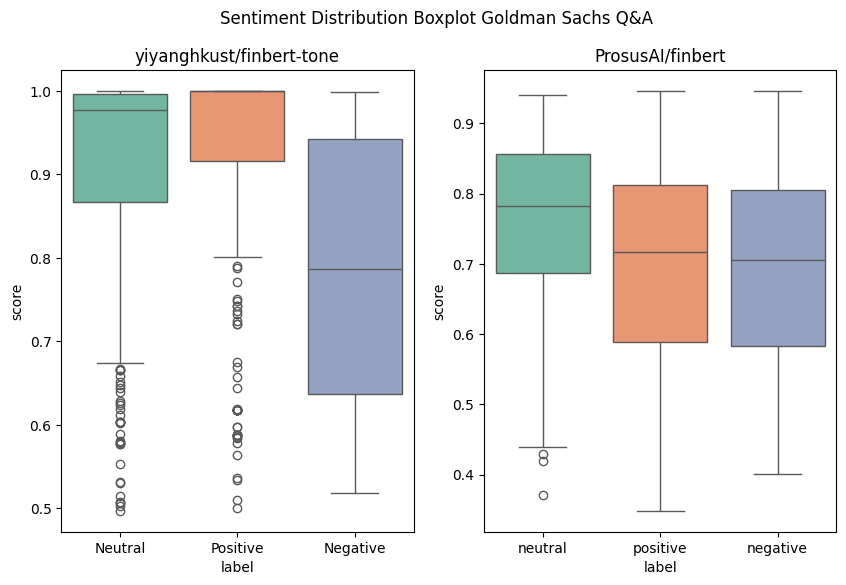

In [263]:
# Graph side by side boxplots
fig, ax = plt.subplots(1,2, figsize=(10, 6))

sns.boxplot(data=df_scored_qa_gs_kust,
            x="label",
            y="score", palette = 'Set2',  ax=ax[0])
sns.boxplot(data=df_scored_qa_gs_prosus, x="label",
            y="score", palette ='Set2', ax=ax[1])

ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")


plt.suptitle("Sentiment Distribution Boxplot Goldman Sachs Q&A")
plt.show()

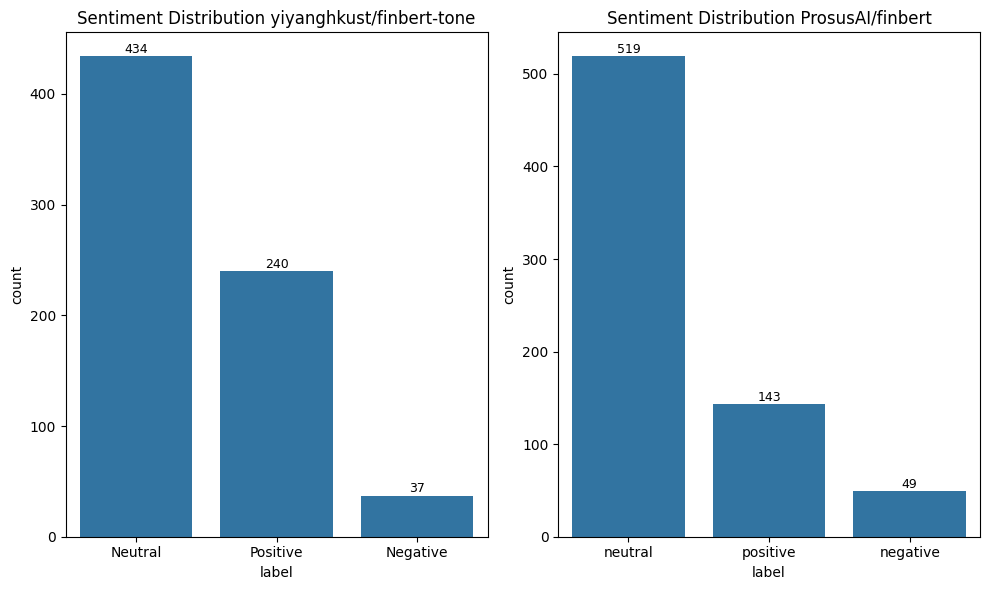

In [264]:
# Graph side by side distribution
fig, ax = plt.subplots(1,2, figsize=(10, 6))

sns.countplot(data= df_scored_qa_gs_kust, x="label", ax=ax[0])
sns.countplot(data= df_scored_qa_gs_prosus, x="label", ax=ax[1])

ax[0].set_title("Sentiment Distribution yiyanghkust/finbert-tone")
ax[1].set_title("Sentiment Distribution ProsusAI/finbert")

# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height + 0.5,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.tight_layout()
plt.show()

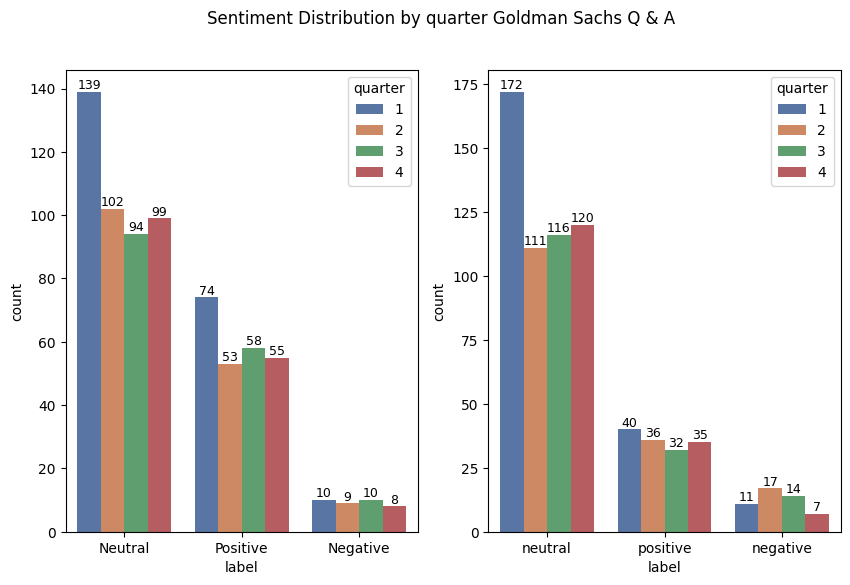

In [265]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))
sns.countplot(df_scored_qa_gs_kust, x="label", hue = 'quarter', ax=ax[0], palette='deep')
sns.countplot(df_scored_qa_gs_prosus, x="label", hue = 'quarter', ax=ax[1], palette='deep')
plt.suptitle("Sentiment Distribution by quarter Goldman Sachs Q & A")

# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )
plt.show()

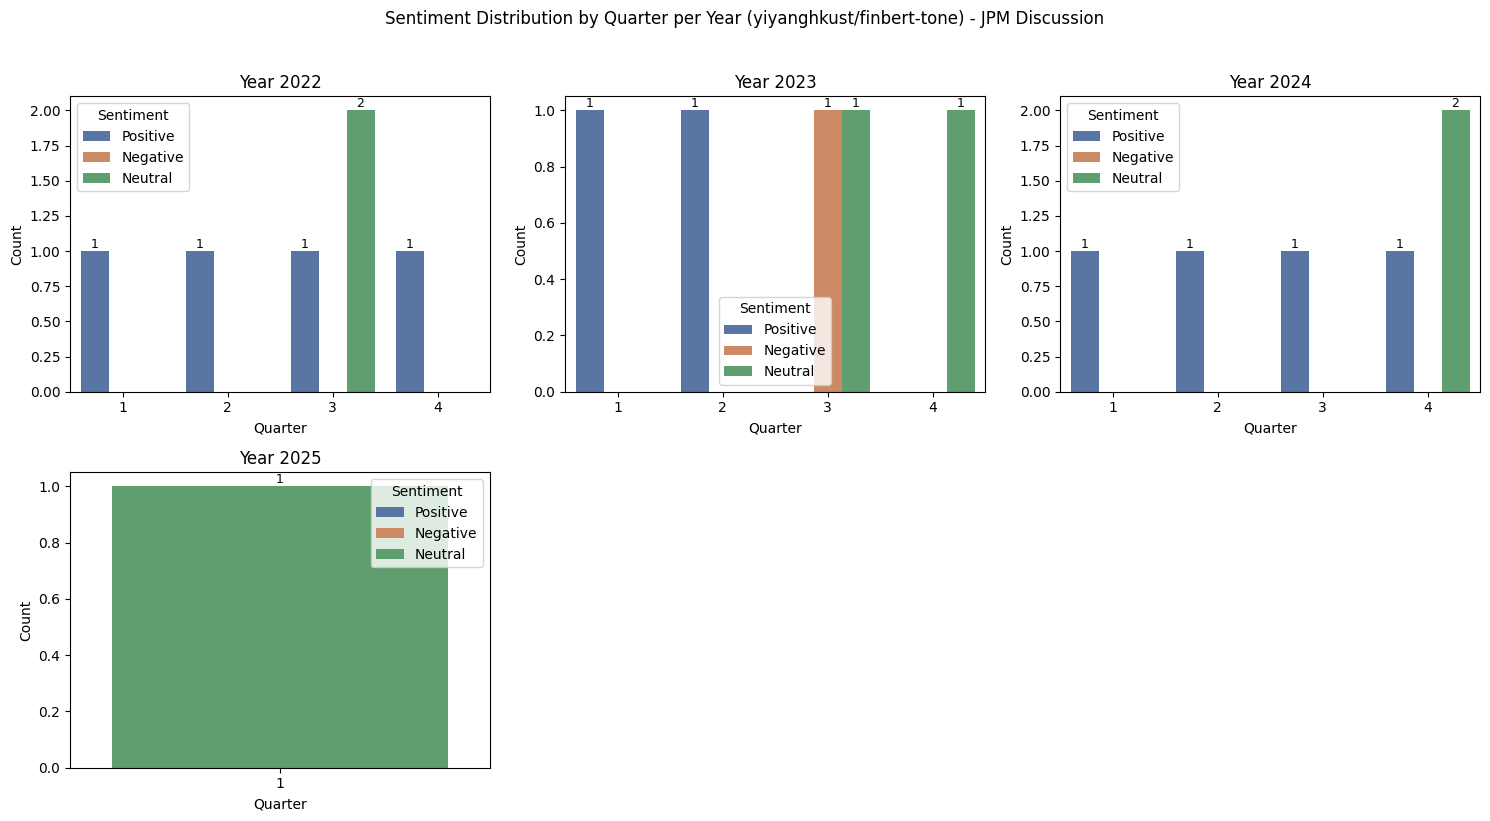

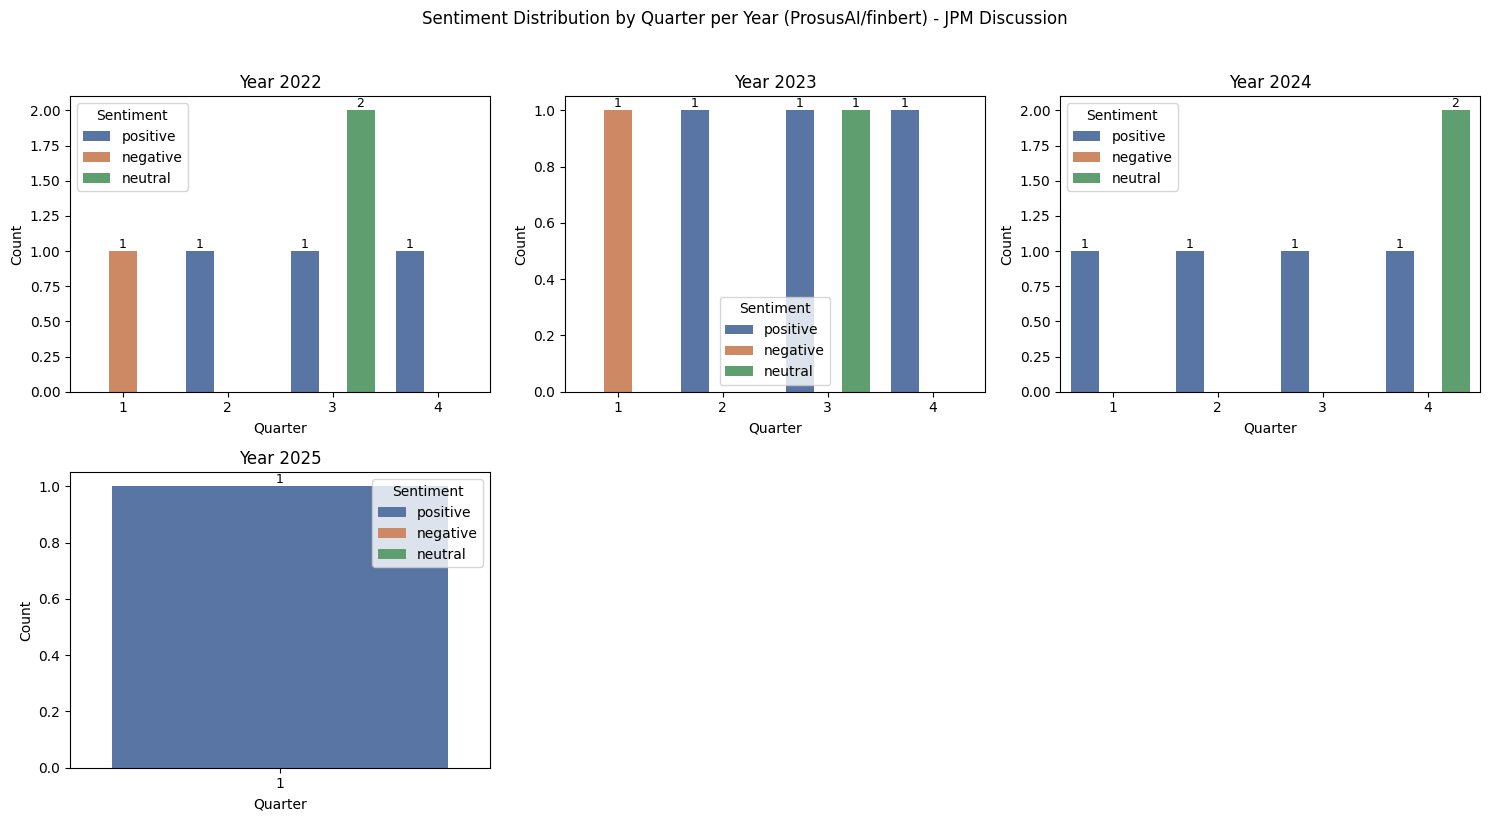

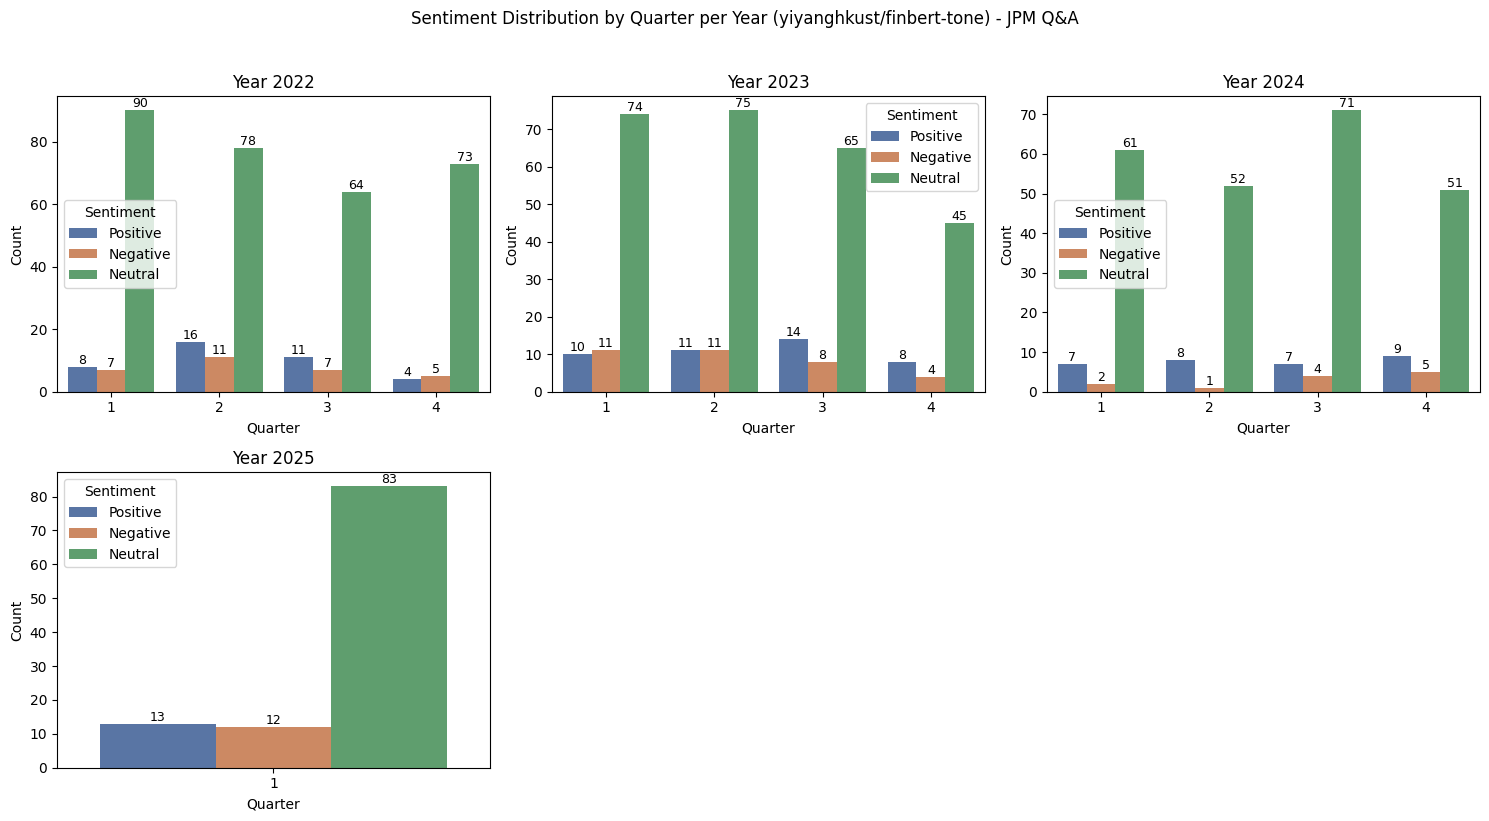

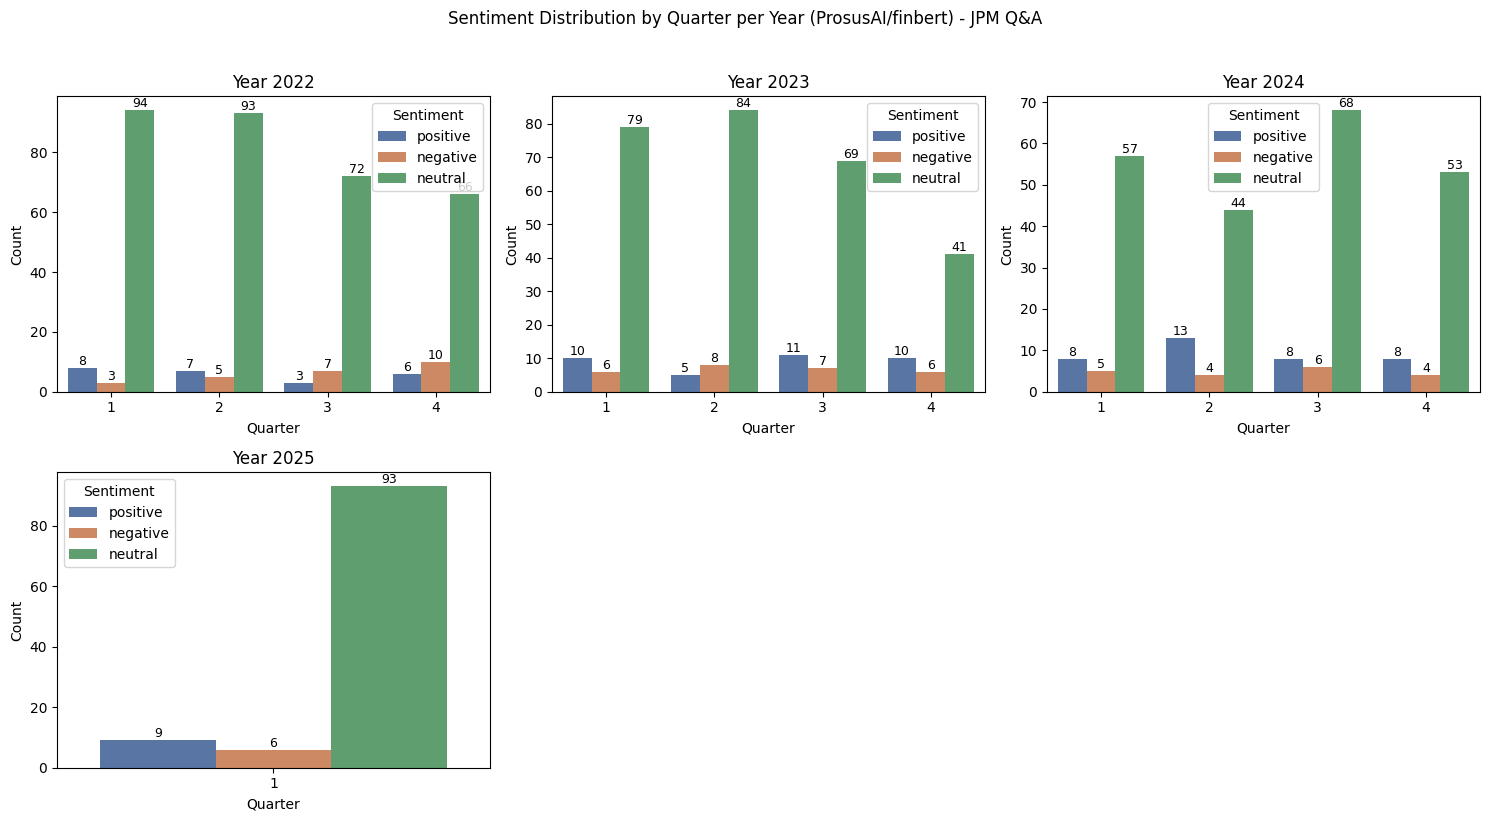

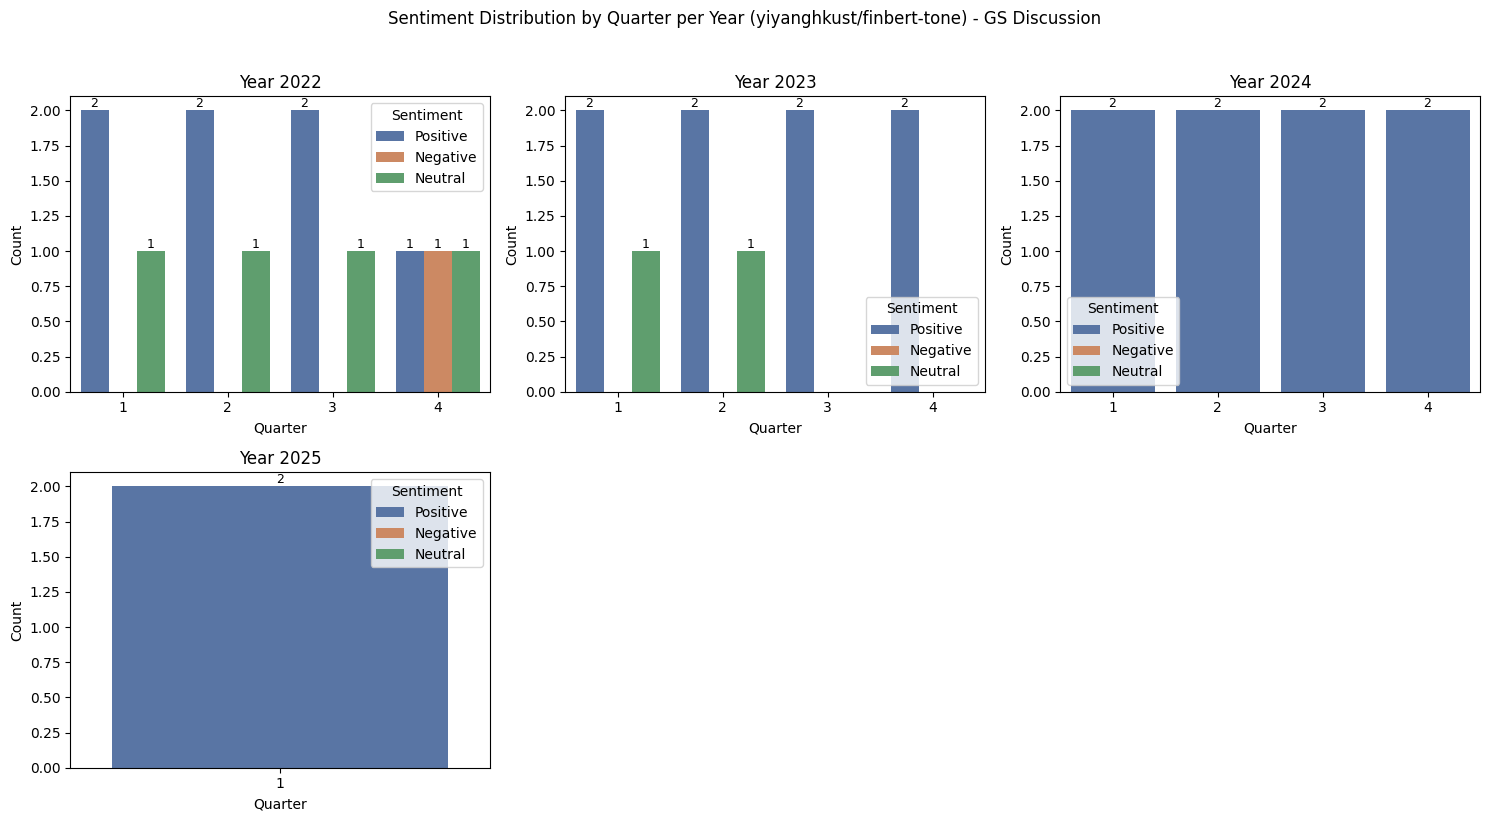

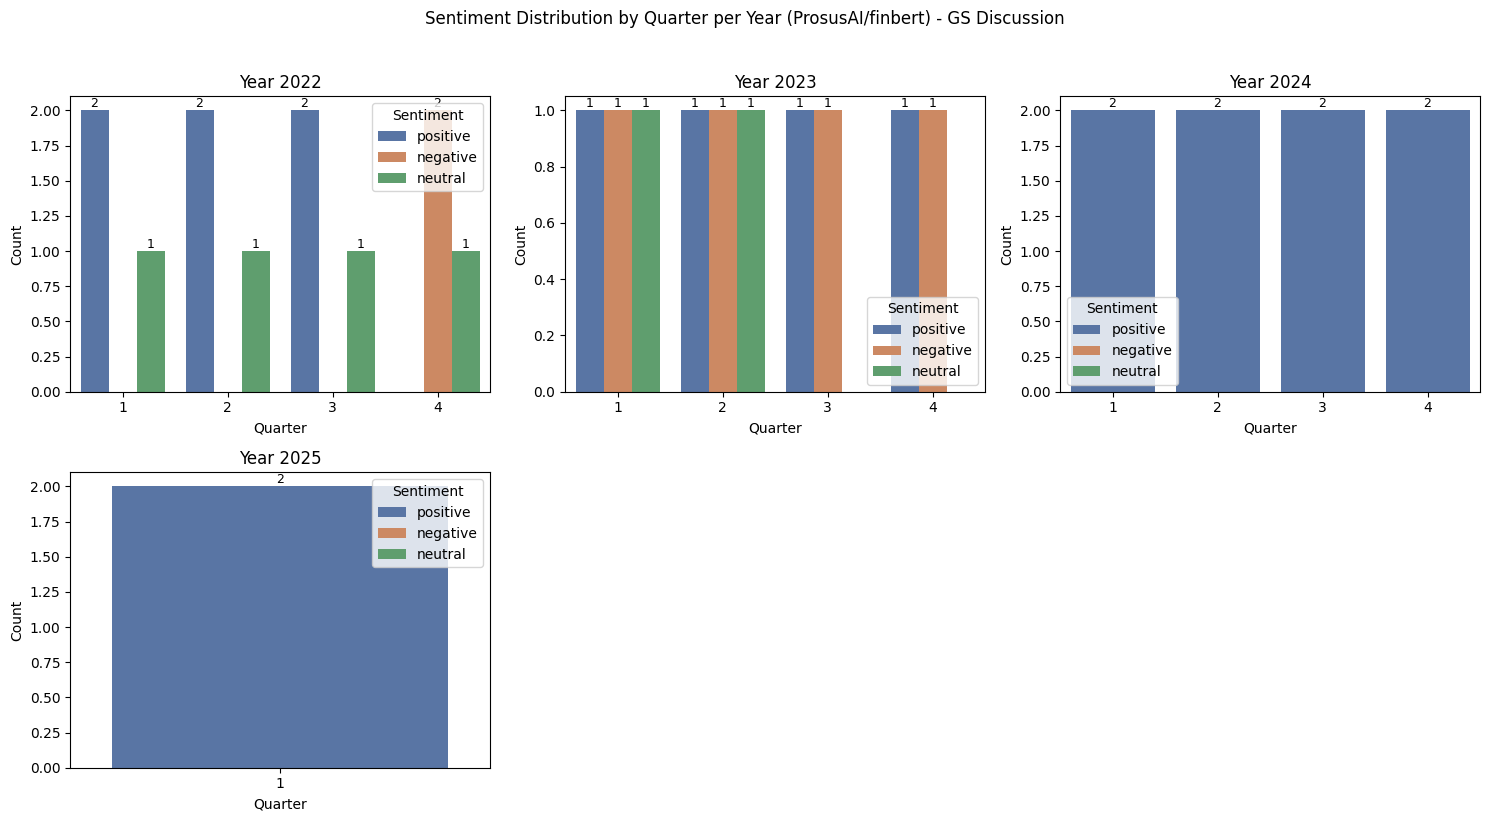

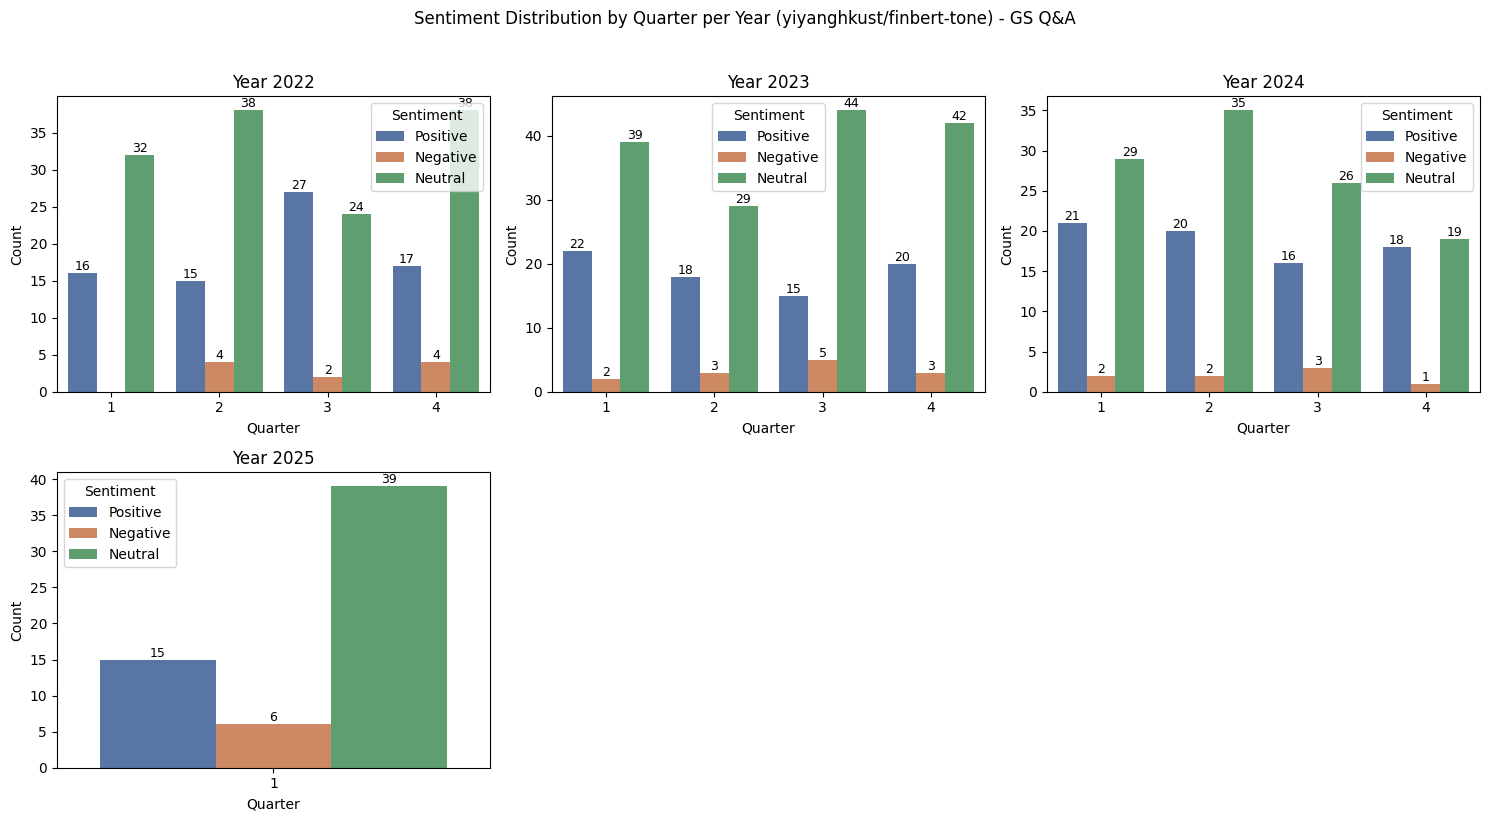

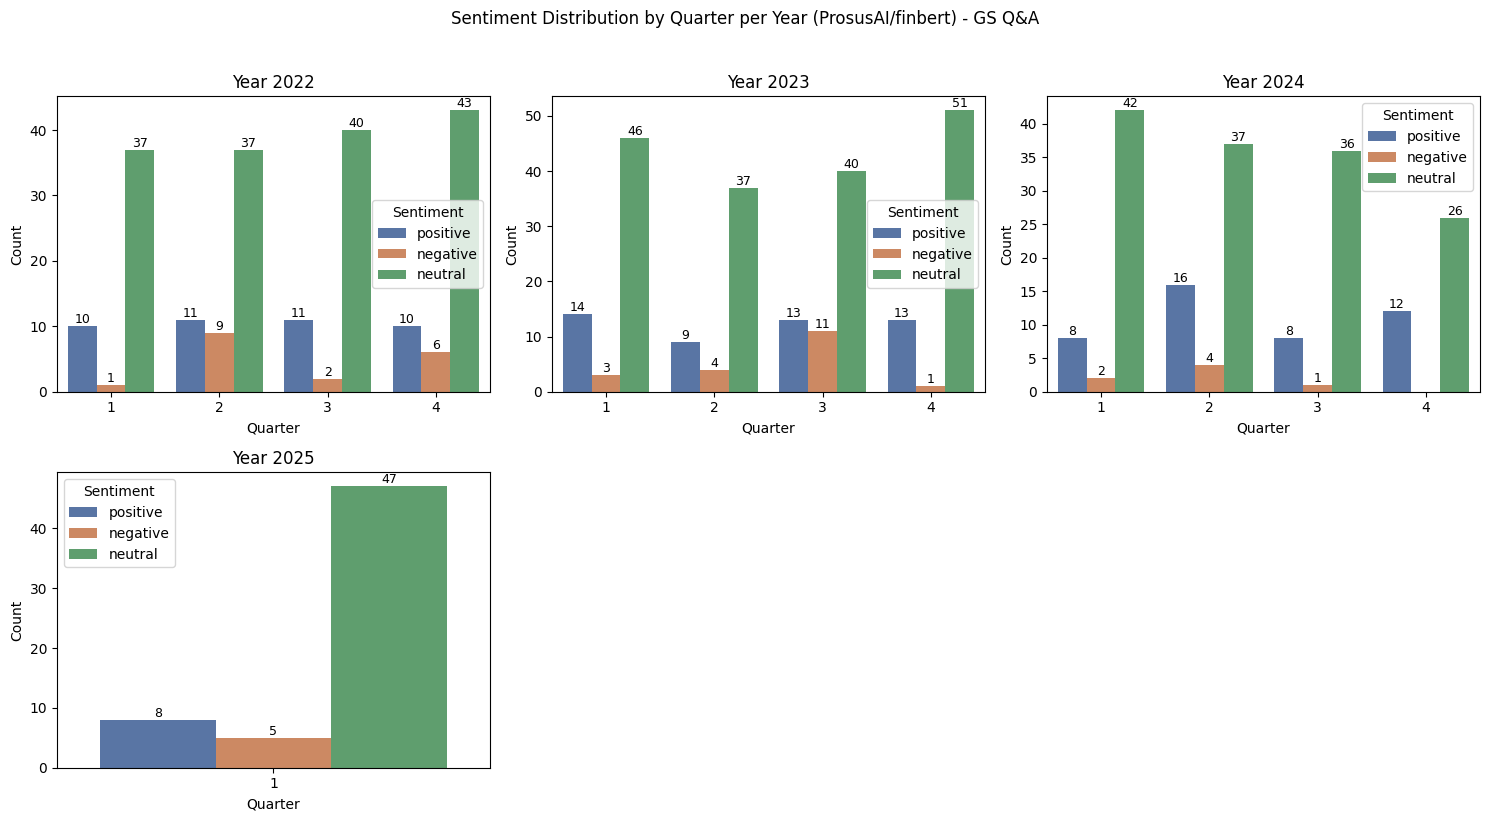

In [267]:
# Graph sentiment distribution by quarter for each year on seperate graphs but on the same figure

def plot_sentiment_distribution_by_quarter_yearly(df, model_name, title_suffix):
  """
  Graphs sentiment distribution by quarter for each year on separate graphs
  but on the same figure.

  Args:
    df (pd.DataFrame): DataFrame containing sentiment analysis results
                       with 'year', 'quarter', and 'label' columns.
    model_name (str): Name of the sentiment model used.
    title_suffix (str): Suffix for the overall figure title.
  """
  years = df['year'].unique()
  n_years = len(years)

  # Order label
  if model_name == "yiyanghkust/finbert-tone":
    label_order = ['Positive', 'Negative', 'Neutral']
  elif model_name == "ProsusAI/finbert":
    label_order = ['positive', 'negative', 'neutral']

  # Determine number of rows and columns for the subplot grid
  n_cols = min(3, n_years)  # Max 3 columns
  n_rows = (n_years + n_cols - 1) // n_cols

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
  axes = axes.flatten() # Flatten the axes array for easy iteration

  for i, year in enumerate(years):
    ax = axes[i]
    df_year = df[df['year'] == year]
    sns.countplot(data=df_year, x='quarter', hue='label',hue_order=label_order, palette='deep', ax=ax)
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Quarter')
    ax.set_ylabel('Count')
    ax.legend(title='Sentiment')

      # Add count annotations
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(
                p.get_x() + p.get_width() / 2.,
                height,
                f'{int(height)}',
                ha='center', va='bottom',
                fontsize=9
            )





  # Remove unused subplots if any
  for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

  plt.suptitle(f'Sentiment Distribution by Quarter per Year ({model_name}) - {title_suffix}', y=1.02)
  plt.tight_layout()
  plt.show()

# JP Morgan Discussion
plot_sentiment_distribution_by_quarter_yearly(df_jpm_scored_md_kust, "yiyanghkust/finbert-tone", "JPM Discussion")
plot_sentiment_distribution_by_quarter_yearly(df_jpm_scored_md_prosus, "ProsusAI/finbert", "JPM Discussion")

# JP Morgan Q&A
plot_sentiment_distribution_by_quarter_yearly(df_scored_qa_jpm_kust, "yiyanghkust/finbert-tone", "JPM Q&A")
plot_sentiment_distribution_by_quarter_yearly(df_scored_qa_jpm_prosus, "ProsusAI/finbert", "JPM Q&A")

# Goldman Sachs Discussion
plot_sentiment_distribution_by_quarter_yearly(df_gs_scored_md_kust, "yiyanghkust/finbert-tone", "GS Discussion")
plot_sentiment_distribution_by_quarter_yearly(df_gs_scored_md_prosus, "ProsusAI/finbert", "GS Discussion")

# Goldman Sachs Q&A
plot_sentiment_distribution_by_quarter_yearly(df_scored_qa_gs_kust, "yiyanghkust/finbert-tone", "GS Q&A")
plot_sentiment_distribution_by_quarter_yearly(df_scored_qa_gs_prosus, "ProsusAI/finbert", "GS Q&A")

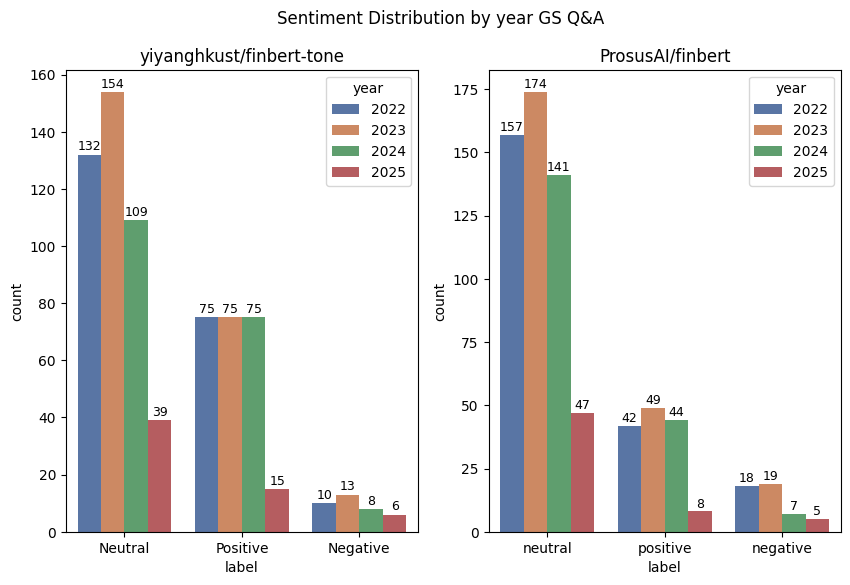

In [268]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))
sns.countplot(df_scored_qa_gs_kust, x="label", hue = 'year', ax=ax[0], palette='deep')
sns.countplot(df_scored_qa_gs_prosus, x="label", hue = 'year', ax=ax[1], palette='deep')
ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")

# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height + 0.5,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.suptitle("Sentiment Distribution by year GS Q&A")
plt.show()

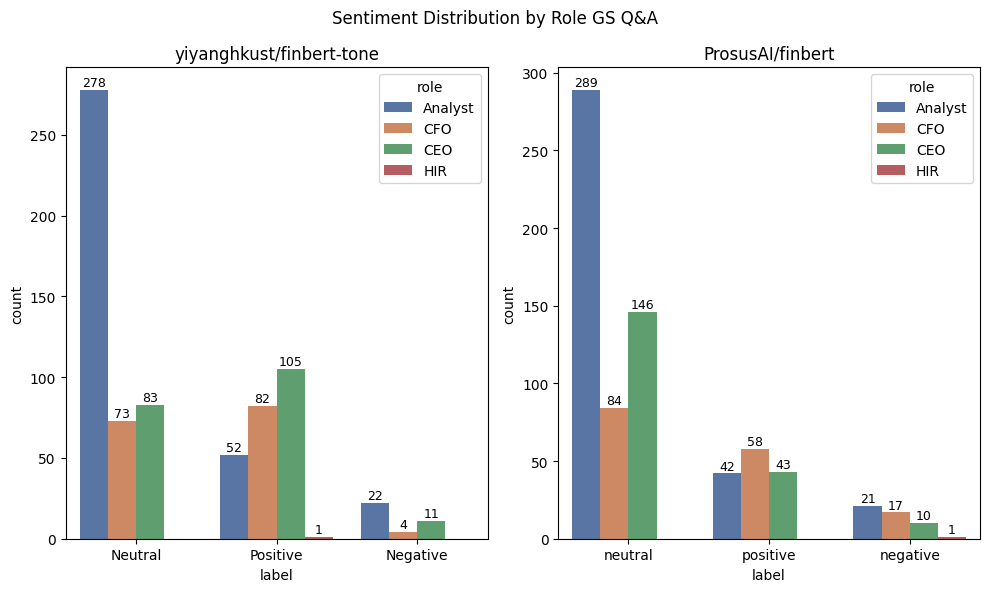

In [269]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))
sns.countplot(df_scored_qa_gs_kust, x="label", hue = 'role', ax=ax[0], palette='deep')
sns.countplot(df_scored_qa_gs_prosus, x="label", hue = 'role', ax=ax[1], palette='deep')
ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")

# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height + 0.5,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.suptitle("Sentiment Distribution by Role GS Q&A")
plt.tight_layout()
plt.show()


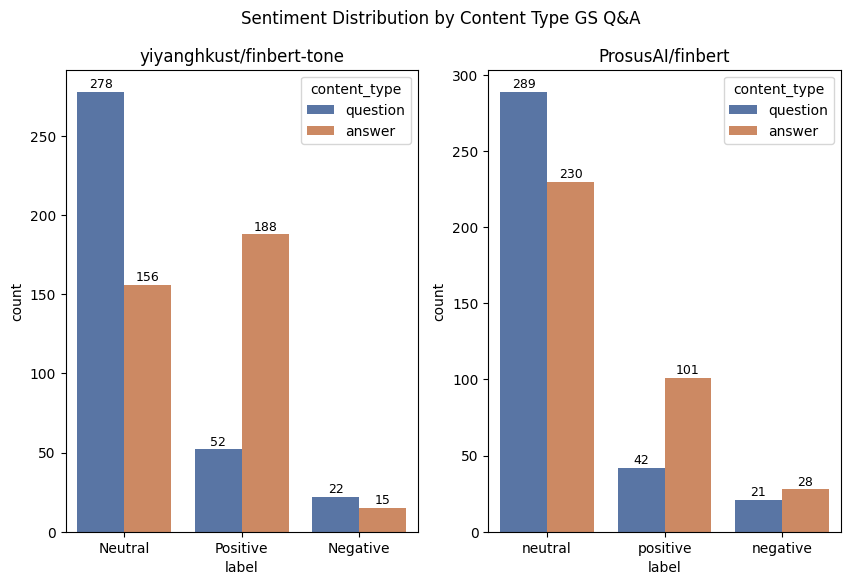

In [270]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))
sns.countplot(df_scored_qa_gs_kust, x="label", hue = 'content_type', ax=ax[0], palette='deep')
sns.countplot(df_scored_qa_gs_prosus, x="label", hue = 'content_type', ax=ax[1], palette='deep')
ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")

# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height + 0.5,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.suptitle("Sentiment Distribution by Content Type GS Q&A")
plt.show()

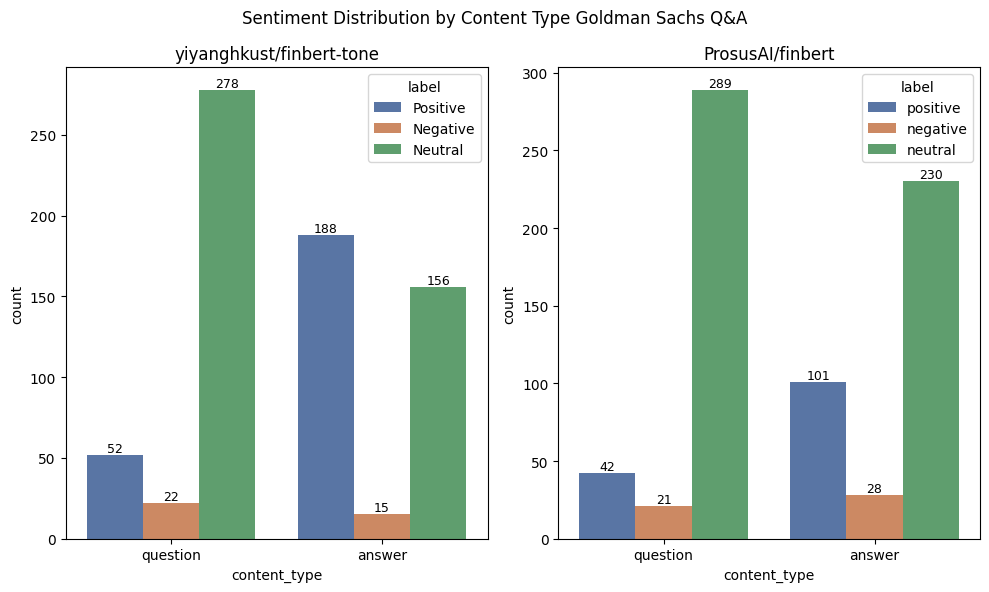

In [271]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))

# Order label
label_order_kust = ['Positive', 'Negative', 'Neutral']
label_order_prosus = ['positive', 'negative', 'neutral']

sns.countplot(df_scored_qa_gs_kust,
              x="content_type",
              hue = 'label',
              hue_order = label_order_kust,
              ax=ax[0],
              palette='deep')
sns.countplot(df_scored_qa_gs_prosus,
              x="content_type",
              hue = 'label',
              hue_order = label_order_prosus,
              ax=ax[1],
              palette='deep')
ax[0].set_title("yiyanghkust/finbert-tone")
ax[1].set_title("ProsusAI/finbert")

# Add count annotations to both plots
for a in ax:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )


plt.suptitle("Sentiment Distribution by Content Type Goldman Sachs Q&A")
plt.tight_layout()
plt.show()


### Divide Management Discussion text into sentences

In this section, we extend our analysis of the Discussion dataset by conducting a sentence-level breakdown, allowing for a more granular examination of sentiment within individual statements.


While both models detect a high prevalence of positive and neutral sentiments, ProsusAI offers a more balanced distribution by assigning a greater share of negative sentiment, especially in the Goldman Sachs data.

Yearly and quarterly breakdowns reveal stable sentiment patterns over time, with ProsusAI capturing more variation in tone across quarters and years, particularly within JPMorgan discussions. This model also highlights subtle sentiment shifts that yiyanghkust tends to smooth over due to its skew toward high-confidence positive classifications.

Notably, quarterly sentiment plots show ProsusAI identifying nuanced fluctuations in neutral and negative sentiment across reporting cycles—insights that are especially valuable for monitoring risk signals in executive communication.

In [316]:
# Divide text into sentences and score the sentences with both models

text = df_jpm_discussion["content"][0] # Assuming you want to process the first content entry

max_length = 512

tokenizer_1 = AutoTokenizer.from_pretrained(MODEL_NAME_1)
model_1     = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME_1)

tokenizer_2 = AutoTokenizer.from_pretrained(MODEL_NAME_2)
model_2     = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME_2)

nlp_1 = pipeline("sentiment-analysis", model=model_1, tokenizer=tokenizer_1)
nlp_2 = pipeline("sentiment-analysis", model=model_2, tokenizer=tokenizer_2)

# Split text into sentences
sentences = sent_tokenize(text)

# Print each sentence
for i, sentence in enumerate(sentences):
    print(f"sentence {i+1}:")
    print(sentence)
    results_1 = nlp_1(sentence, truncation=True, max_length=max_length)
    results_2 = nlp_2(sentence, truncation=True, max_length=max_length)
    print(f"\nyiyanghkust/finbert-tone {results_1}")
    print(f"ProsusAI/finbert {results_2}")
    print("-" * 20) # Separator for clarity

Device set to use cuda:0
Device set to use cuda:0


sentence 1:
Thanks, operator.

yiyanghkust/finbert-tone [{'label': 'Neutral', 'score': 0.9122114777565002}]
ProsusAI/finbert [{'label': 'positive', 'score': 0.5391892194747925}]
--------------------
sentence 2:
Good morning, everyone.

yiyanghkust/finbert-tone [{'label': 'Positive', 'score': 0.5041545033454895}]
ProsusAI/finbert [{'label': 'neutral', 'score': 0.8333916068077087}]
--------------------
sentence 3:
The presentation is available on our website and please refer to the disclaimer in the back.

yiyanghkust/finbert-tone [{'label': 'Neutral', 'score': 0.9999125003814697}]
ProsusAI/finbert [{'label': 'neutral', 'score': 0.9520125389099121}]
--------------------
sentence 4:
Starting on page 1, the firm reported net income of $8.3 billion, EPS of $2.63, on revenue of $31.6 billion and delivered an ROTCE of 16%.

yiyanghkust/finbert-tone [{'label': 'Neutral', 'score': 0.9998233914375305}]
ProsusAI/finbert [{'label': 'neutral', 'score': 0.8983671069145203}]
--------------------
sent

### Discussion Dataset (Sentence Breakdown)

In [317]:
# Divide text into sentences and scores the sentences with both models and appends it to a dataframe while keeping track of the years and quarters

def score_m_d_sentences_to_df(df, model_1, model_2):
    """
    Divides text content from a DataFrame into sentences, scores them with two sentiment models,
    and appends the results to a new DataFrame while keeping track of years and quarters.

    Args:
      df (pd.DataFrame): DataFrame containing text content, with columns 'content',
                         'year', and 'quarter'.
      model_1 (str): Name of the first sentiment model (Hugging Face model ID).
      model_2 (str): Name of the second sentiment model (Hugging Face model ID).

    Returns:
      pd.DataFrame: A new DataFrame with each row representing a sentence and its
                    sentiment scores from both models, along with year and quarter information.
    """
    df = df.copy().sort_values(by=["year", "quarter"]).reset_index(drop=True)
    max_length = 512

    tokenizer_1 = AutoTokenizer.from_pretrained(model_1)
    model_1 = AutoModelForSequenceClassification.from_pretrained(model_1)
    tokenizer_2 = AutoTokenizer.from_pretrained(model_2)
    model_2 = AutoModelForSequenceClassification.from_pretrained(model_2)

    nlp_1 = pipeline("sentiment-analysis", model=model_1, tokenizer=tokenizer_1)
    nlp_2 = pipeline("sentiment-analysis", model=model_2, tokenizer=tokenizer_2)

    # List to store sentence data
    sentence_data = []

    for index, row in df.iterrows():
        text = row["content"]
        year = row["year"]
        quarter = row["quarter"]

        sentences = sent_tokenize(text)

        for sentence in sentences:
            # Score with model 1
            results_1 = nlp_1(sentence, truncation=True, max_length=max_length)
            score_1 = results_1[0]["score"]
            label_1 = results_1[0]["label"]

            # Score with model 2
            results_2 = nlp_2(sentence, truncation=True, max_length=max_length)
            score_2 = results_2[0]["score"]
            label_2 = results_2[0]["label"]

            sentence_data.append({
                "year": year,
                "quarter": quarter,
                "sentence": sentence,
                f"kust_score": score_1,
                f"kust_label": label_1,
                f"prosus_score": score_2,
                f"prosus_label": label_2
            })

    # Create a new DataFrame from the sentence data
    sentences_df = pd.DataFrame(sentence_data)

    return sentences_df

In [318]:
sentences_df_jpm_md = score_m_d_sentences_to_df(df_jpm_discussion, MODEL_NAME_1, MODEL_NAME_2)

Device set to use cuda:0
Device set to use cuda:0


In [319]:
sentences_df_jpm_md.head()

,year,quarter,sentence,kust_score,kust_label,prosus_score,prosus_label
0,2022,1,"Thanks, operator.",0.912211,Neutral,0.539189,positive
1,2022,1,"Good morning, everyone.",0.504155,Positive,0.833392,neutral
2,2022,1,The presentation is available on our website a...,0.999913,Neutral,0.952013,neutral
3,2022,1,"Starting on page 1, the firm reported net inco...",0.999823,Neutral,0.898367,neutral
4,2022,1,These results include approximately $900 milli...,0.872741,Neutral,0.824087,negative


In [322]:
sentences_df_jpm_md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          1338 non-null   int64  
 1   quarter       1338 non-null   int64  
 2   sentence      1338 non-null   object 
 3   kust_score    1338 non-null   float64
 4   kust_label    1338 non-null   object 
 5   prosus_score  1338 non-null   float64
 6   prosus_label  1338 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [320]:
sentences_df_gs_md = score_m_d_sentences_to_df(df_gs_discussion, MODEL_NAME_1, MODEL_NAME_2)

Device set to use cuda:0
Device set to use cuda:0


In [321]:
sentences_df_gs_md.head()

,year,quarter,sentence,kust_score,kust_label,prosus_score,prosus_label
0,2022,1,Good morning.,0.617099,Positive,0.796287,neutral
1,2022,1,"This is Carey Halio, Head of Investor Relation...",0.999781,Neutral,0.936277,neutral
2,2022,1,Welcome to our ﬁrst quarter earnings conferenc...,0.999486,Neutral,0.891069,neutral
3,2022,1,"Today , we will reference our earnings present...",0.999988,Neutral,0.948140,neutral
4,2022,1,"Note, information on forward-looking statement...",0.999867,Neutral,0.944542,neutral


In [323]:
sentences_df_gs_md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          1669 non-null   int64  
 1   quarter       1669 non-null   int64  
 2   sentence      1669 non-null   object 
 3   kust_score    1669 non-null   float64
 4   kust_label    1669 non-null   object 
 5   prosus_score  1669 non-null   float64
 6   prosus_label  1669 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 91.4+ KB


#### Comparison Graphs

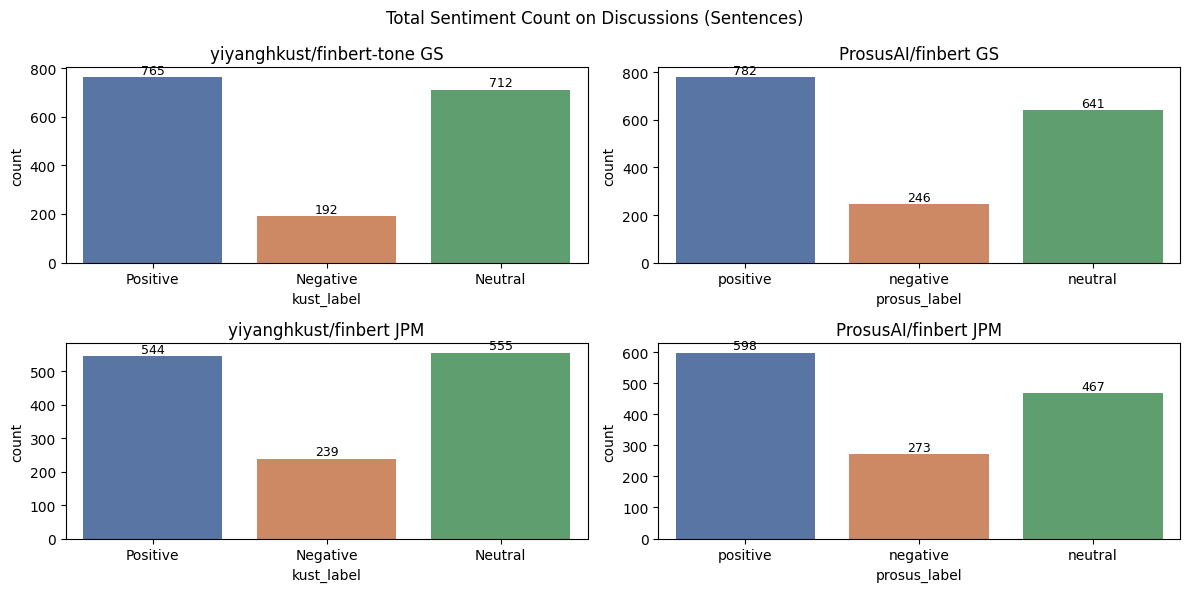

In [324]:
# Total Sentiment Count Graph

fig, ax = plt.subplots(2,2,figsize=(12, 6))

# Order labels
label_order_order_kust = ['Positive', 'Negative', 'Neutral']
label_order_order_prosus = ['positive', 'negative', 'neutral']


# Flatten the 2x2 array of axes into a 1D array
axes = ax.flatten()

sns.countplot(sentences_df_gs_md, x="kust_label",  ax=axes[0],order=label_order_kust, palette='deep')
sns.countplot(sentences_df_gs_md, x="prosus_label",  ax=axes[1],order=label_order_prosus, palette='deep')
sns.countplot(sentences_df_jpm_md, x="kust_label",  ax=axes[2],order=label_order_kust, palette='deep')
sns.countplot(sentences_df_jpm_md, x="prosus_label",  ax=axes[3],order=label_order_prosus, palette='deep')
axes[0].set_title("yiyanghkust/finbert-tone GS")
axes[1].set_title("ProsusAI/finbert GS")
axes[2].set_title("yiyanghkust/finbert JPM")
axes[3].set_title("ProsusAI/finbert JPM")

# Add count annotations to both plots
for a in axes:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height + 0.5,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.suptitle('Total Sentiment Count on Discussions (Sentences)')
plt.tight_layout()
plt.show()

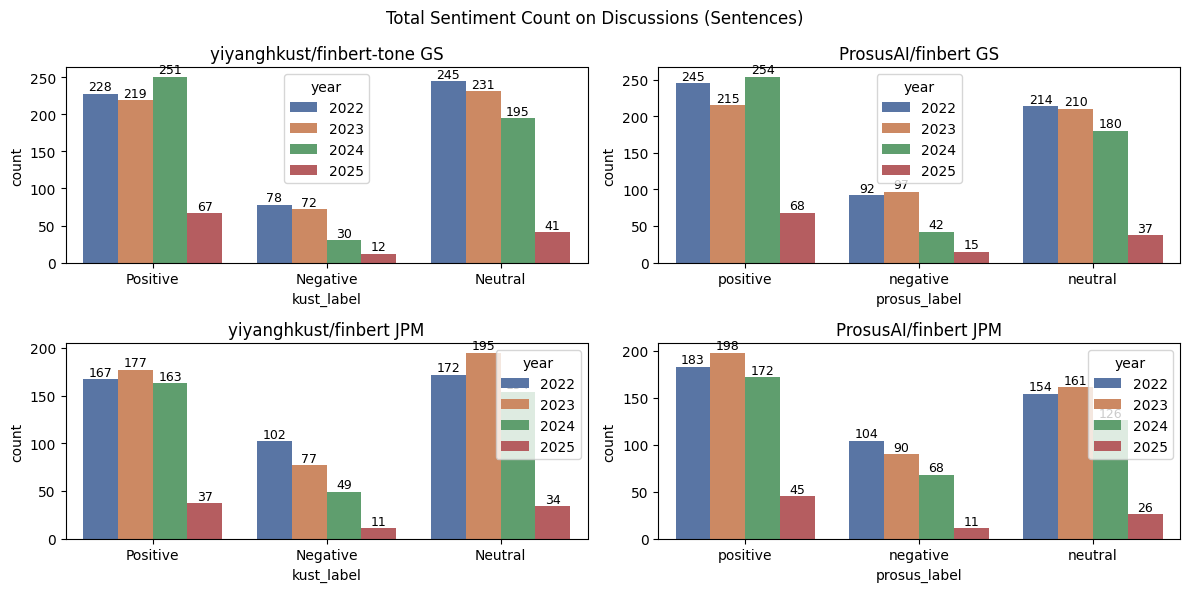

In [325]:
# Total Sentiment Count Graph

fig, ax = plt.subplots(2,2,figsize=(12, 6))

# Order labels
label_order_order_kust = ['Positive', 'Negative', 'Neutral']
label_order_order_prosus = ['positive', 'negative', 'neutral']


# Flatten the 2x2 array of axes into a 1D array
axes = ax.flatten()

sns.countplot(sentences_df_gs_md, x="kust_label", hue = 'year', ax=axes[0],order=label_order_kust, palette='deep')
sns.countplot(sentences_df_gs_md, x="prosus_label", hue = 'year', ax=axes[1],order=label_order_prosus, palette='deep')
sns.countplot(sentences_df_jpm_md, x="kust_label", hue = 'year', ax=axes[2],order=label_order_kust, palette='deep')
sns.countplot(sentences_df_jpm_md, x="prosus_label", hue = 'year', ax=axes[3],order=label_order_prosus, palette='deep')
axes[0].set_title("yiyanghkust/finbert-tone GS")
axes[1].set_title("ProsusAI/finbert GS")
axes[2].set_title("yiyanghkust/finbert JPM")
axes[3].set_title("ProsusAI/finbert JPM")

# Add count annotations to both plots
for a in axes:
    for p in a.patches:
        height = p.get_height()
        if height > 0:
            a.text(
                p.get_x() + p.get_width() / 2.,
                height + 0.5,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.suptitle('Total Sentiment Count on Discussions (Sentences)')
plt.tight_layout()
plt.show()

In [347]:
#Compare yearly distribution over quarters and years for sentences dataframes

def compare_yearly_distribution(df, model_name, title_suffix):
  """
  Generates count plots to compare sentiment distribution across years
  for each quarter in the DataFrame.

  Args:
    df (pd.DataFrame): DataFrame containing sentiment analysis results
                       with 'year', 'quarter', and 'label' columns.
    model_name (str): Name of the sentiment model used.
    title_suffix (str): Suffix for the overall figure title.
  """
  quarters = df['quarter'].unique()
  n_quarters = len(quarters)

  if model_name == "yiyanghkust/finbert-tone":
    df['label_col'] = df['kust_label']
  elif model_name == "ProsusAI/finbert":
    df['label_col'] = df['prosus_label']


  # Define consistent color palette
  if model_name == "yiyanghkust/finbert-tone":
    sentiment_order = ['Positive', 'Neutral', 'Negative']
    sentiment_palette = {
      'Positive': '#EE9B00',  # Greenish
      'Neutral': '#0A9396',   # Orange
      'Negative': '#AE2012'   # Blue
  }
  elif model_name == "ProsusAI/finbert":
    sentiment_order = ['positive', 'neutral', 'negative']
    sentiment_palette = {
      'positive': '#005F73',  # Greenish
      'neutral': '#CA6702',   # Orange
      'negative': '#94D2BD'   # Blue
  }


  # Determine number of rows and columns for the subplot grid
  n_cols = min(3, n_quarters)  # Max 3 columns
  n_rows = (n_quarters + n_cols - 1) // n_cols

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
  axes = axes.flatten() # Flatten the axes array for easy iteration

  for i, quarter in enumerate(quarters):
    ax = axes[i]
    df_quarter = df[df['quarter'] == quarter]
    sns.countplot(data=df_quarter, x='year', hue='label_col', hue_order=sentiment_order, palette=sentiment_palette, ax=ax)
    ax.set_title(f'Quarter {quarter}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    ax.legend(title='Sentiment')
    ax.set_yticks([])  # Remove y-axis ticks

    # Add count annotations
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(
                p.get_x() + p.get_width() / 2.,
                height + 1,
                f'{int(height)}',
                ha='center', va='bottom',
                fontsize=9
            )

  # Remove unused subplots if any
  for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

  plt.suptitle(f'Yearly Sentiment Distribution per Quarter ({model_name}) - {title_suffix}', y=1.02)
  plt.tight_layout()
  plt.show()

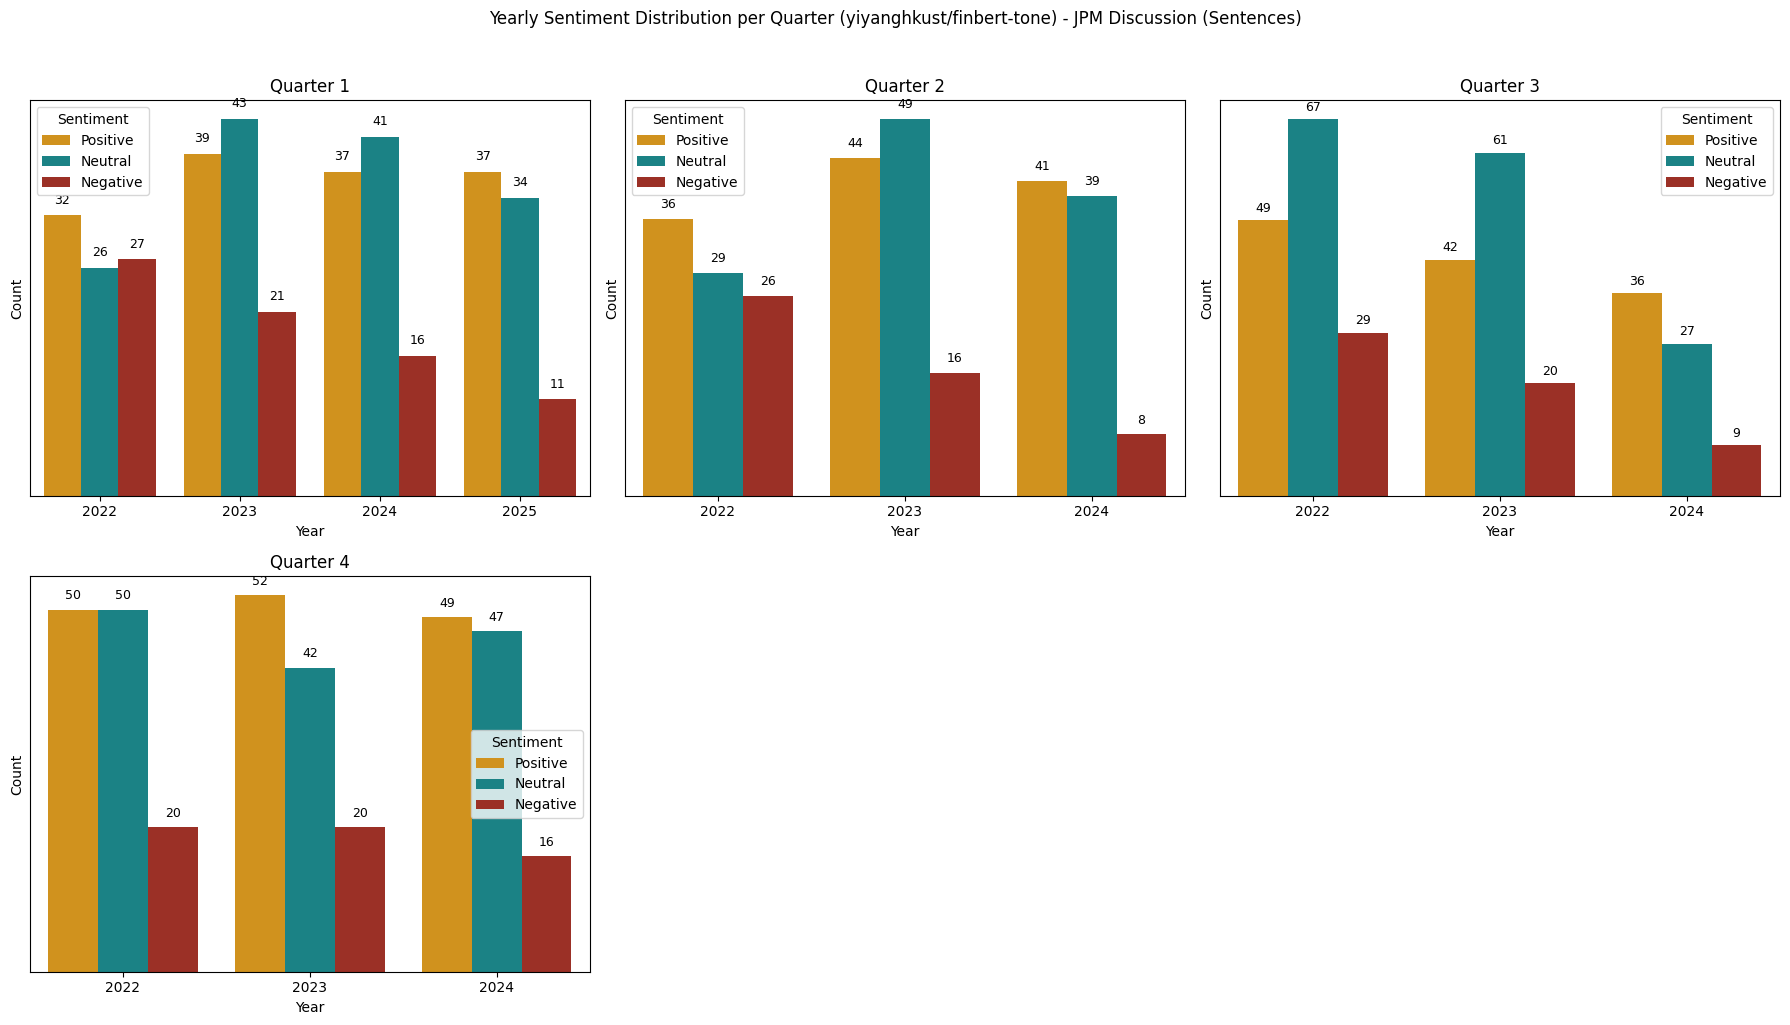

In [348]:
compare_yearly_distribution(sentences_df_jpm_md,"yiyanghkust/finbert-tone", "JPM Discussion (Sentences)")

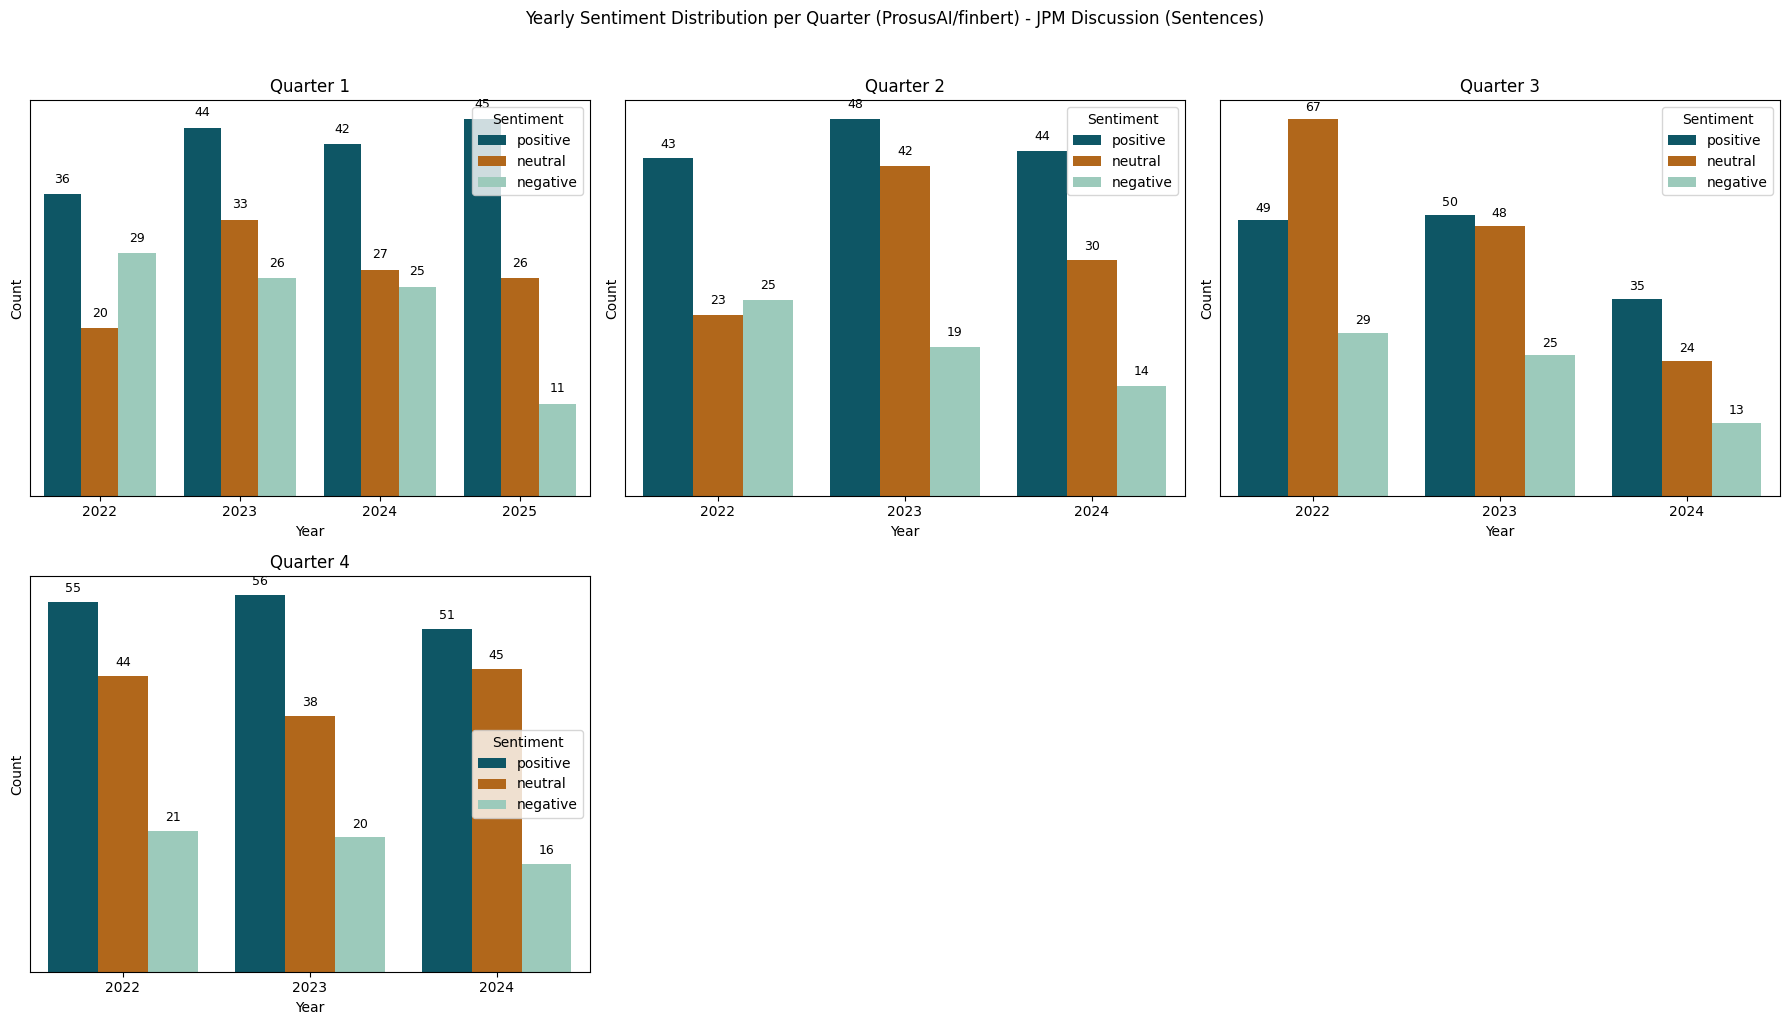

In [349]:
compare_yearly_distribution(sentences_df_jpm_md, "ProsusAI/finbert", "JPM Discussion (Sentences)")

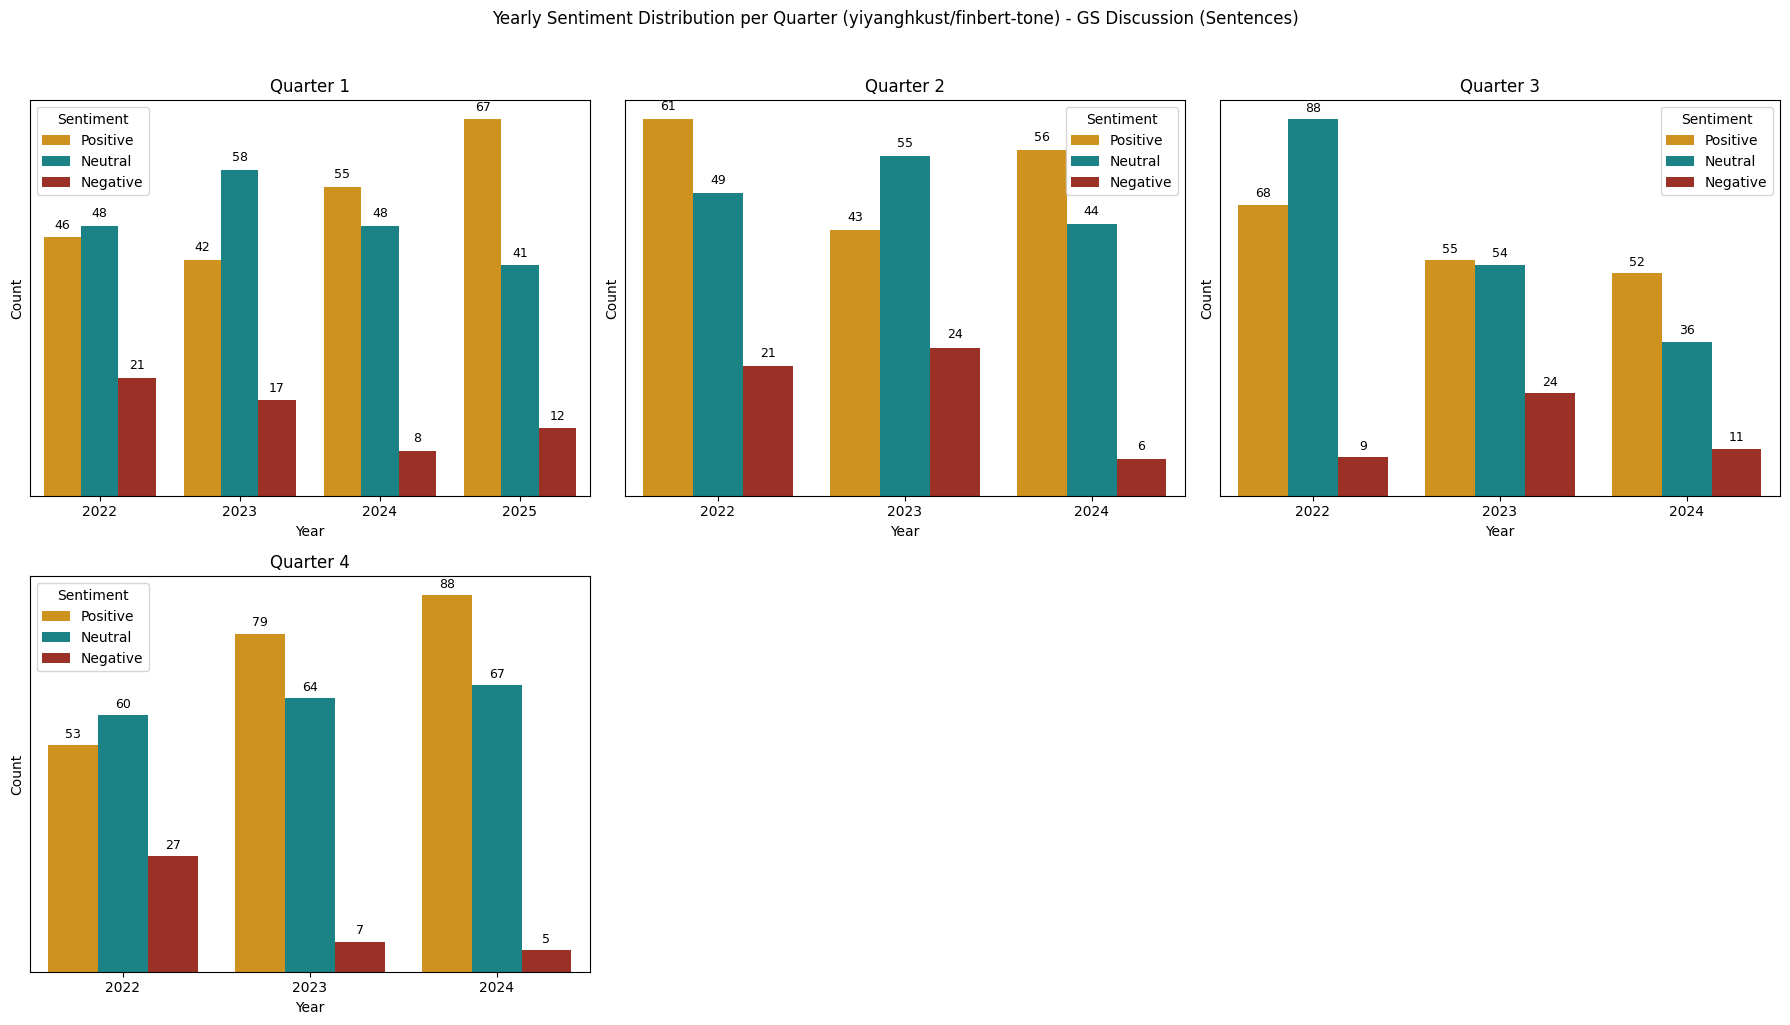

In [350]:
compare_yearly_distribution(sentences_df_gs_md, "yiyanghkust/finbert-tone", "GS Discussion (Sentences)")

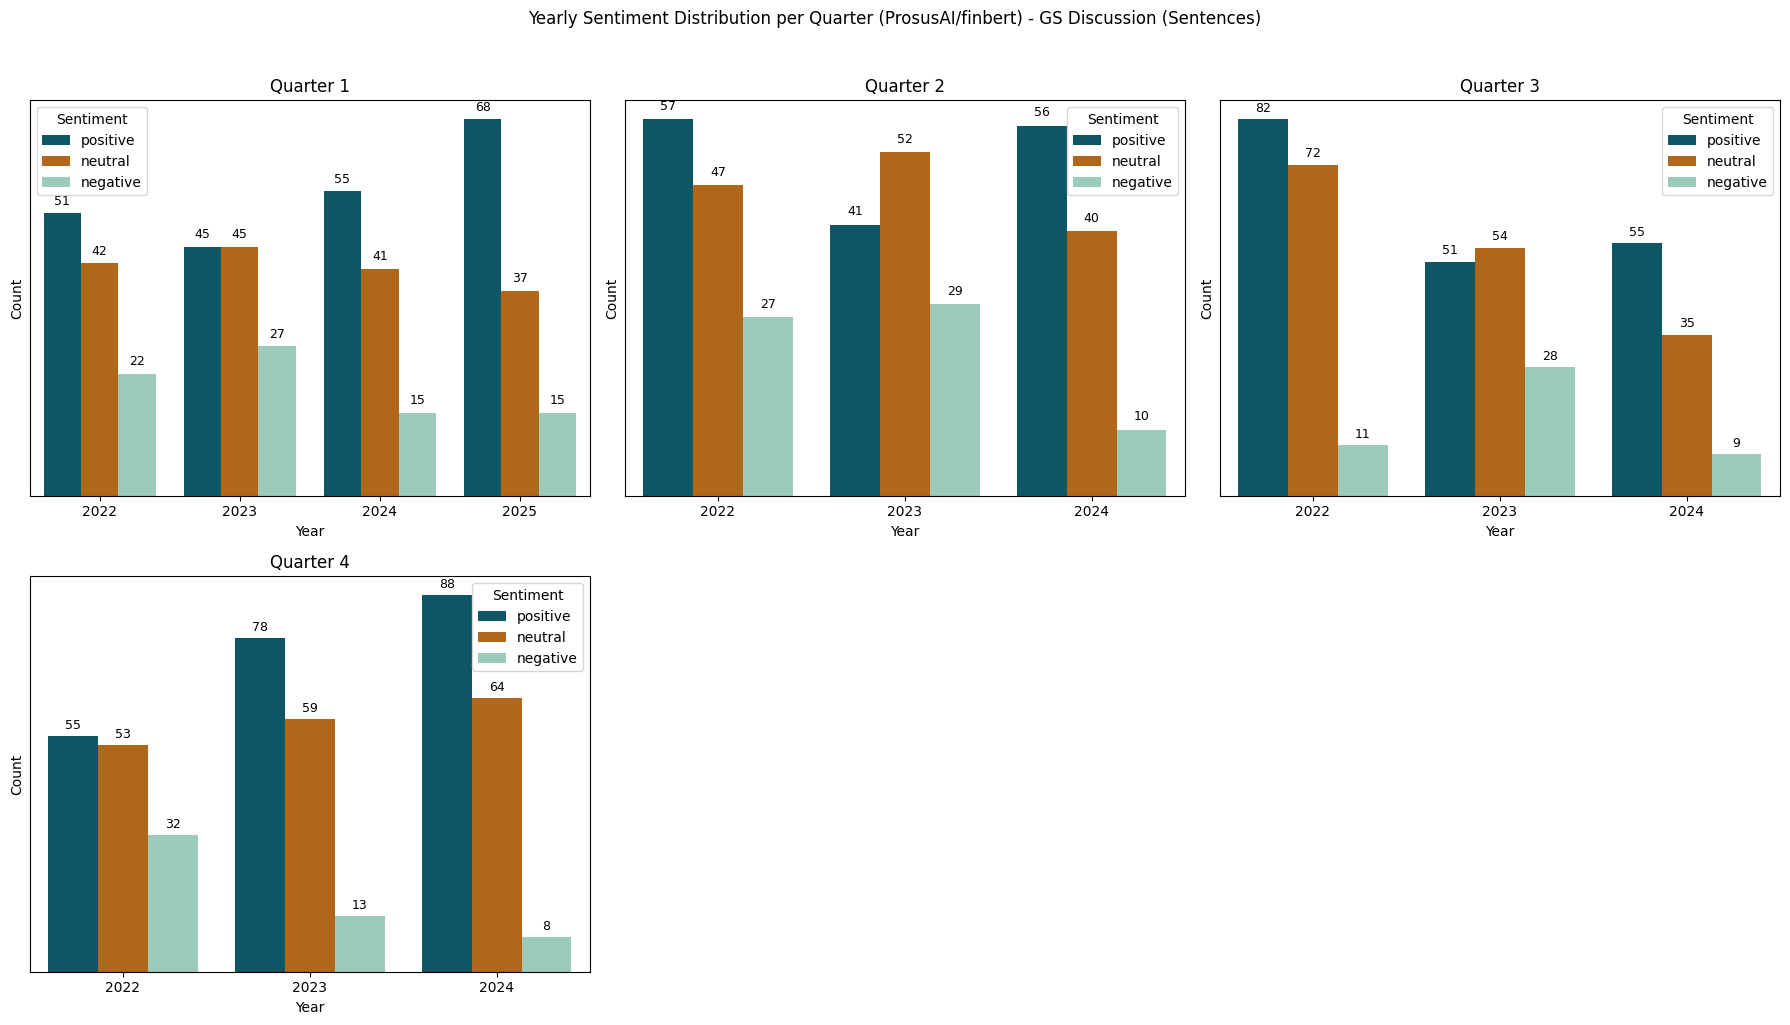

In [351]:
compare_yearly_distribution(sentences_df_gs_md, "ProsusAI/finbert", "GS Discussion (Sentences)")

In [352]:
from matplotlib_venn import venn2

In [353]:
# Graph overlap of scores per sentiment with corresponding percentage of overlap

def plot_sentiment_overlap_venn(df, title_suffix):
    """
    Generates Venn diagrams to visualize the overlap of sentences classified
    as 'Negative' by both 'kust' and 'prosus' models.

    Args:
        df (pd.DataFrame): DataFrame containing sentence-level sentiment analysis
                           results with 'kust_label' and 'prosus_label' columns.
        title_suffix (str): Suffix for the Venn diagram title.
    """
    # Filter for Negative sentiment from each model
    kust_negative = set(df[df['kust_label'] == 'Negative'].index)
    prosus_negative = set(df[df['prosus_label'] == 'negative'].index) # Note 'negative' for prosus

    # Calculate the sizes of the sets and their intersection
    size_kust_neg = len(kust_negative)
    size_prosus_neg = len(prosus_negative)
    size_intersection = len(kust_negative.intersection(prosus_negative))

    # Create the Venn diagram
    plt.figure(figsize=(8, 6))
    venn2(subsets=(size_kust_neg, size_prosus_neg, size_intersection),
          set_labels=('kust Negative', 'Prosus Negative'))

    # Calculate percentages
    total_sentences = len(df)
    percentage_kust_neg = (size_kust_neg / total_sentences) * 100 if total_sentences > 0 else 0
    percentage_prosus_neg = (size_prosus_neg / total_sentences) * 100 if total_sentences > 0 else 0
    percentage_intersection = (size_intersection / total_sentences) * 100 if total_sentences > 0 else 0

    # Add title and text annotations
    plt.title(f'Overlap of Negative Sentiments (Sentence Level) - {title_suffix}')
    plt.text(-0.8, 0.06, f'KUST Negative: {size_kust_neg} ({percentage_kust_neg:.2f}%)', fontsize=10)
    plt.text(0.4, 0.06, f'Prosus Negative: {size_prosus_neg} ({percentage_prosus_neg:.2f}%)', fontsize=10)
    plt.text(0, 0.1, f'Overlap: {size_intersection} ({percentage_intersection:.2f}%)', fontsize=10, ha='center', va='center')


    plt.show()


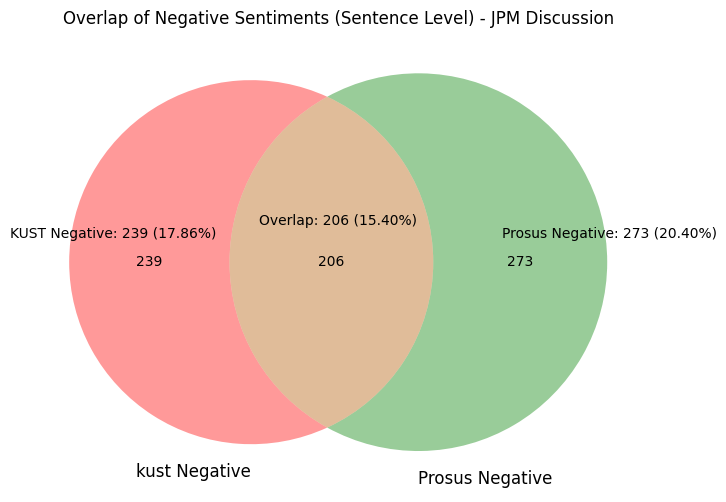

In [354]:
# Generate Venn diagrams for the sentence-level dataframes
plot_sentiment_overlap_venn(sentences_df_jpm_md, "JPM Discussion")


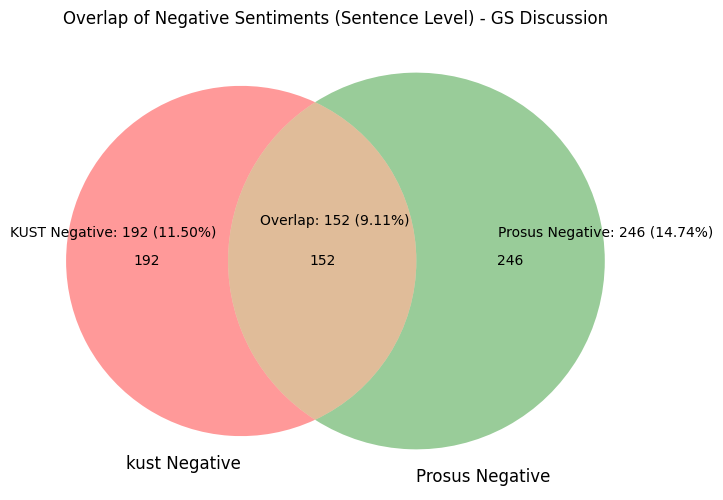

In [355]:
plot_sentiment_overlap_venn(sentences_df_gs_md, "GS Discussion")

The Venn diagrams illustrate the overlap of negative sentiment classifications at the sentence level between yiyanghkust/finbert-tone and ProsusAI/finbert for JPMorgan and Goldman Sachs discussions.

In both cases, ProsusAI identifies a broader set of negative statements, suggesting greater sensitivity to downside tone. For JPMorgan, 206 sentences (15.4%) are commonly flagged as negative by both models, reflecting a relatively high agreement. However, for Goldman Sachs, the overlap is lower at 152 sentences (9.11%), indicating increased divergence in model interpretation.

These visuals reinforce the notion that ProsusAI provides a more expansive and nuanced view of risk-related language, while yiyanghkust tends to filter for only the most strongly negative cues.

## Negative Sentences Discussion

In this section we save the negative scored discussions and Q&A DataFrames generated using both sentiment models.

 These models will be used for further Topic Analysis.

In [301]:
# Create two dataframes,
# One with Prosus negative sentiment sentences,
# One with hkust negatives sentiments

def create_negative_sentiment_dataframes(sentences_df):
  """
  Creates two pandas DataFrames containing sentences classified as negative
  by the ProsusAI/finbert model and the yiyanghkust/finbert-tone model, respectively.

  Args:
    sentences_df (pd.DataFrame): DataFrame containing sentence-level sentiment
                                 analysis results with 'kust_label' and
                                 'prosus_label' columns.

  Returns:
    tuple: A tuple containing two DataFrames:
           - df_prosus_negative: Sentences classified as 'negative' by ProsusAI/finbert.
           - df_kust_negative: Sentences classified as 'Negative' by yiyanghkust/finbert-tone.
  """
  df_prosus_negative = sentences_df[sentences_df['prosus_label'] == 'negative'].copy()
  df_kust_negative = sentences_df[sentences_df['kust_label'] == 'Negative'].copy()

  return df_prosus_negative, df_kust_negative

# Example usage with your existing sentence dataframes:
df_prosus_negative_jpm, df_kust_negative_jpm = create_negative_sentiment_dataframes(sentences_df_jpm_md)
df_prosus_negative_gs, df_kust_negative_gs = create_negative_sentiment_dataframes(sentences_df_gs_md)

In [302]:
# ProsusAI/finbert Negative Sentences (JPM Discussion)
df_prosus_negative_jpm = sentences_df_jpm_md[sentences_df_jpm_md['prosus_label'] == 'negative'].copy()
df_prosus_negative_jpm.reset_index(drop=True, inplace=True)
df_prosus_negative_jpm.drop(columns=['kust_score'], inplace=True)
df_prosus_negative_jpm.drop(columns=['kust_label'], inplace=True)
df_prosus_negative_jpm.drop(columns=['label_col'], inplace=True)
df_prosus_negative_jpm.drop(columns=['label'], inplace=True)
df_prosus_negative_jpm.head()

,year,quarter,sentence,prosus_score,prosus_label
0,2022,1,These results include approximately $900 milli...,0.824087,negative
1,2022,1,Revenue of $31.6 billion was down $1.5 billion...,0.976310,negative
2,2022,1,NIR ex Markets was down $2.2\nbillion or 17% p...,0.975434,negative
3,2022,1,And markets revenue wa s down $300 million or ...,0.975872,negative
4,2022,1,Net charge -offs of $582 million were down yea...,0.975554,negative


In [303]:
# yiyanghkust/finbert-tone Negative Sentences (JPM Discussion)
df_kust_negative_jpm = sentences_df_jpm_md[sentences_df_jpm_md['kust_label'] == 'Negative'].copy()
df_kust_negative_jpm.reset_index(drop=True, inplace=True)
df_kust_negative_jpm.drop(columns=['prosus_score'], inplace=True)
df_kust_negative_jpm.drop(columns=['prosus_label'], inplace=True)
df_kust_negative_jpm.drop(columns=['label_col'], inplace=True)
df_kust_negative_jpm.drop(columns=['label'], inplace=True)
df_kust_negative_jpm.head()

,year,quarter,sentence,kust_score,kust_label
0,2022,1,Revenue of $31.6 billion was down $1.5 billion...,0.999998,Negative
1,2022,1,NIR ex Markets was down $2.2\nbillion or 17% p...,0.999994,Negative
2,2022,1,And markets revenue wa s down $300 million or ...,0.999998,Negative
3,2022,1,Net charge -offs of $582 million were down yea...,0.999374,Negative
4,2022,1,"Our CET1 ratio ended at 11.9%, down 120 basis ...",0.998379,Negative


In [306]:
df_prosus_negative_jpm_q_a = df_scored_qa_jpm_prosus[df_scored_qa_jpm_prosus['label'] == 'negative'].copy()
df_prosus_negative_jpm_q_a.reset_index(drop=True, inplace=True)
df_prosus_negative_jpm_q_a.head()

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter,content_type,score,label
0,10,5,Glenn Schorr,Analyst,Evercore,Maybe the last quickie on credit is just with ...,2022,1,question,0.504742,negative
1,4,6,Jamie Dimon,CEO,JP Morgan Chase & Co.,One of the things I hated when CECL came out i...,2022,1,answer,0.807082,negative
2,3,9,Jeremy Barnum,CFO,JP Morgan Chase & Co.,"Yeah. I mean, you know that we're going to be ...",2022,1,answer,0.500835,negative
3,5,1,Jamie Dimon,CEO,JP Morgan Chase & Co.,"Yeah, the only thing I would like to add is th...",2022,2,answer,0.625166,negative
4,9,4,Jamie Dimon,CEO,JP Morgan Chase & Co.,"The other thing is, it's got bad effects for t...",2022,2,answer,0.944247,negative


In [307]:
df_kust_negative_jpm_q_a = df_scored_qa_jpm_kust[df_scored_qa_jpm_kust['label'] == 'Negative'].copy()
df_kust_negative_jpm_q_a.reset_index(drop=True, inplace=True)
df_kust_negative_jpm_q_a.head()

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter,content_type,score,label
0,3,1,Jeremy Barnum,CFO,JP Morgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1,answer,0.510577,Negative
1,8,5,Glenn Schorr,Analyst,Evercore,That doesn’t sound so bad.,2022,1,question,0.984300,Negative
2,2,6,Gerard Cassidy,Analyst,RBC,Can we follow up on your comments about buildi...,2022,1,question,0.533315,Negative
3,4,6,Jamie Dimon,CEO,JP Morgan Chase & Co.,One of the things I hated when CECL came out i...,2022,1,answer,0.999602,Negative
4,5,8,Jamie Dimon,CEO,JP Morgan Chase & Co.,"...you'd be shocked. So obviously, we're aware...",2022,1,answer,0.821745,Negative


In [308]:
# ProsusAI/finbert Negative Sentences (GS Discussion)
df_prosus_negative_gs = sentences_df_gs_md[sentences_df_gs_md['prosus_label'] == 'negative'].copy()
df_prosus_negative_gs.reset_index(drop=True, inplace=True)
df_prosus_negative_gs.drop(columns=['kust_score'], inplace=True)
df_prosus_negative_gs.drop(columns=['kust_label'], inplace=True)
df_prosus_negative_gs.drop(columns=['label_col'], inplace=True)
df_prosus_negative_gs.drop(columns=['label'], inplace=True)
df_prosus_negative_gs

,year,quarter,sentence,prosus_score,prosus_label
0,2022,1,There's no question the ﬁrst quarter was extre...,0.824885,negative
1,2022,1,I believe we're entering a period that won't b...,0.619428,negative
2,2022,1,This meant that some parts of our ﬁrm faced si...,0.966419,negative
3,2022,1,"Early on, we took action to ensure the well-be...",0.680288,negative
4,2022,1,The overall direct ﬁnancial impact from Russia...,0.966256,negative
...,...,...,...,...,...
241,2025,1,Alternative assets under supervision totaled $...,0.647403,negative
242,2025,1,Our provision for credit losses of $287 millio...,0.934311,negative
243,2025,1,Total quarterly operating expenses were $9.1 b...,0.957405,negative
244,2025,1,Our ef fective tax rate for the quarter of 16....,0.741849,negative


In [309]:
# yiyanghkust/finbert-tone Negative Sentences (GS Discussion)
df_kust_negative_gs = sentences_df_gs_md[sentences_df_gs_md['kust_label'] == 'Negative'].copy()
df_kust_negative_gs.reset_index(drop=True, inplace=True)
df_kust_negative_gs.drop(columns=['prosus_score'], inplace=True)
df_kust_negative_gs.drop(columns=['prosus_label'], inplace=True)
df_kust_negative_gs.drop(columns=['label_col'], inplace=True)
df_kust_negative_gs.drop(columns=['label'], inplace=True)
df_kust_negative_gs

,year,quarter,sentence,kust_score,kust_label
0,2022,1,There's no question the ﬁrst quarter was extre...,0.988195,Negative
1,2022,1,I believe we're entering a period that won't b...,0.900773,Negative
2,2022,1,The recent turbulence is nothing to change our...,0.967361,Negative
3,2022,1,This meant that some parts of our ﬁrm faced si...,0.999998,Negative
4,2022,1,But there's no question that the most signiﬁca...,0.806023,Negative
...,...,...,...,...,...
187,2025,1,"In the meantime, markets will likely continue ...",0.963767,Negative
188,2025,1,W e provide details on selected items in the b...,0.999990,Negative
189,2025,1,"Turning to Page 4, advisory revenues of $792 m...",0.999999,Negative
190,2025,1,"Sequentially , results were roughly ﬂat as NIM...",0.589342,Negative


In [310]:
df_prosus_negative_gs_q_a = df_scored_qa_gs_prosus[df_scored_qa_gs_prosus['label'] == 'negative'].copy()
df_prosus_negative_gs_q_a.reset_index(drop=True, inplace=True)
df_prosus_negative_gs_q_a.head()

,question_order,question_answer_group_id,speaker,role,company,content_type,content,quarter,year,score,label
0,3,6,Devin Ryan,Analyst,Citizens JMP,question,okay . terriﬁc. thanks for the color . quick ...,1,2022,0.775194,negative
1,2,0,Glenn Schorr,Analyst,Evercore,question,okay . very much appreciated. and then one qu...,2,2022,0.804909,negative
2,0,4,Mike Mayo,Analyst,Wells Fargo,question,"hi, i guess i’m thinking in terms of the trad...",2,2022,0.513804,negative
3,1,5,Denis Coleman,CFO,Goldman Sachs,answer,sure. so two components to your question. and...,2,2022,0.498104,negative
4,2,5,Brennan Hawken,Analyst,UBS,question,"okay , great. thanks for that color , denis. ...",2,2022,0.760572,negative


In [311]:
df_kust_negative_gs_q_a = df_scored_qa_gs_kust[df_scored_qa_gs_kust['label'] == 'Negative'].copy()
df_kust_negative_gs_q_a.reset_index(drop=True, inplace=True)
df_kust_negative_gs_q_a.head()

,question_order,question_answer_group_id,speaker,role,company,content_type,content,quarter,year,score,label
0,1,1,David Solomon,CEO,Goldman Sachs,answer,"i will start, christian. i don’t know if deni...",2,2022,0.533848,Negative
1,3,4,David Solomon,CEO,Goldman Sachs,answer,"well, i guess i’d say a couple of things. w e...",2,2022,0.542778,Negative
2,2,5,Brennan Hawken,Analyst,UBS,question,"okay , great. thanks for that color , denis. ...",2,2022,0.957616,Negative
3,3,10,Gerard Cassidy,Analyst,RBC,question,"very good. and just as a follow-up, maybe you...",2,2022,0.998920,Negative
4,0,7,Devin Ryan,Analyst,Citizens JMP,question,i want to ask a question just on investment b...,3,2022,0.648537,Negative


In [312]:
df_kust_negative_gs.to_csv('df_kust_negative_gs_management_discussion_sentences.csv', index=False)
df_prosus_negative_gs.to_csv('df_prosus_negative_gs_management_discussion_sentences.csv', index=False)

In [313]:
df_kust_negative_jpm.to_csv('df_kust_negative_jpm_management_discussion_sentences.csv', index=False)
df_prosus_negative_jpm.to_csv('df_prosus_negative_jpm_management_discussion_sentences.csv', index=False)

In [314]:
df_prosus_negative_jpm_q_a.to_csv('df_prosus_negative_jpm_question_answers.csv', index=False)
df_kust_negative_jpm_q_a.to_csv('df_kust_negative_jpm_qestion_answers.csv', index=False)

In [315]:
df_prosus_negative_gs_q_a.to_csv('df_prosus_negative_gs_question_answers.csv', index=False)
df_kust_negative_gs_q_a.to_csv('df_kust_negative_gs_question_answers.csv', index=False)

## Conclusion

In conclusion we select ProsusAI/finbert for our analysis due to its more balanced and nuanced sentiment classification. Unlike the overly confident and often polarized outputs from yiyanghkust/finbert-tone, ProsusAI demonstrates greater sensitivity to contextual tone, capturing a wider range of negative and neutral sentiments. This granularity is especially valuable in financial discourse, where subtle shifts in language can signal emerging risks or changes in outlook. The model’s broader coverage and more differentiated scoring make it a more reliable tool for uncovering sentiment dynamics in analyst and executive communications.

# Sentiment Divergence Analysis

The Financial Sentiment Divergence Analysis produces two primary deliverables: an enriched dataset and a narrative PDF report. The enriched dataset provides a structured view of sentiment dynamics in earnings call Q&A sessions, capturing analyst questions, management responses, pre-labeled sentiment scores, and a generated explanation for any divergence in tone. Each record links sentiment back to specific quotes, speaker roles, and reporting periods, ensuring full traceability. Complementing this, the narrative PDF report summarizes key instances of sentiment divergence, presenting side-by-side excerpts from analysts and management along with concise explanations of the underlying mismatch in perspective. This report is designed to support PRA analysts by highlighting areas of potential concern or disconnect, aiding supervisory insight.

## Scored Q&A

Below, we save the scored Q&A DataFrames generated using the selected sentiment model for subsequent analysis. These datasets will serve as the foundation for developing the Sentiment Divergence Report, which aims to identify areas of interest for the Prudential Regulation Authority (PRA).

In [ ]:
df_scored_qa_jpm_prosus.to_csv('df_scored_qa_jpm_prosus.csv', index=False)

In [ ]:
df_scored_qa_gs_prosus.to_csv("df_scored_qa_gs_prosus.csv", index=False)

# Introduction

## Import relevant Packages and files

In [357]:
! pip install transformers

In [358]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

torch.random.manual_seed(0)
transformers.logging.set_verbosity(transformers.logging.CRITICAL)

In [359]:
# Files
path_gs = '/content/src/df_scored_qa_gs_prosus.csv'
path_jpm = '/content/src/df_scored_qa_jpm_prosus.csv'

In [360]:
# Dataframes
df_scored_qa_gs = pd.read_csv(path_gs)
df_scored_qa_jpm = pd.read_csv(path_jpm)

In [361]:
# Filters for Q&A pairs where the analyst question
# is negative and the management answer is positive or neutral.

def filter_qna_sentiment(df, analyst_sentiment='Negative', management_sentiment=['Positive', 'Neutral']):
  """
    Filters for Q&A pairs where the analyst question has a specified sentiment
    and the management answer has a specified sentiment or list of sentiments.

    Args:
        df (pd.DataFrame): DataFrame containing Q&A data with 'content_type'
                           ('question' or 'answer') and 'label' (sentiment) columns.
        analyst_sentiment (str): The required sentiment for the analyst's question.
                                 Defaults to 'Negative'.
        management_sentiment (str or list): The required sentiment or list of sentiments
                                            for the management's answer.
                                            Defaults to ['Positive', 'Neutral'].

    Returns:
        pd.DataFrame: A DataFrame containing the filtered Q&A pairs.
  """
  if isinstance(management_sentiment, str):
    management_sentiment = [management_sentiment]

  # Create a list to store the indices of the Q&A pairs that match the criteria
  filtered_indices = []

  # Iterate through the DataFrame, looking for question-answer pairs
  # We assume questions are followed by answers for the same Q&A turn
  for i in range(len(df) - 1):
    current_row = df.iloc[i]
    next_row = df.iloc[i+1]

    # Check if the current row is a question and the next is an answer
    if current_row['content_type'] == 'question' and next_row['content_type'] == 'answer':
      # Check if the sentiments match the criteria
      if current_row['label'] == analyst_sentiment and next_row['label'] in management_sentiment:
        # If they match, add the indices of both the question and the answer
        filtered_indices.append(i)
        filtered_indices.append(i+1)

  # Create the filtered DataFrame using the collected indices
  filtered_df = df.iloc[filtered_indices].reset_index(drop=True)

  return filtered_df



In [362]:

# JPM Q&A data scored by ProsusAI/finbert:
# This filters for analyst questions with 'negative' sentiment and management
# answers with 'positive' or 'neutral' sentiment.
filtered_jpm_qna_prosus = filter_qna_sentiment(df_scored_qa_jpm,
                                               analyst_sentiment='negative',
                                               management_sentiment=['positive', 'neutral'])

print("Filtered JPM Q&A (ProsusAI/finbert, Negative Question -> Positive/Neutral Answer):")
filtered_jpm_qna_prosus.head()


Filtered JPM Q&A (ProsusAI/finbert, Negative Question -> Positive/Neutral Answer):


,question_order,question_answer_group_id,speaker,role,company,content,year,quarter,content_type,score,label
0,10,5,Glenn Schorr,Analyst,Evercore,Maybe the last quickie on credit is just with ...,2022,1,question,0.504742,negative
1,11,5,Jeremy Barnum,CFO,JP Morgan Chase & Co.,"In short, no. It is an interesting question as...",2022,1,answer,0.892018,neutral
2,8,7,Mike Mayo,Analyst,Wells Fargo,Yeah. I think the only other thing is just Mar...,2022,2,question,0.901315,negative
3,9,7,Jamie Dimon,CEO,JP Morgan Chase & Co.,Yes. That's very performance- based too. And a...,2022,2,answer,0.796710,neutral
4,0,3,Jim Mitchell,Analyst,Seaport Global,"Hey. Good morning. Hey, Jeremy . At the Invest...",2022,3,question,0.828655,negative


In [363]:
filtered_gs_qna_prosus = filter_qna_sentiment(df_scored_qa_gs,
                                               analyst_sentiment='negative',
                                               management_sentiment=['positive', 'neutral'])

print("Filtered Goldman Sachs Q&A (ProsusAI/finbert, Negative Question -> Positive/Neutral Answer):")
filtered_jpm_qna_prosus.head()

Filtered Goldman Sachs Q&A (ProsusAI/finbert, Negative Question -> Positive/Neutral Answer):


,question_order,question_answer_group_id,speaker,role,company,content,year,quarter,content_type,score,label
0,10,5,Glenn Schorr,Analyst,Evercore,Maybe the last quickie on credit is just with ...,2022,1,question,0.504742,negative
1,11,5,Jeremy Barnum,CFO,JP Morgan Chase & Co.,"In short, no. It is an interesting question as...",2022,1,answer,0.892018,neutral
2,8,7,Mike Mayo,Analyst,Wells Fargo,Yeah. I think the only other thing is just Mar...,2022,2,question,0.901315,negative
3,9,7,Jamie Dimon,CEO,JP Morgan Chase & Co.,Yes. That's very performance- based too. And a...,2022,2,answer,0.796710,neutral
4,0,3,Jim Mitchell,Analyst,Seaport Global,"Hey. Good morning. Hey, Jeremy . At the Invest...",2022,3,question,0.828655,negative


# Set up Phi-4  mini instruct Model and Sentiment Divergence Pipeline

In [364]:
torch.random.manual_seed(0)

In [365]:
# Load Model
phi4_llm_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-4-mini-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)

# Load Tokenizer
phi4_tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-4-mini-instruct")

config.json: 0.00B [00:00, ?B/s]

configuration_phi3.py: 0.00B [00:00, ?B/s]

modeling_phi3.py: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.77G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

In [366]:
# Create pipeline
pipe = pipeline(
    "text-generation",
    model=phi4_llm_model,
    tokenizer=phi4_tokenizer,
    device_map="auto",
    torch_dtype="auto",
    trust_remote_code=True,
)



In [367]:
# Generate Arguments
generation_args = {
    "max_new_tokens": 1000,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

In [368]:
# Messages
messages_finance = [
    {
        "role": "system",
        "content": "You are a financial analysis assistant for a banking regulator. Your task is to explain sentiment divergence in earnings call Q&A sessions. Given an analyst question and a management response, return a 1–2 sentence explanation describing why their sentiments differ. Focus on the financial reasoning or assumptions driving the contrast."
    },
    {
        "role": "user",
        "content": "In the following earnings call Q&A, explain in 1–2 sentences why the analyst and management express different sentiments:\n\nAnalyst (Negative): Given the rising input costs, how are you planning to sustain margin performance in Q2?\nManagement (Positive): We believe the cost pressures are temporary and expect margins to recover by the second half."
    },
    {
        "role": "assistant",
        "content": "The analyst expresses concern about immediate cost pressures threatening margins, while management maintains a positive outlook, believing these pressures are short-lived and manageable."
    },
    {
        "role": "user",
        "content": "In the following earnings call Q&A, explain in 1–2 sentences why the analyst and management express different sentiments:\n\nAnalyst (Negative): Your loan loss provisions have increased substantially this quarter. Should we expect further deterioration?\nManagement (Positive): We view the provisioning as precautionary and maintain a positive outlook on credit quality."
    }
]


In [369]:
# Run the pipeline and print output to view results
output = pipe(messages_finance, **generation_args)

In [370]:
# Display output
print(output)

[{'generated_text': "The analyst's negative sentiment reflects concern over potential worsening credit quality, while management's positive sentiment is based on the belief that the increased provisions are a proactive measure to safeguard against future credit losses."}]


In [372]:
topic_list_string = output[0]['generated_text']

# Remove the opening and closing brackets and any single quotes
topic_list_string = topic_list_string.strip("[]").replace("'", "")

# Split the string into a list using commas as delimiters
topic_list = topic_list_string.split(",")

# Remove leading/trailing whitespace from each topic
topic_list = [topic.strip() for topic in topic_list]
print(topic_list)

['The analysts negative sentiment reflects concern over potential worsening credit quality', 'while managements positive sentiment is based on the belief that the increased provisions are a proactive measure to safeguard against future credit losses.']


# Create Sentiment Divergence Report

In [373]:
from tqdm.notebook import tqdm
import json

jpm_analysis_results = []
gs_analysis_results = []

# Process filtered_jpm_qna_prosus
print("Processing JPM Q&A data...")
for i in tqdm(range(0, len(filtered_jpm_qna_prosus), 2)):
    question = filtered_jpm_qna_prosus.iloc[i]
    answer = filtered_jpm_qna_prosus.iloc[i+1]

    messages_finance_pair = [
        {
            "role": "system",
            "content": "You are a financial analysis assistant for a banking regulator. Your task is to explain sentiment divergence in earnings call Q&A sessions. Given an analyst question and a management response, return a 1–2 sentence explanation describing why their sentiments differ. Focus on the financial reasoning or assumptions driving the contrast."
        },
        {
            "role": "user",
            "content": f"In the following earnings call Q&A for the year {question['year']} and quarter {question['quarter']}, explain in 1–2 sentences why the analyst and management express different sentiments:\n\nAnalyst ({question['label'].capitalize()}): {question['content']}\nManagement ({answer['label'].capitalize()}): {answer['content']}"
        }
    ]

    try:
        output = pipe(messages_finance_pair, **generation_args)
        explanation = output[0]['generated_text'].strip()
    except Exception as e:
        explanation = f"Error generating explanation: {e}"

    jpm_analysis_results.append({
        'year': question['year'],
        'quarter': question['quarter'],
        'question_id': question['question_order'],
        'answer_id': answer['question_order'],
        'analyst_question': question['content'],
        'analyst_sentiment': question['label'],
        'management_answer': answer['content'],
        'management_sentiment': answer['label'],
        'explanation': explanation
    })

# Process filtered_gs_qna_prosus
print("\nProcessing Goldman Sachs Q&A data...")
for i in tqdm(range(0, len(filtered_gs_qna_prosus), 2)):
    question = filtered_gs_qna_prosus.iloc[i]
    answer = filtered_gs_qna_prosus.iloc[i+1]

    messages_finance_pair = [
        {
            "role": "system",
            "content": "You are a financial analysis assistant for a banking regulator. Your task is to explain sentiment divergence in earnings call Q&A sessions. Given an analyst question and a management response, return a 1–2 sentence explanation describing why their sentiments differ. Focus on the financial reasoning or assumptions driving the contrast."
        },
        {
            "role": "user",
            "content": f"In the following earnings call Q&A for the year {question['year']} and quarter {question['quarter']}, explain in 1–2 sentences why the analyst and management express different sentiments:\n\nAnalyst ({question['label'].capitalize()}): {question['content']}\nManagement ({answer['label'].capitalize()}): {answer['content']}"
        }
    ]

    try:
        output = pipe(messages_finance_pair, **generation_args)
        explanation = output[0]['generated_text'].strip()
    except Exception as e:
        explanation = f"Error generating explanation: {e}"

    gs_analysis_results.append({
        'year': question['year'],
        'quarter': question['quarter'],
        'question_id': question['question_order'],
        'answer_id': answer['question_order'],
        'analyst_question': question['content'],
        'analyst_sentiment': question['label'],
        'management_answer': answer['content'],
        'management_sentiment': answer['label'],
        'explanation': explanation
    })

Processing JPM Q&A data...


  0%|          | 0/28 [00:00<?, ?it/s]


Processing Goldman Sachs Q&A data...


  0%|          | 0/14 [00:00<?, ?it/s]

In [374]:
# Display the first few results
display(jpm_analysis_results[:10])

[{'year': np.int64(2022),
  'quarter': np.int64(1),
  'question_id': np.int64(10),
  'answer_id': np.int64(11),
  'analyst_question': "Maybe the last quickie on credit is just with everybody having a job and there's wage inflation and excess cash, are there an y buckets of the\nincome that you're seeing the early -stage delinquencies picking up?",
  'analyst_sentiment': 'negative',
  'management_answer': "In short, no. It is an interesting question as you look across our customer base, particularly in Card, and sort of the heavi ly debated question of\nreal income growth and gas prices and what's that doing to consumer balance sheets. And so we're watching that, especially in the kind of\nLMI segment of our customer base, but right now we're not actually seeing anything that gives us reason to worry.",
  'management_sentiment': 'neutral',
  'explanation': "The analyst expresses concern about potential early-stage delinquencies due to wage inflation and excess cash, implying a negative 

In [375]:
# Display the first few results
display(gs_analysis_results[:10])

[{'year': np.int64(2022),
  'quarter': np.int64(1),
  'question_id': np.int64(3),
  'answer_id': np.int64(4),
  'analyst_question': " okay . terriﬁc. thanks for the color . quick follow-up just on the operating leverage in the model and maybe just starting on comp ratio. i know it's very the year , so it's hard to give much of a prediction. but comp ratio net provision was 100 basis points lower than the ﬁrst quarter of last year , even with, i would say , kind of an unfavorable mix. so is there anything we should read into that just around kind of how to think about the full year and just overall leverage on comp relative to revenues based on the current backdrop?",
  'analyst_sentiment': 'negative',
  'management_answer': " well, as we've said always, we're a pay-for-performance culture. this is our best estimate is the right comp ratio based on the performance and the mix in the ﬁrst quarter . we manage this very closely . we're comfortable that we will pay people appropriately and 

In [376]:
# Create PDF report with jpm_analysis_results in the
# PDF adjust margins appropriately

!pip install reportlab

from reportlab.lib.pagesizes import letter
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, BaseDocTemplate, PageBreak
from reportlab.lib.units import inch
from reportlab.platypus.flowables import HRFlowable

def create_finance_report(filename, jpm_results, gs_results):
    doc = SimpleDocTemplate(filename, pagesize=letter,
                            rightMargin=inch/2, leftMargin=inch/2,
                            topMargin=inch/2, bottomMargin=inch/2)

    styles = getSampleStyleSheet()
    normal_style = styles['Normal']
    heading1_style = styles['h1']
    heading2_style = styles['h2']

    elements = []

    # Title
    elements.append(Paragraph("Earnings Call Sentiment Divergence Analysis Report", heading1_style))
    elements.append(Spacer(1, 0.2 * inch))

    # JPM Analysis Section
    elements.append(Paragraph("JPM Analysis Results", heading2_style))
    elements.append(Spacer(1, 0.1 * inch))

    if not jpm_results:
        elements.append(Paragraph("No JPM analysis results found.", normal_style))
    else:
        for result in jpm_results:
            elements.append(Paragraph(f"<b>Year:</b> {result['year']}, <b>Quarter:</b> {result['quarter']}", normal_style))
            elements.append(Spacer(1, 0.05 * inch))
            elements.append(Paragraph(f"<b>Analyst Question (Sentiment: {result['analyst_sentiment'].capitalize()}):</b> {result['analyst_question']}", normal_style))
            elements.append(Spacer(1, 0.05 * inch))
            elements.append(Paragraph(f"<b>Management Answer (Sentiment: {result['management_sentiment'].capitalize()}):</b> {result['management_answer']}", normal_style))
            elements.append(Spacer(1, 0.05 * inch))
            elements.append(Paragraph(f"<b>Explanation:</b> {result['explanation']}", normal_style))
            elements.append(Spacer(1, 0.1 * inch))
            elements.append(HRFlowable(width="100%", thickness=1, lineCap='round', color='black', spaceBefore=6, spaceAfter=6))
            elements.append(Spacer(1, 0.1 * inch))

    elements.append(PageBreak())

    # GS Analysis Section
    elements.append(Paragraph("Goldman Sachs Analysis Results", heading2_style))
    elements.append(Spacer(1, 0.1 * inch))

    if not gs_results:
        elements.append(Paragraph("No Goldman Sachs analysis results found.", normal_style))
    else:
        for result in gs_results:
            elements.append(Paragraph(f"<b>Year:</b> {result['year']}, <b>Quarter:</b> {result['quarter']}", normal_style))
            elements.append(Spacer(1, 0.05 * inch))
            elements.append(Paragraph(f"<b>Analyst Question (Sentiment: {result['analyst_sentiment'].capitalize()}):</b> {result['analyst_question']}", normal_style))
            elements.append(Spacer(1, 0.05 * inch))
            elements.append(Paragraph(f"<b>Management Answer (Sentiment: {result['management_sentiment'].capitalize()}):</b> {result['management_answer']}", normal_style))
            elements.append(Spacer(1, 0.05 * inch))
            elements.append(Paragraph(f"<b>Explanation:</b> {result['explanation']}", normal_style))
            elements.append(Spacer(1, 0.1 * inch))
            elements.append(HRFlowable(width="100%", thickness=1, lineCap='round', color='black', spaceBefore=6, spaceAfter=6))
            elements.append(Spacer(1, 0.1 * inch))


    # Build the PDF
    doc.build(elements)
    print(f"Report '{filename}' created successfully.")





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.4 MB/s eta 0:00:00
Report 'earnings_call_sentiment_report.pdf' created successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [377]:
earning_call_pdf = create_finance_report("earnings_call_sentiment_report.pdf", jpm_analysis_results, gs_analysis_results)

Report 'earnings_call_sentiment_report.pdf' created successfully.


In [382]:
# To download the file in Colab:
from google.colab import files
files.download("earnings_call_sentiment_report.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>